#### Analysis on Flight Delays and Cancellations with Flight Scheduling Information based on US 2015 Data

For aviation transportation and logistics, delays and cancellations of flights would cause direct disruptions to passengers’ itinerary, goods delivery, coordination of the airport traffic control and ground supporting operations, etc. More subsequent impacts propagated by the delays might include insurance claims, increase in different costs (individual or organizational), postponement of other scheduled flights, and the public expressions on the reliability of services by specific airlines or airports. However, these events are hard to be predictable in advance, given a complex system and high uncertainty. With the rise of data science approaches and computations, we could explore if the outcome of making delayed flights could possibly be related to the flight schedule information, for example, the departing time, seasonal factors, airlines, airports, whether it is a long-distance trip or not, etc. 

The US Department of Transportation has provided the publicly accessible dataset on the well-known Kaggle platform, covering all US flights that took place in 2015: https://www.kaggle.com/usdot/flight-delays. The raw table has over 5.8 million rows, with time-based attributes (the date when the flights would fly, and the tentative departure time and arrival time as precise to minute); route attributes (origin and destination airports); operating attributes (airlines, flight numbers, tail numbers, distance and required time of the flights). It also consists of actual records of the flight history (when the flight takes off and lands; and when it leaves and enters the boarding gates), and the reasons if delays happened. 

In [1]:
options(warning=-1)

In [2]:
airports = read.csv2("dataset/airports.csv", sep=",", header=TRUE)
airlines = read.csv2("dataset/airlines.csv", sep=",", header=TRUE)
flights = read.csv2("dataset/flights.csv", sep=",", header=TRUE)

In [3]:
## categorical variable number of unique classes
paste("number of airlines: ", length(unique(flights$AIRLINE)))
paste("number of original aiports: ", length(unique(flights$ORIGIN_AIRPORT)))
paste("number of destination aiports: ", length(unique(flights$DESTINATION_AIRPORT)))
paste("number of flight numbers: ", length(unique(flights$FLIGHT_NUMBER)))
paste("number of tail numbers: ", length(unique(flights$TAIL_NUMBER)))

[1] "number of airlines:  14"

[1] "number of original aiports:  628"

[1] "number of destination aiports:  629"

[1] "number of flight numbers:  6952"

[1] "number of tail numbers:  4898"

<i><b>Background:</b></i>

The objective of this study was to review from a statistical modelling perspective, mining the effects contributed by the flight scheduling variables provided in the dataset on the target attributes. Below is a conceptual map showing the timeline of a flight trip represented by the variables in the dataset.

<img src="../pic/flight_analysis_concept_map.png" width="800" height="600">

As shown in the timeline diagram, some attributes should be excluded when modelling as to intuitively avoid duplicated contexts or disclosing the actual information to the models. When handling departure delay, it would use only priorly known scheduled departure time, scheduled time length for the flight trip, and scheduled arrival time. The scheduled departure and arrival would be split into two variables of hours and minutes for representation, which allowed examination of effects from possible periodic variations throughout a day. When handling arrival delay, the departure delay and taxi-out (time duration between leaving the gate and actual taking off) were added as predictors. Other attributes like the timepoint of wheel-off, airtime, taxi-in, and elapsed time would be directly inferring to the outcome of arrival delay or exist some arithmetic relationships between the others, and hence were not considered in the study.

In [4]:
## convert column formatting
flights$FLIGHT_NUMBER = as.factor(flights$FLIGHT_NUMBER)
flights$TAIL_NUMBER = as.factor(flights$TAIL_NUMBER)
flights$AIRLINE = as.factor(flights$AIRLINE)
flights$ORIGIN_AIRPORT = as.factor(flights$ORIGIN_AIRPORT)
flights$DESTINATION_AIRPORT = as.factor(flights$DESTINATION_AIRPORT)

In [5]:
## standardize the time strings
zfill = function(x){
          if (length(x) < 4){
            x <- sprintf("%04d", x)
          }
        }
flights$SCHEDULED_DEPARTURE = sapply(flights$SCHEDULED_DEPARTURE, zfill)
flights$SCHEDULED_ARRIVAL = sapply(flights$SCHEDULED_ARRIVAL, zfill)

<i><b>Feature Engineering:</b></i>

It is common for doing feature engineering to get new representation or fully utilize the data fields provided in a data science problem. Apart from the variables encoded in the raw data, the crowdedness or intensity, which might be expressed in terms of the daily and hourly counts of flights, could be the new features of interests. It could represent the peak and relatively inactive hours of airport congestions. The created feartures were merged to the large dataset.

First, “day of year” and “hour of year” were created, and then a kernel density estimator (KDE) could be fitted individually on these two new variables. With Sheather and Jones’ Plug-in rule and Least Squares Cross-Validation for the selection optimal bandwidth, the resulting density curves were plotted. Converting the KDE to an approximating function, it denoted as the proportion of daily and hourly counts of flights over the whole year. Similarly, with aggregations of the dataframe, the airline-specific and airport-specific daily and hourly counts of flights were added, and these features could give information on the operating scales and the volumes of local airlines and airports. 

In [6]:
## use KDE methods to get new features from density estimates on 
## i) hourly distributions of number of scheduled flights (whole + airline-specific + airport-specific)
## ii) daily distributions of number of scheduled flights (whole + airline-specific + airport-specific)

flights$sch_depart_hour = sapply(flights$SCHEDULED_DEPARTURE, function(x){as.numeric(substr(x, 1, 2))})
flights$sch_arrive_hour = sapply(flights$SCHEDULED_ARRIVAL, function(x){as.numeric(substr(x, 1, 2))})
flights$sch_depart_min = sapply(flights$SCHEDULED_DEPARTURE, function(x){as.numeric(substr(x, 3, 4))})
flights$sch_arrive_min = sapply(flights$SCHEDULED_ARRIVAL, function(x){as.numeric(substr(x, 3, 4))})

flights$day_of_year = sapply(as.Date(paste(flights$YEAR, flights$MONTH, flights$DAY, sep="-")),
                             function(x){strftime(x, format = "%j")})
flights$day_of_year = as.numeric(flights$day_of_year)
flights$sch_hour_of_year = flights$day_of_year + flights$sch_depart_hour / 24

## create binary responses of delay vs on-time
flights$depart_delay_ind = sapply(flights$DEPARTURE_DELAY, function(x){ifelse(x>0, 1, 0)})
flights$arrive_delay_ind = sapply(flights$ARRIVAL_DELAY, function(x){ifelse(x>0, 1, 0)})

In [7]:
library(repr)
options(repr.plot.width=14, repr.plot.height=6)

In [8]:
hour.dist.all = density(flights$sch_hour_of_year, bw="SJ-ste", kernel="gaussian")

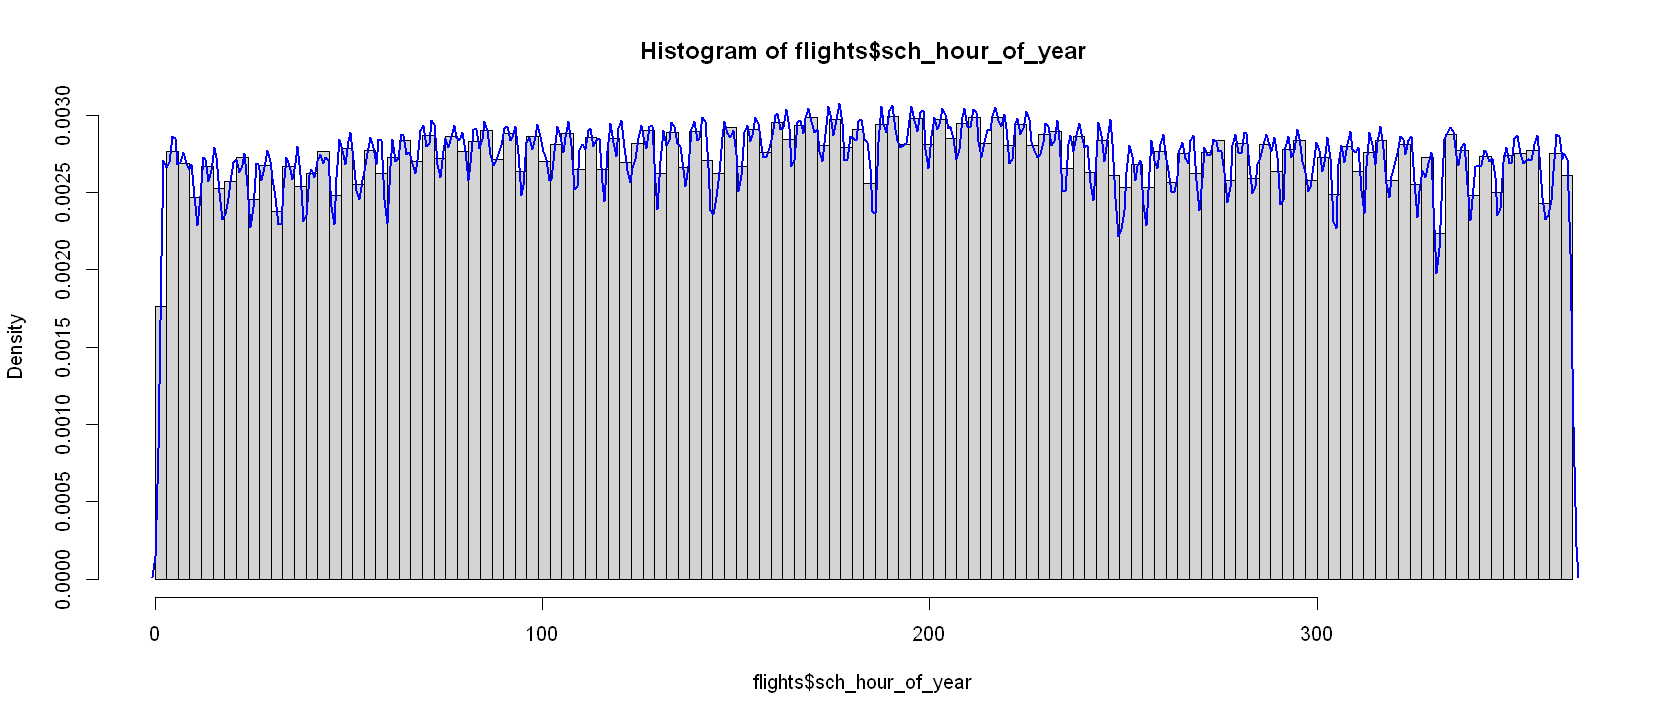

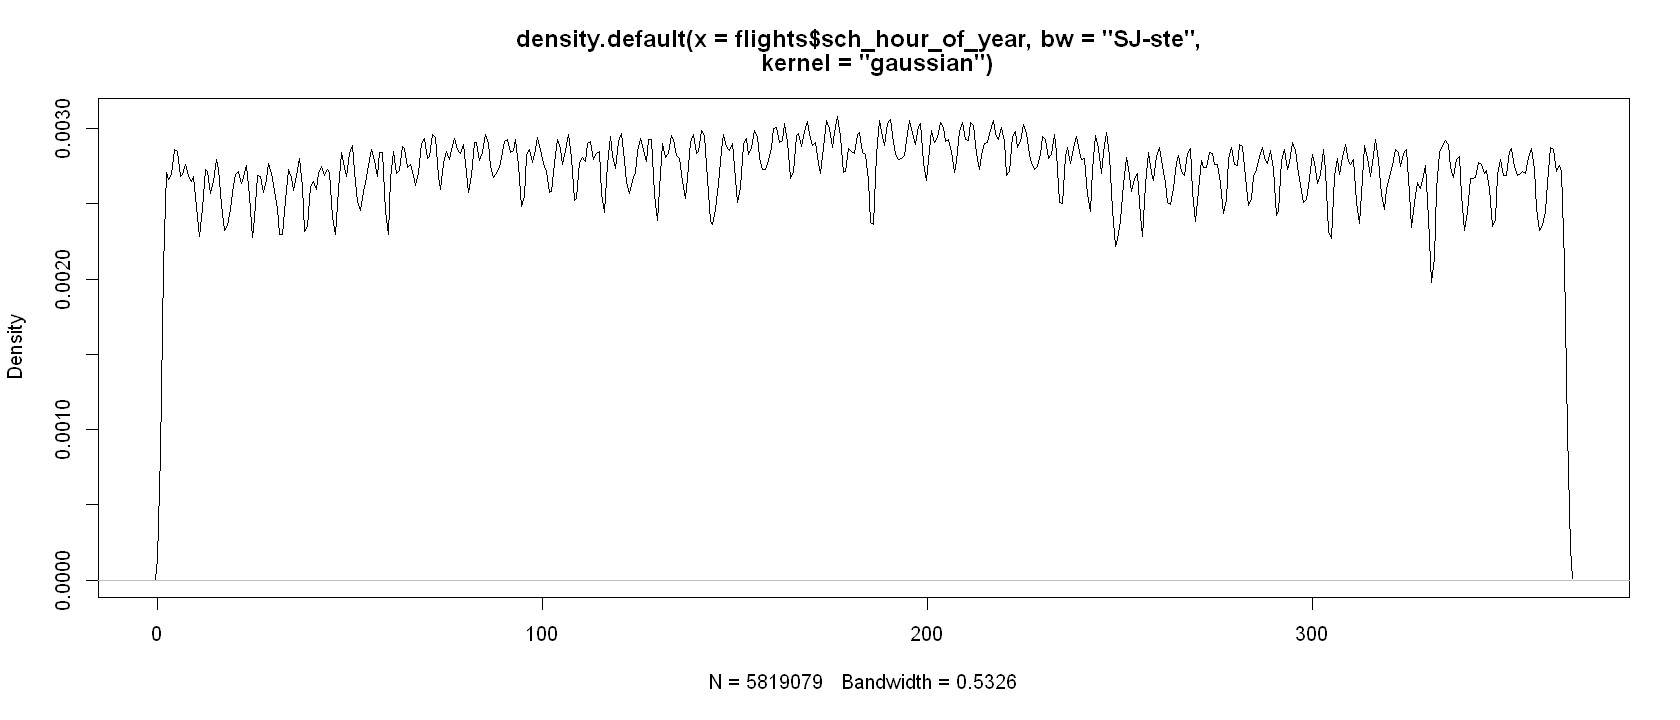

In [9]:
hist(flights$sch_hour_of_year, breaks=seq(0, 366, 3), freq = FALSE)
lines(hour.dist.all, col = "blue", lwd = 2)
plot(hour.dist.all)

In [9]:
f.hour.dist.all = approxfun(hour.dist.all$x, hour.dist.all$y)
flights$hour.dist.all = sapply(flights$sch_hour_of_year, f.hour.dist.all)

In [ ]:
day.dist.all = density(flights$day_of_year, bw="ucv", kernel="gaussian")

Warning message in bw.ucv(x):
"minimum occurred at one end of the range"


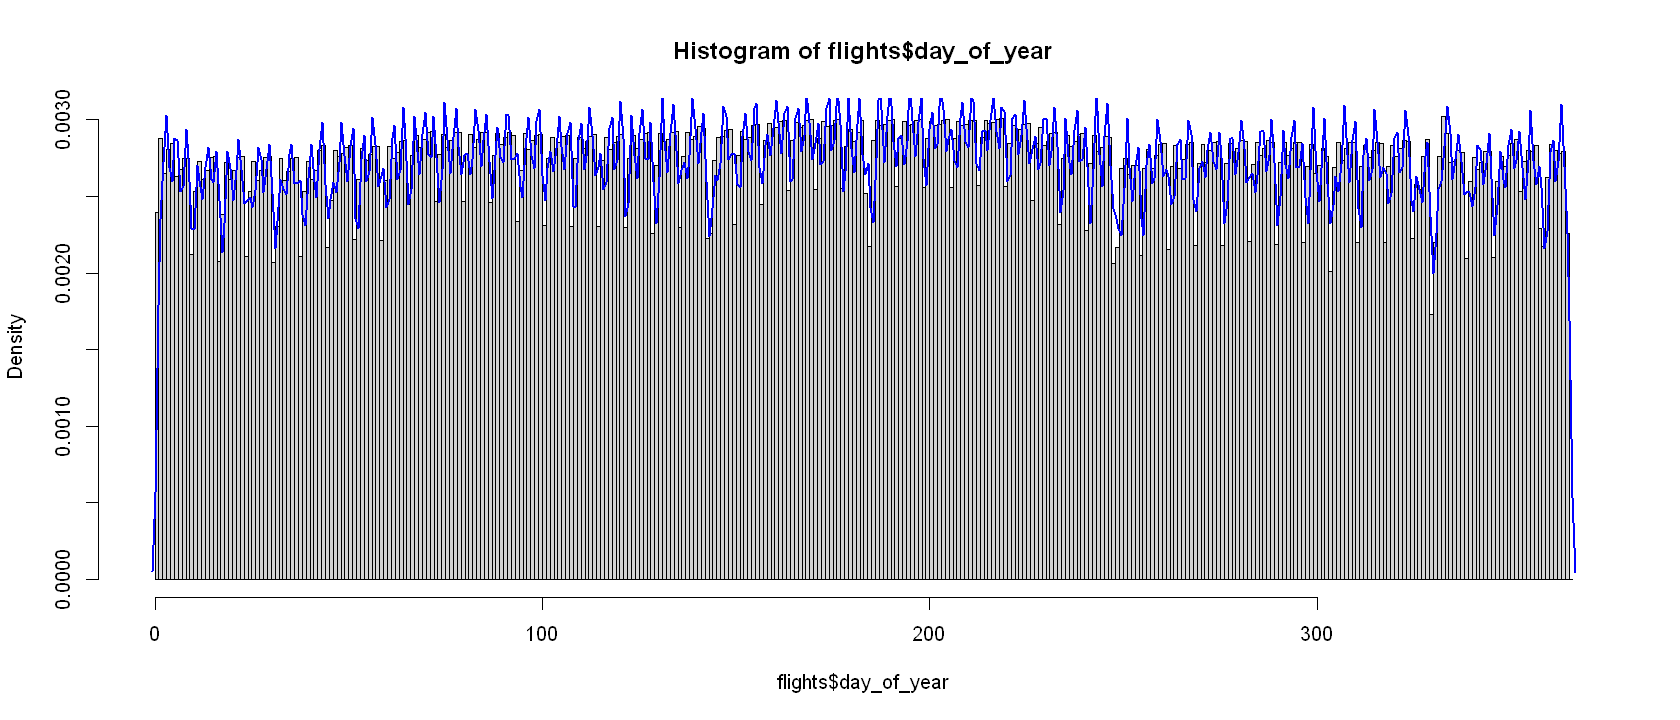

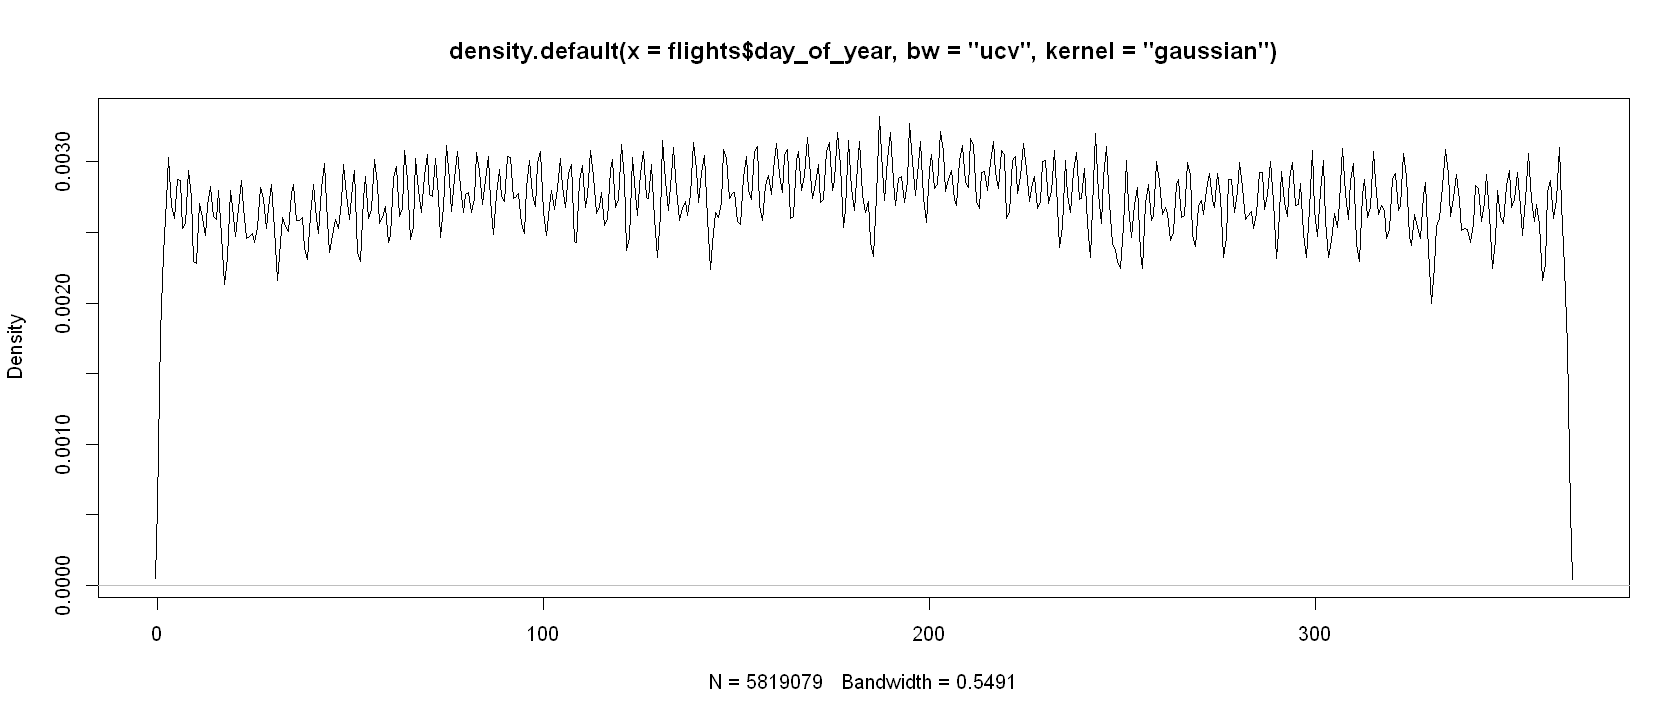

In [12]:
hist(flights$day_of_year, breaks=seq(0, 366, 1), freq = FALSE)
lines(day.dist.all, col = "blue", lwd = 2)
plot(day.dist.all)

In [11]:
f.day.dist.all = approxfun(day.dist.all$x, day.dist.all$y)
flights$day.dist.all = sapply(flights$day_of_year, f.day.dist.all)

In [12]:
day.dist.airline = aggregate(SCHEDULED_DEPARTURE ~ day_of_year + AIRLINE, data = flights, FUN = length)
day.dist.airport_d = aggregate(SCHEDULED_DEPARTURE ~ day_of_year + ORIGIN_AIRPORT, 
                               data = flights, FUN = length)
day.dist.airport_a = aggregate(SCHEDULED_DEPARTURE ~ day_of_year + DESTINATION_AIRPORT, 
                               data = flights, FUN = length)

colnames(day.dist.airline)[3] <- "daily_count_airline_specific"
colnames(day.dist.airport_d)[3] <- "daily_count_origin_specific"
colnames(day.dist.airport_a)[3] <- "daily_count_destination_specific"

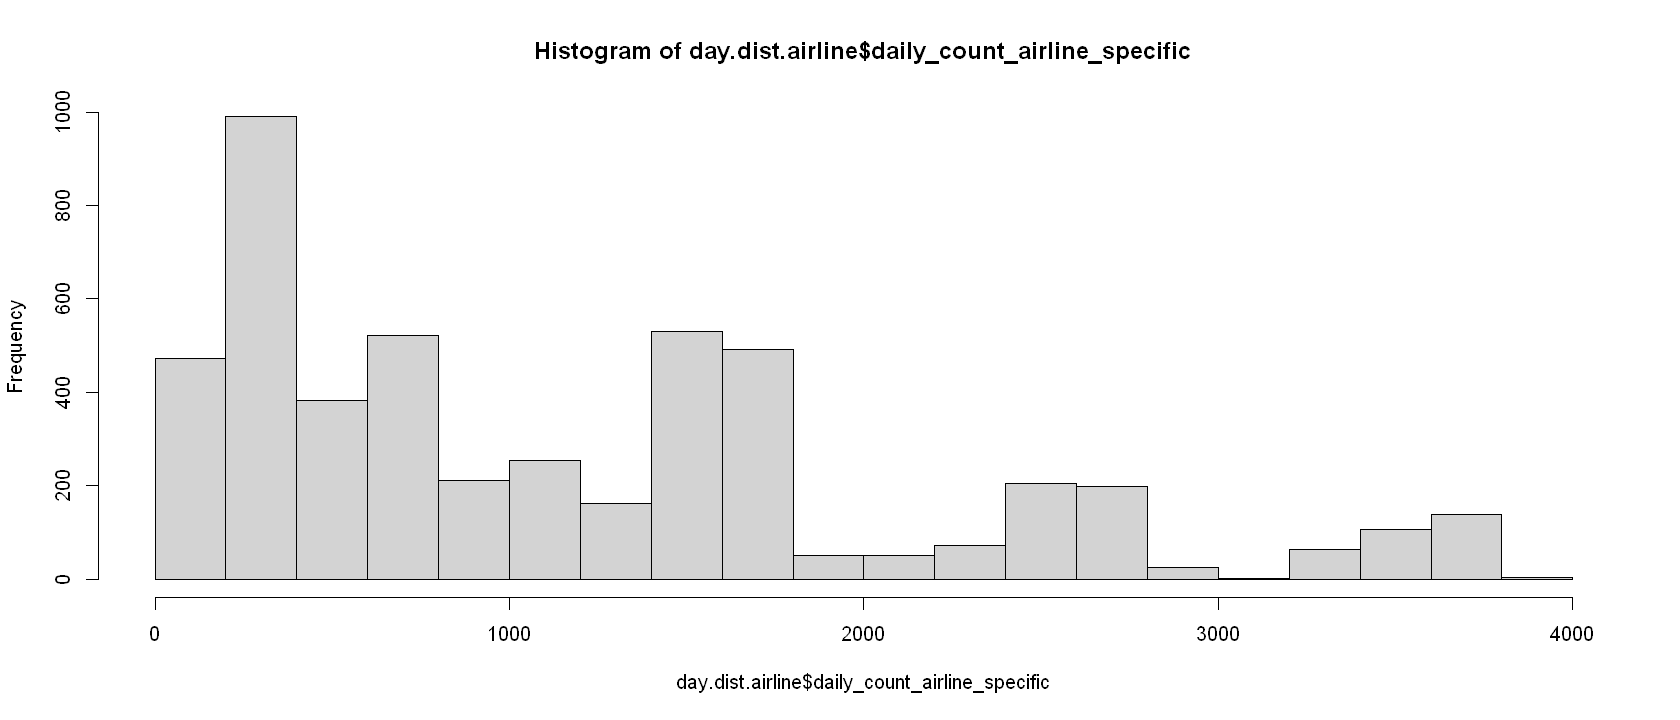

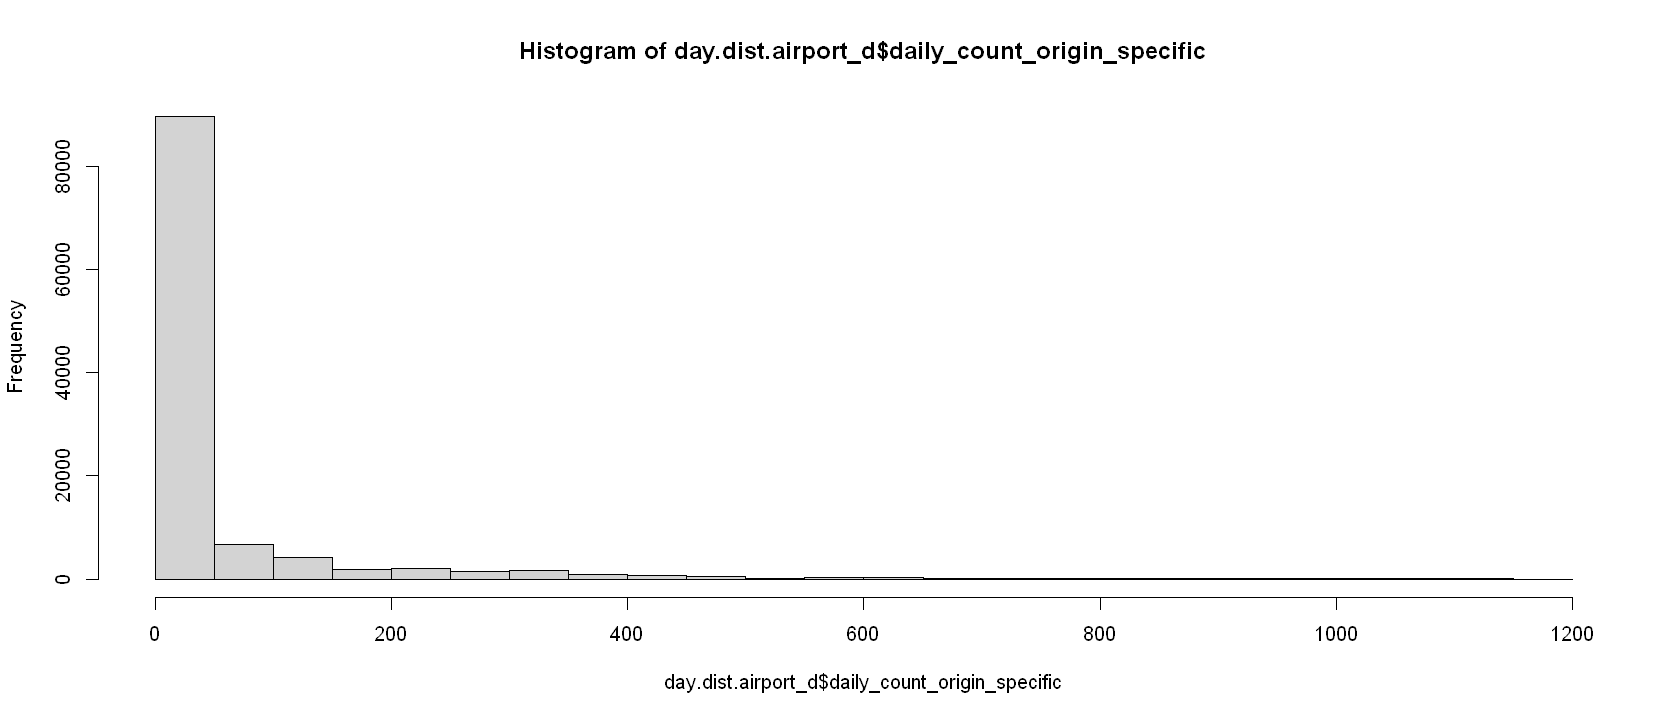

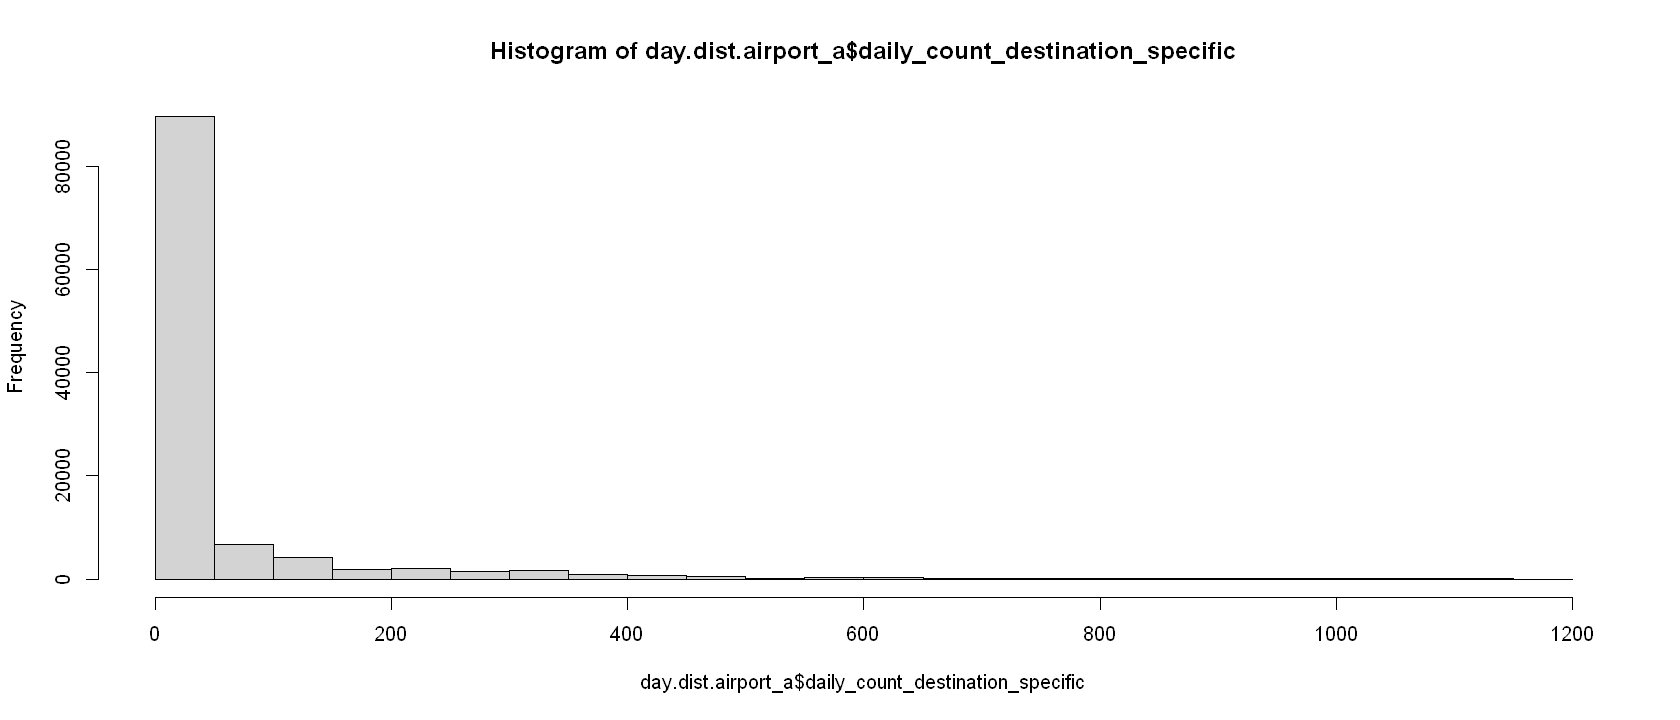

In [15]:
hist(day.dist.airline$daily_count_airline_specific)
hist(day.dist.airport_d$daily_count_origin_specific)
hist(day.dist.airport_a$daily_count_destination_specific)

In [13]:
hour.dist.airline = aggregate(SCHEDULED_DEPARTURE ~ sch_hour_of_year + AIRLINE, data = flights, FUN = length)
hour.dist.airport_d = aggregate(SCHEDULED_DEPARTURE ~ sch_hour_of_year + ORIGIN_AIRPORT, 
                               data = flights, FUN = length)
hour.dist.airport_a = aggregate(SCHEDULED_DEPARTURE ~ sch_hour_of_year + DESTINATION_AIRPORT, 
                               data = flights, FUN = length)

colnames(hour.dist.airline)[3] <- "hourly_count_airline_specific"
colnames(hour.dist.airport_d)[3] <- "hourly_count_origin_specific"
colnames(hour.dist.airport_a)[3] <- "hourly_count_destination_specific"

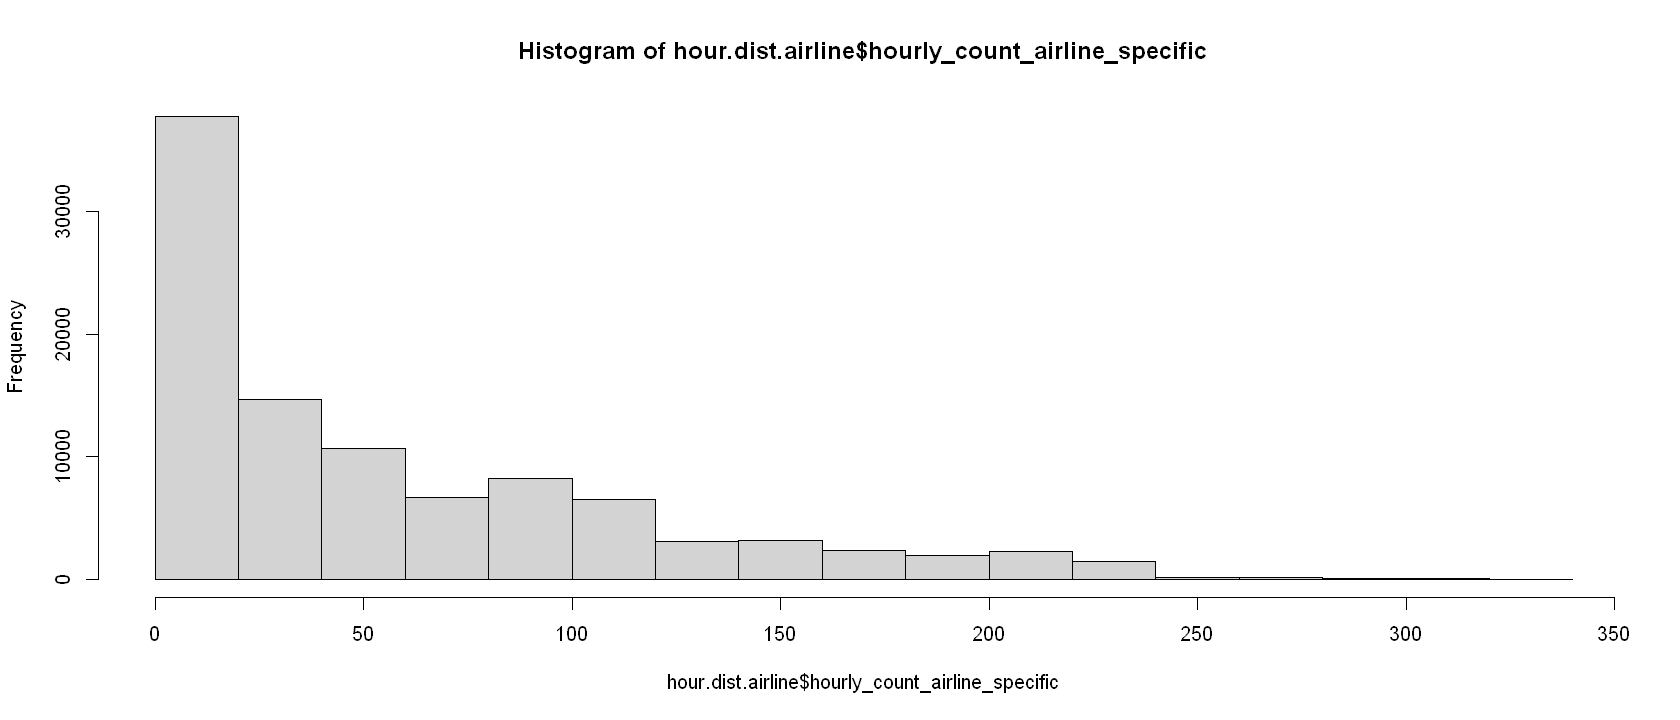

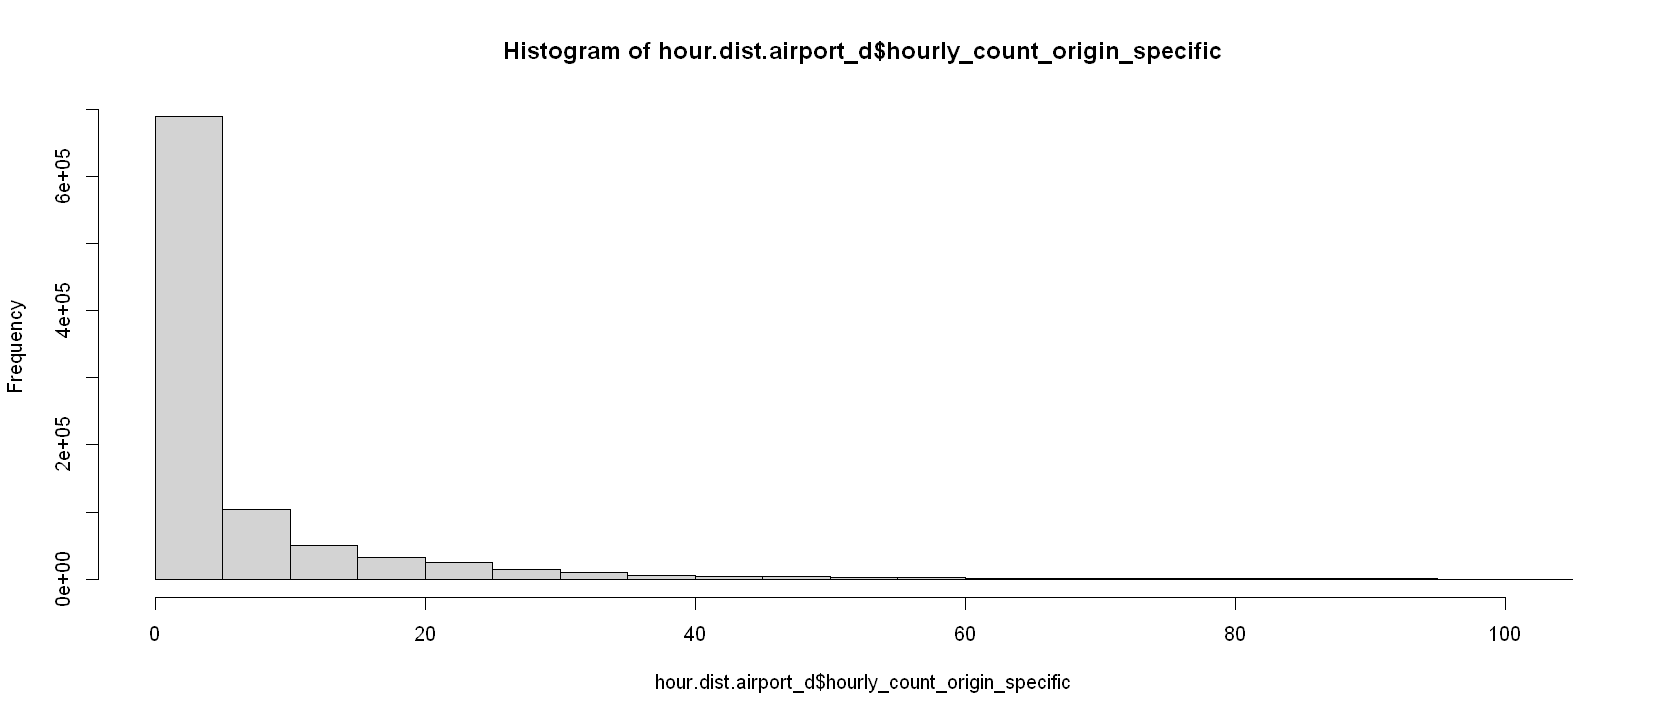

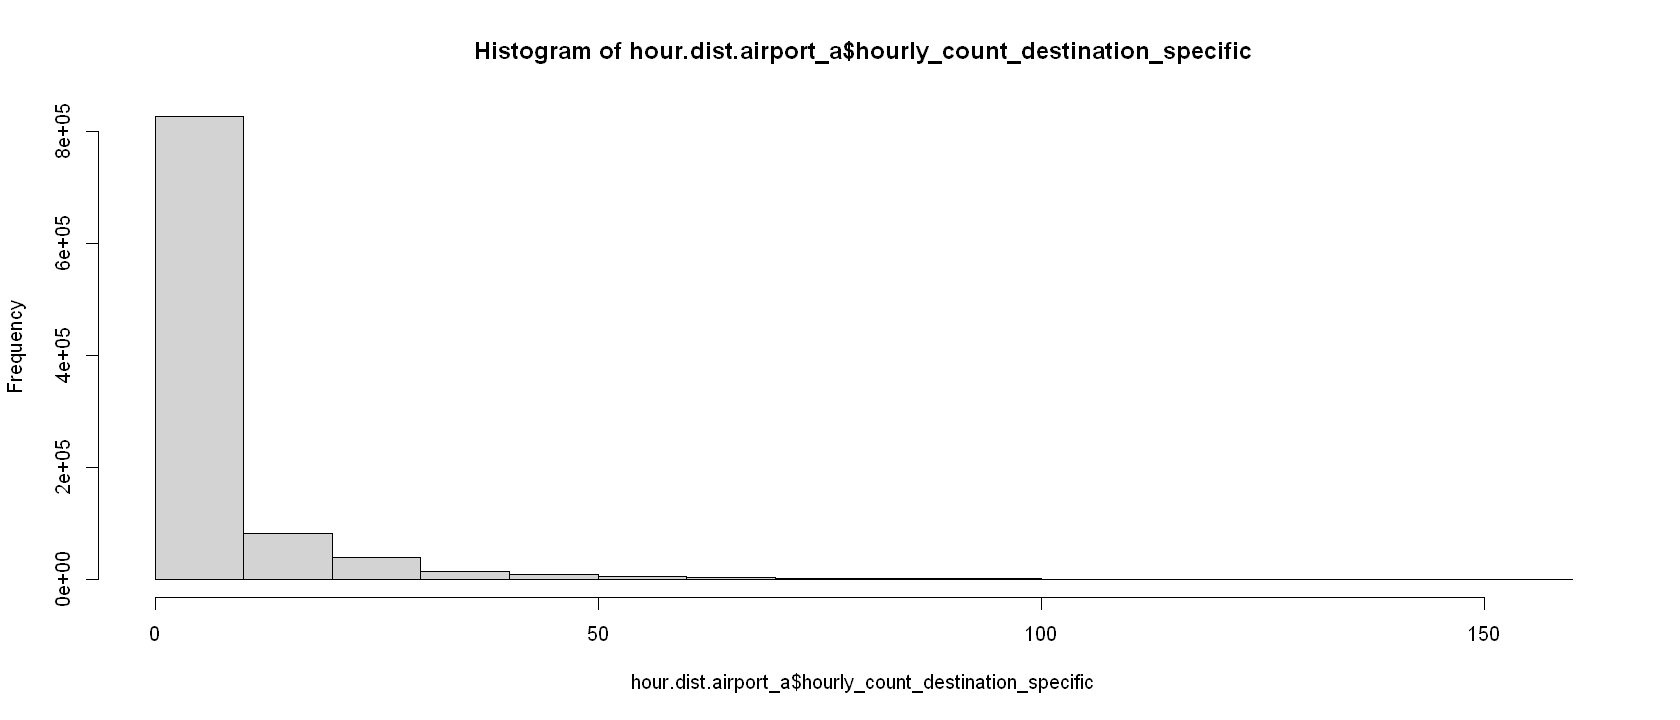

In [16]:
hist(hour.dist.airline$hourly_count_airline_specific)
hist(hour.dist.airport_d$hourly_count_origin_specific)
hist(hour.dist.airport_a$hourly_count_destination_specific)

In [14]:
flights = merge(flights, day.dist.airline[,c(1:3)], by=c("day_of_year", "AIRLINE"))
flights = merge(flights, day.dist.airport_d[,c(1:3)], by=c("day_of_year", "ORIGIN_AIRPORT"))
flights = merge(flights, day.dist.airport_a[,c(1:3)], by=c("day_of_year", "DESTINATION_AIRPORT"))
flights = merge(flights, hour.dist.airline[,c(1:3)], by=c("sch_hour_of_year", "AIRLINE"))
flights = merge(flights, hour.dist.airport_d[,c(1:3)], by=c("sch_hour_of_year", "ORIGIN_AIRPORT"))
flights = merge(flights, hour.dist.airport_a[,c(1:3)], by=c("sch_hour_of_year", "DESTINATION_AIRPORT"))

In [15]:
library(ggplot2)
library(gridExtra)

<i><b>Target attributes:</b></i>

Regarding to the part of flight delay, two types of targets were defined, separately evaluated on departure and arrivals: 1) binary outcome of whether the flight had delayed; 2) continuous outcome of the time difference (in minutes) between the actual event against the scheduled time point. The reason of treating departure and arrival individually was that in modelling arrival delay, we could get the known results of departure delay, and it would be rational to believe that delays during departure would have prolonged impacts on a higher chance of arrival delay. This could simulate just like running a mobile application capturing real-time data, the estimated probability of arrival delay could be updated after its departure. 

With some simple visualization on the target attributes, it was found that cancellations accounted for around 1.54% of the total. There were a few scenarios that the flight was tagged with diversion in the trip routes and eventually landing on another airport, which were 0.26% of the total. Among the normal flights, around 2.1 million over the 5.8 million flights were delayed, around 36% of the total (the ratio between delay and non-delay was around 0.5625 to 1.0 (Fig. 1) and this did not suffer from severely imbalanced class problem).

Considering the numerical targets (number of minutes delayed), the histograms and density plots of the departure delay and arrival delay showed a highly-skewed distribution that most delays were short delays probably within 1 hour. Taking a logarithm transformation of the target, it was more conformed to a gaussian distribution. The cumulative density function (CDF) plots were close to the CDF of a Gamma distribution with shape parameter α = 0.5 and rate parameter λ = 1. This suggested a Gamma distribution with logarithm link function would be an appropriate choice for fitting a generalized linear model (GLM) on these targets. The domain of a Gamma response does not allow non-positive values, while the target variables were obtained as the time difference between scheduled and actual events, and hence it contained negative values. Only positive delays were extracted for fitting the Gamma-distributed response.

In [16]:
cancel_data <- aggregate(SCHEDULED_DEPARTURE ~ CANCELLED, data = flights, FUN = length)
cancel_data$percent <- sapply(cancel_data$SCHEDULED_DEPARTURE, 
                              function(x){x/sum(cancel_data$SCHEDULED_DEPARTURE)})

divert_data <- aggregate(SCHEDULED_DEPARTURE ~ DIVERTED, data = flights, FUN = length)
divert_data$percent <- sapply(divert_data$SCHEDULED_DEPARTURE, 
                              function(x){x/sum(divert_data$SCHEDULED_DEPARTURE)})

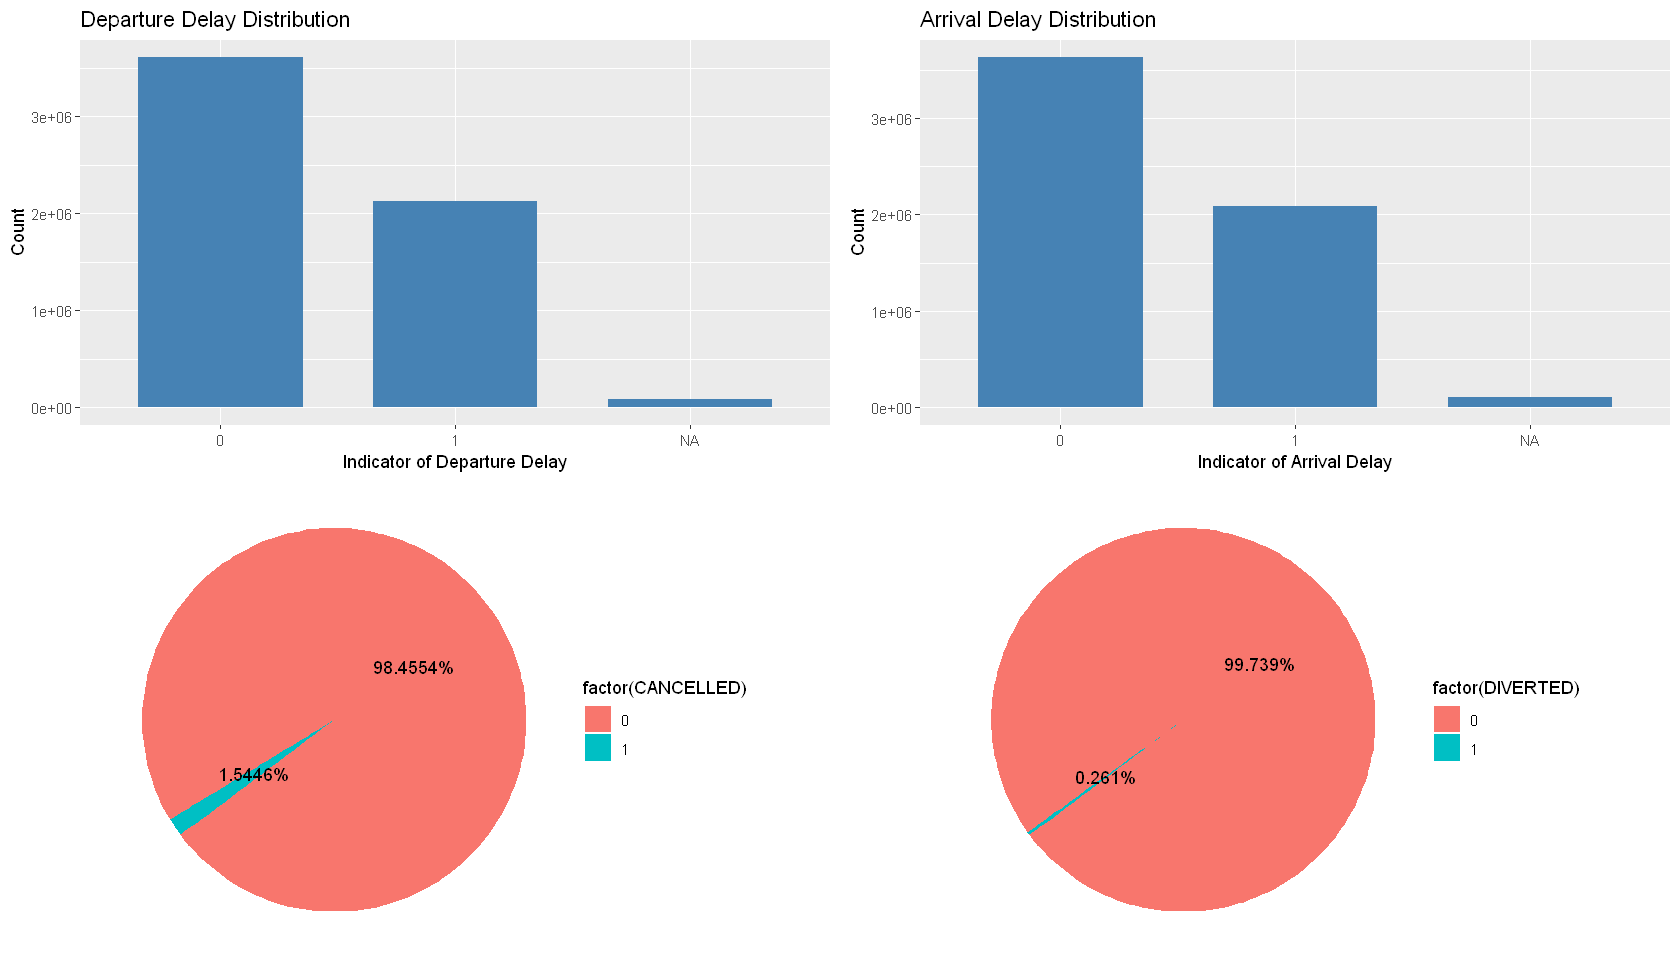

In [17]:
p1 = ggplot(data=flights, aes(x=factor(depart_delay_ind))) +
      geom_bar(stat="count", width=0.7, fill="steelblue") + 
      labs(title="Departure Delay Distribution", x="Indicator of Departure Delay", y = "Count")

p2 = ggplot(data=flights, aes(x=factor(arrive_delay_ind))) +
      geom_bar(stat="count", width=0.7, fill="steelblue") + 
      labs(title="Arrival Delay Distribution", x="Indicator of Arrival Delay", y = "Count")

p3 = ggplot(data=cancel_data, aes(x="", y=SCHEDULED_DEPARTURE, fill=factor(CANCELLED))) +
      geom_bar(stat="identity", width = 1) +
      coord_polar("y", start=180) +
      theme_void() +
      geom_text(aes(label=paste0(round(percent*100, 4), '%')), position = position_stack(vjust = 0.5))

p4 = ggplot(data=divert_data, aes(x="", y=SCHEDULED_DEPARTURE, fill=factor(DIVERTED))) +
      geom_bar(stat="identity", width = 1) +
      coord_polar("y", start=180) +
      theme_void() +
      geom_text(aes(label=paste0(round(percent*100, 4), '%')), position = position_stack(vjust = 0.5))

options(repr.plot.width=14, repr.plot.height=8)
grid.arrange(p1, p2, p3, p4, nrow=2, ncol=2)

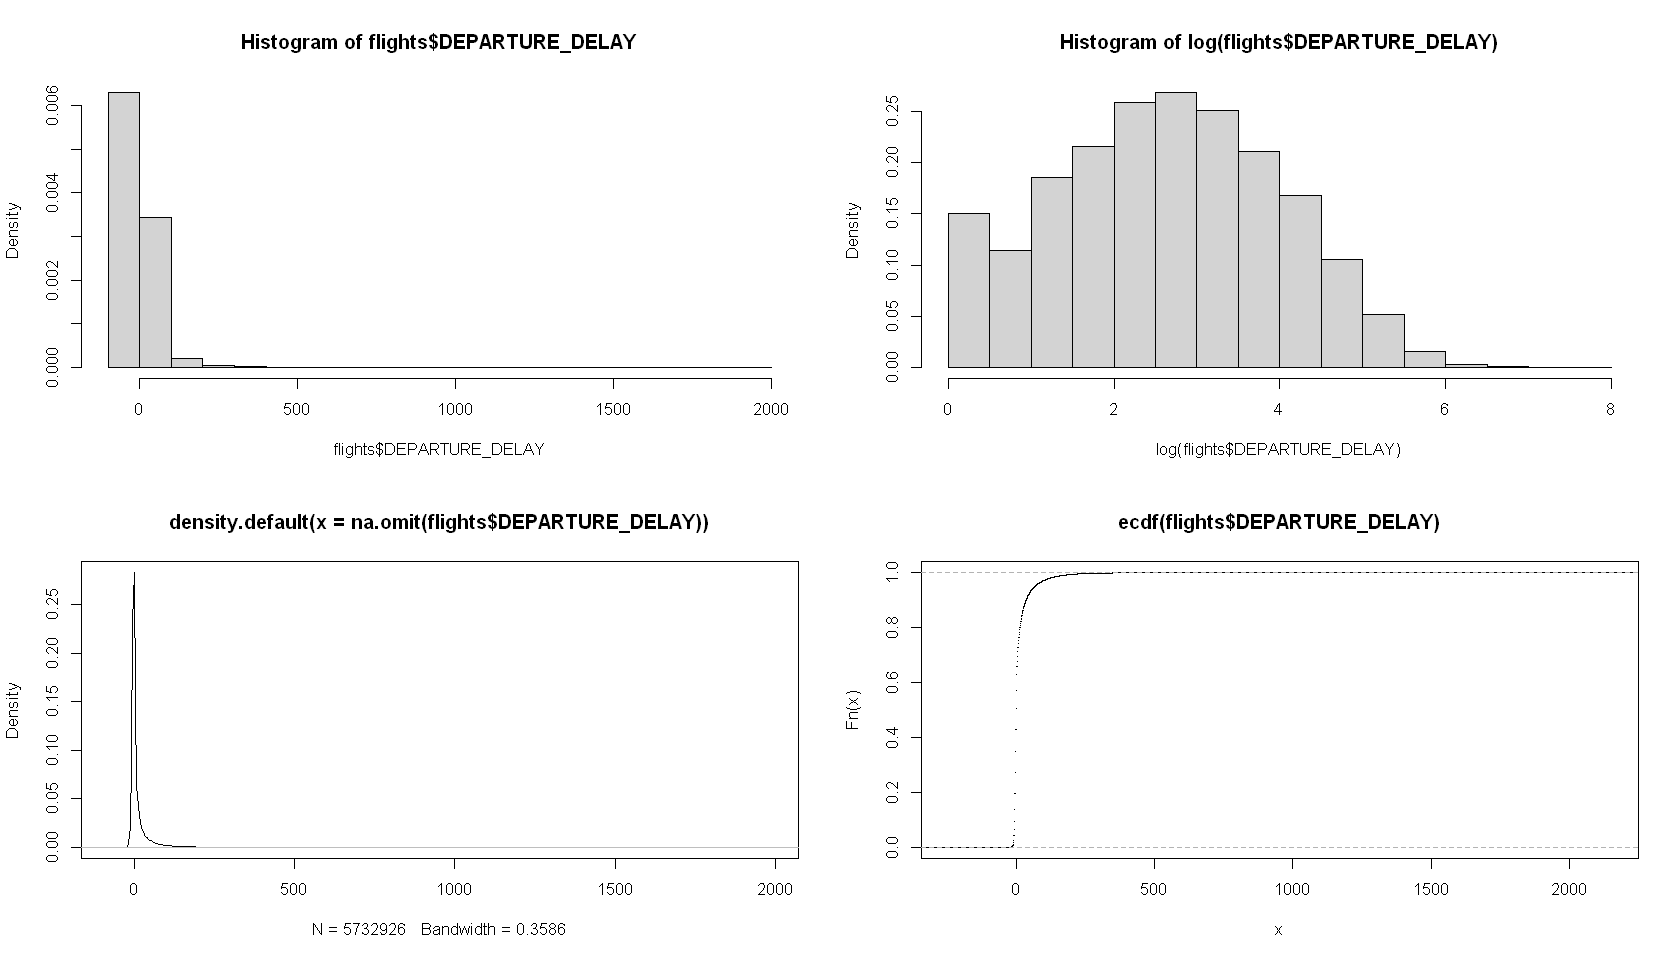

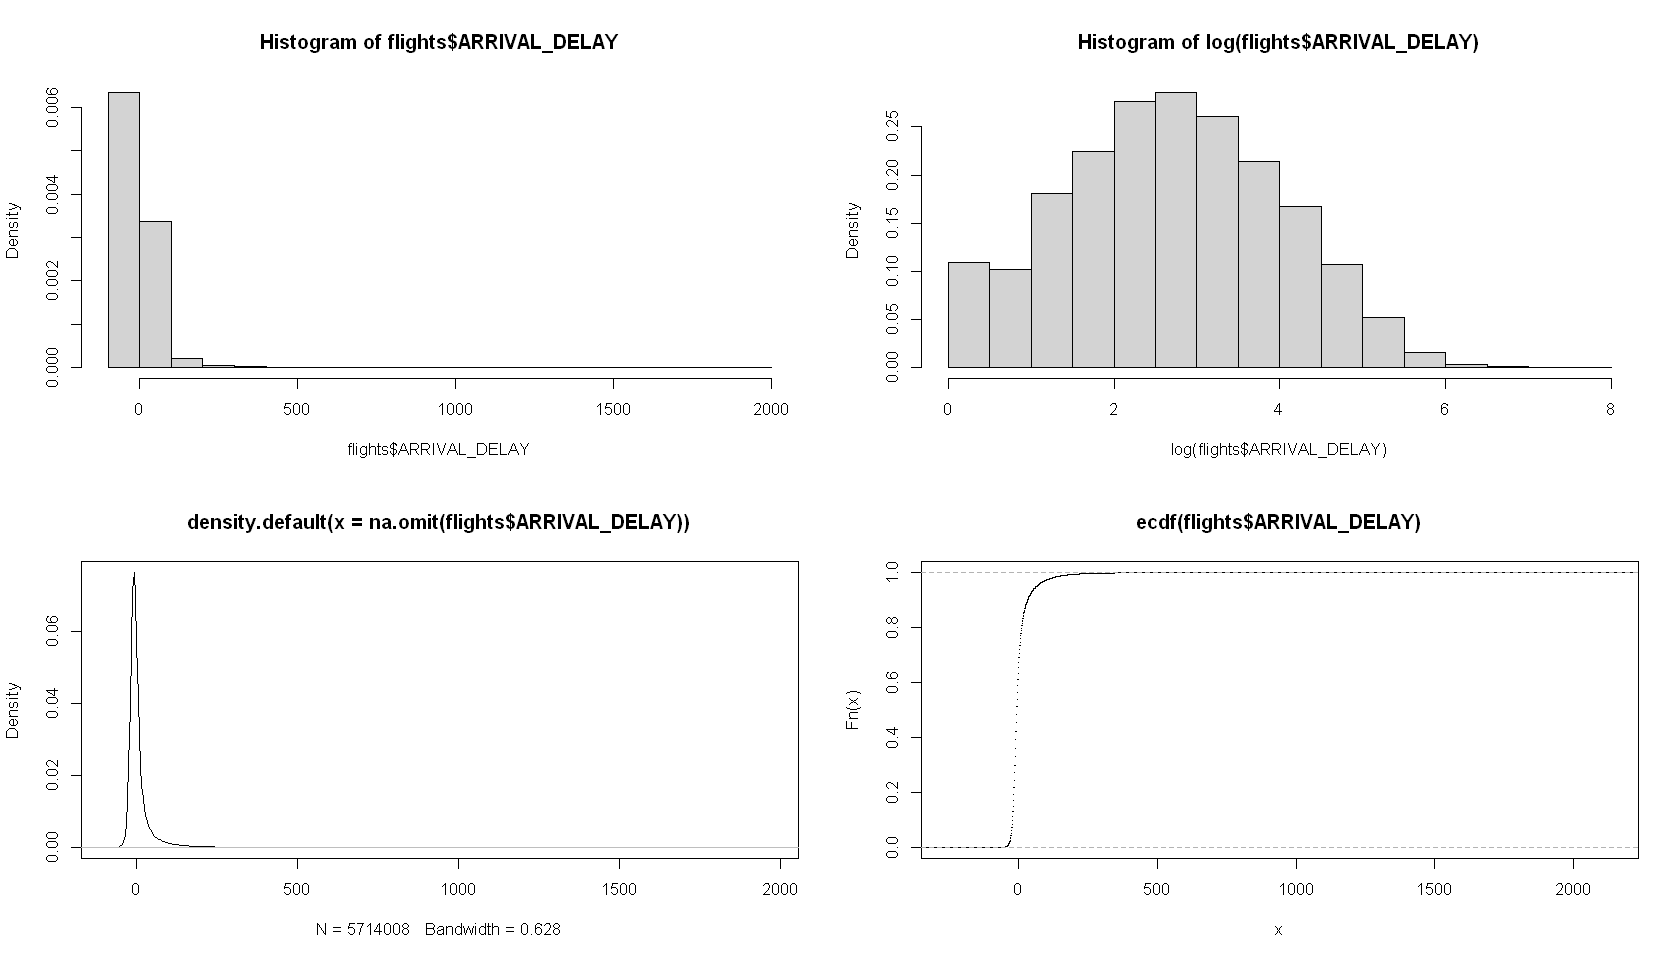

In [27]:
options(repr.plot.width=14, repr.plot.height=8)
par(mfrow=c(2,2))

## departure delay
## distribution investigations
hist(flights$DEPARTURE_DELAY, freq = FALSE)
hist(log(flights$DEPARTURE_DELAY), freq = FALSE)
plot(density(na.omit(flights$DEPARTURE_DELAY)))
plot(ecdf(flights$DEPARTURE_DELAY))

## arrival delay
## distribution investigations
hist(flights$ARRIVAL_DELAY, freq = FALSE)
hist(log(flights$ARRIVAL_DELAY), freq = FALSE)
plot(density(na.omit(flights$ARRIVAL_DELAY)))
plot(ecdf(flights$ARRIVAL_DELAY))

In [16]:
flights2 = subset(flights, flights[,'DIVERTED'] != 1)[,
                      c('MONTH','DAY','DAY_OF_WEEK','AIRLINE','ORIGIN_AIRPORT','DESTINATION_AIRPORT',
                      'FLIGHT_NUMBER','TAIL_NUMBER','day_of_year','sch_hour_of_year',
                      'day.dist.all','hour.dist.all','daily_count_airline_specific',
                      'daily_count_origin_specific','daily_count_destination_specific',
                      'hourly_count_airline_specific','hourly_count_origin_specific',
                      'hourly_count_destination_specific','DISTANCE','SCHEDULED_TIME',
                      'sch_depart_hour','sch_depart_min','DEPARTURE_DELAY', 'depart_delay_ind','TAXI_OUT',
                      'sch_arrive_hour','sch_arrive_min','ARRIVAL_DELAY','arrive_delay_ind',
                      'CANCELLED','CANCELLATION_REASON','AIR_SYSTEM_DELAY','SECURITY_DELAY',
                      'AIRLINE_DELAY','LATE_AIRCRAFT_DELAY','WEATHER_DELAY')]

In [17]:
features_depart = c(1:6,9:22,26:27)
target_depart = 23:24
features_arrive = c(1:6,9:23,25:27)
target_arrive = 28:29

In [18]:
flights2_non_cancel = subset(flights2, flights2[,'CANCELLED'] != 1)

<i><b>Random Sampling to get a subset for analysis:</b></i>

Concerning the huge size of the dataset, it would be computationally expensive for running GLM related methods and costly in time for getting the convergence of parameter estimates. In machine learning, big data models might be formulated from other algorithms with the help of an efficient computational tool. However, the purpose of this study was making statistical inference to the population, and drawing a random sample would suffice, meanwhile saving the time for feasible implementations on R.

There were over 4,000 levels of flight numbers and over 6,000 levels of tail numbers for unique identifier of aircrafts. Incorporating these two factors would increase the dimensionality significantly. 628 airports were involved in the US aviation network of commercial flights, and the combinations of origin airports and destination airports would form the routes. This study first extracted routes with at least 100 flights throughout the year, and randomly selected 20% samples from the extracted routes. Then for each route, 100 records were randomly drawn, the sampled dataframe comprised of 112,300 rows, around 2% of all non-cancelled data.

For stratified splitting by the two binary targets, as well as the gamma-distributed delayed observations, 90% of the sampled data served as the training set while the remaining 10% was reserved for testing and evaluation purpose. The training set thus contained around 100,000 rows. 

A correlation matrix among numerical explanatory variables were produced. There were moderately positive correlations between the scheduled day and hour, time length and distance of the trip, yet most variables did not suffer from severe multi-collinearity.

In [19]:
library(dplyr)

## flight routes
routes = aggregate(flights2_non_cancel[, c("AIRLINE")], 
                   by=list(flights2_non_cancel$ORIGIN_AIRPORT, flights2_non_cancel$DESTINATION_AIRPORT), FUN=length)
## select > 100 flights
routes2 = subset(routes, routes[,3]>100)

## random sample 20% of total routes
set.seed(1234)
sample_routes = sample_n(routes2, round(dim(routes2)[1]*0.2))
sample_routes$route = paste(sample_routes$Group.1, sample_routes$Group.2)
flights2_non_cancel$route = paste(flights2_non_cancel$ORIGIN_AIRPORT, flights2_non_cancel$DESTINATION_AIRPORT)
flights_sample = flights2_non_cancel[flights2_non_cancel$route %in% sample_routes$route, ]

## random sample 100 rows per each route group
flights_sample_route = flights_sample %>% group_by(route) %>% sample_n(100)

In [ ]:
library(glm2)
library(lme4)
library(gam)
library(mgcv)
library(gamm4)
library(robustbase)
library(lmtest)
library(MASS)
library(pROC)

In [ ]:
library(caret)
## slice dataframe into training dataset (90%) and testing dataset (10%)

## stratified sampling by class weight of departure delay
set.seed(1234)
train.index.depart = createDataPartition(flights_sample_route$depart_delay_ind, 
                                         p = 0.9, list = FALSE, )
train.depart = flights_sample_route[train.index.depart,]
test.depart = flights_sample_route[-train.index.depart,]

train.index.arrive= createDataPartition(flights_sample_route$arrive_delay_ind, 
                                         p = 0.9, list = FALSE)
train.arrive = flights_sample_route[train.index.arrive,]
test.arrive = flights_sample_route[-train.index.arrive,]

train.depart.delay = subset(train.depart, train.depart[,'depart_delay_ind'] == 1)
train.arrive.delay = subset(train.arrive, train.arrive[,'arrive_delay_ind'] == 1)

test.depart.delay = subset(test.depart, test.depart[,'depart_delay_ind'] == 1)
test.arrive.delay = subset(test.arrive, test.arrive[,'arrive_delay_ind'] == 1)

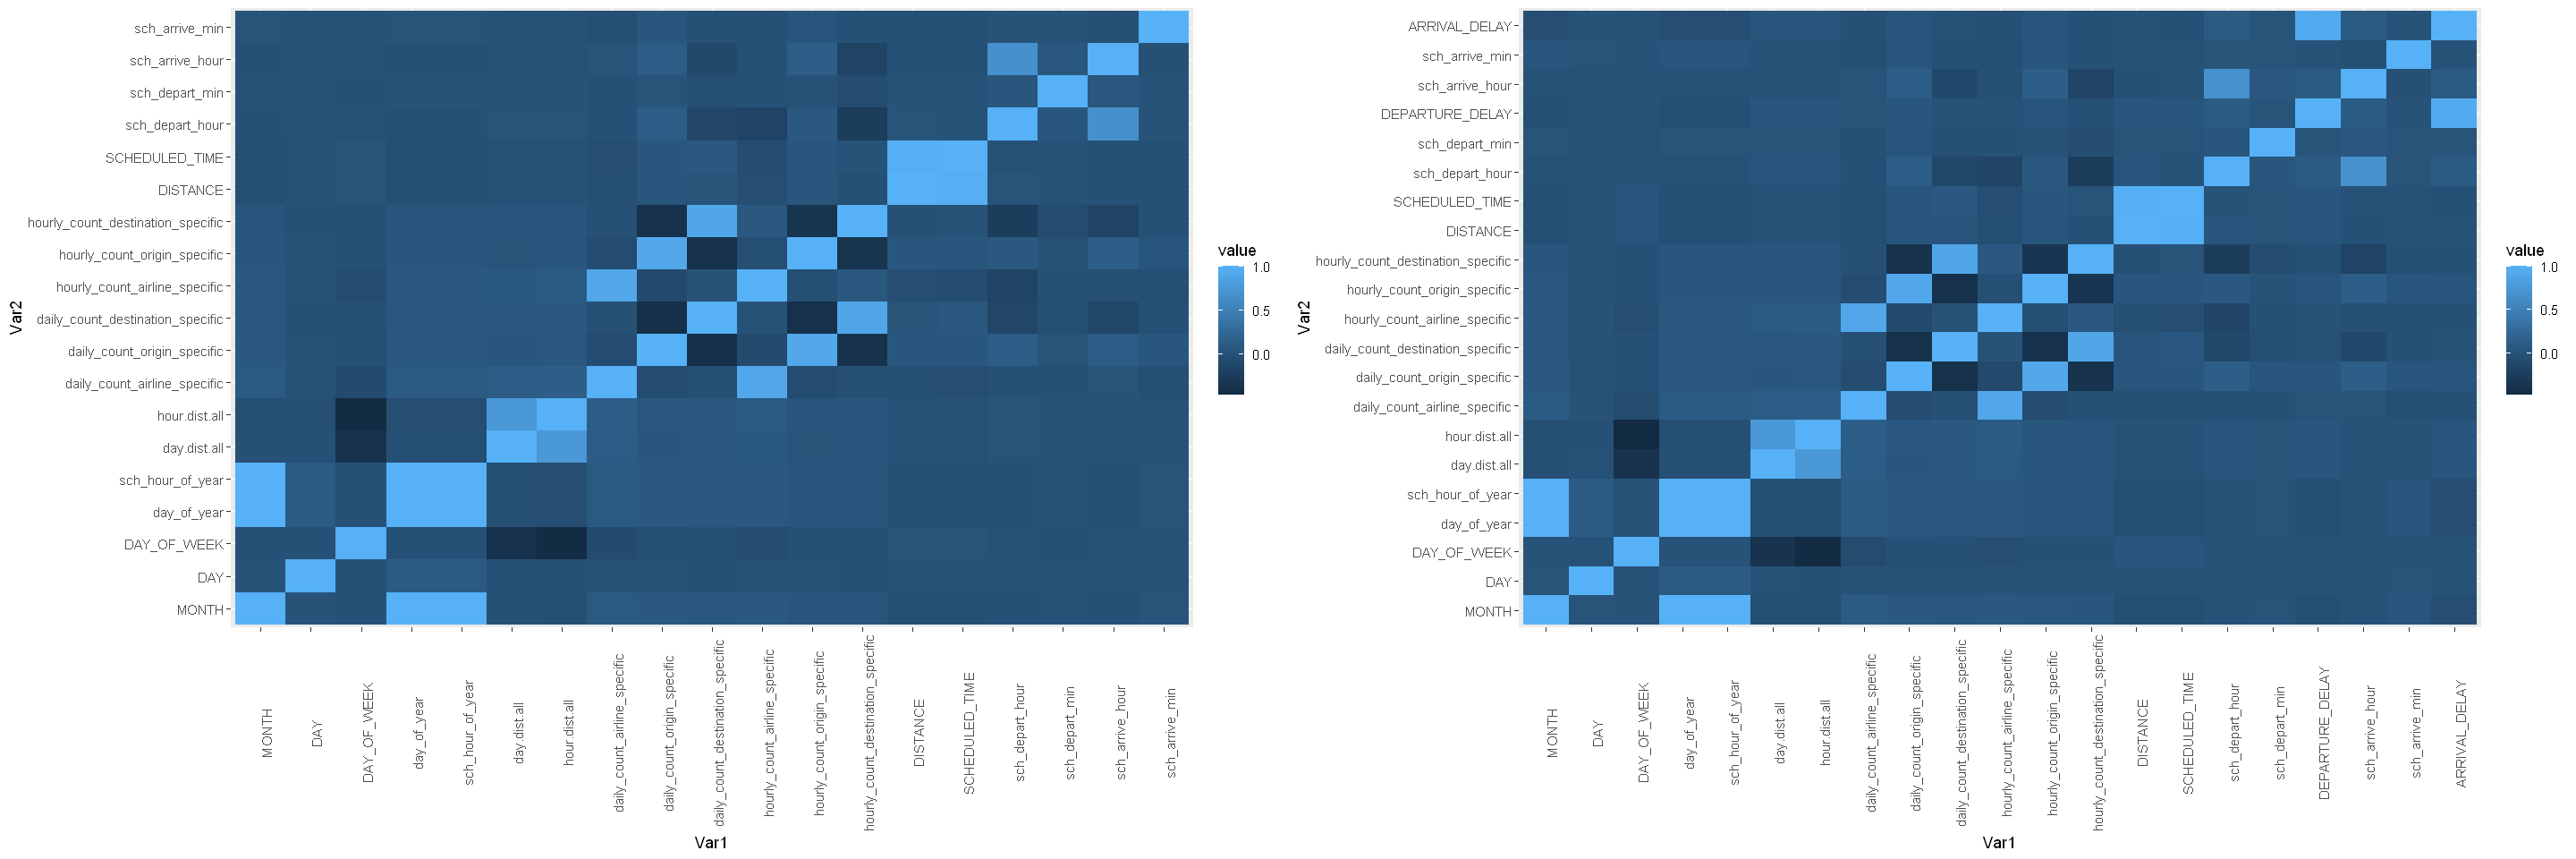

In [40]:
library(reshape2)
options(repr.plot.width=24, repr.plot.height=8)

corr_mat = melt(round(cor(train.depart[,c(1:3,9:22,26:27)]),2))

cor1 = ggplot(data = corr_mat, aes(x=Var1, y=Var2, fill=value)) + geom_tile() + 
          theme(axis.text.x = element_text(angle = 90))

corr_mat2 = melt(round(cor(train.arrive[,c(1:3,9:23,26:28)]),2))

cor2 = ggplot(data = corr_mat2, aes(x=Var1, y=Var2, fill=value)) + geom_tile() + 
          theme(axis.text.x = element_text(angle = 90))

grid.arrange(cor1, cor2, nrow=1, ncol=2)

In [22]:
dim(flights_sample_route)[1]

[1] 112300

In [24]:
## print options
options(max.print=10000)

<i><b>Model Specifications:</b></i>

Logistic regression models were fitted to predict the probability of delays upon departure and arrival. <br>
Gamma regression models were fitted to predict the extent of delays upon departure and arrival.

Focusing on the non-parametric regression methods, <br>

1) the first model was an additive partial linear model (GAPLM) with smoothing components (cubic natural spline; as specified by bs="cr" in the input of smoothing terms) on numerical attributes and parametric coefficients per level of the three categorical attributes; <br>

2) the second model was an additive mixed effect model (GAMM) with the same smoothing components on numerical attributes, but the three categorical attributes were served as random effects; since the routes were random samples, it justified the airline-specific and airport-specific probability distributions and correlation of observations within the group, therefore airlines and airports could be treated as the random effects; it would be fitting a random intercept only per each subject-specific level (as specified by bs="re" in the input of smoothing terms), as it would be quite time consuming to get all random slopes for each fixed effect and the models might be difficult to converge due to complexity in variance structure; <br>

3) the third model was a robust regression model with all attributes linearly combined; <br>

4) the fourth model was a generalized linear model (GLM) version of the third one, without robust handling on outliers for making comparisons. <br>

Due to positive number constraints, only delayed records (~ 35,000 rows) were processed with the Gamma GLM. The existence of non-linear relationships in a generalized additive model would be determined from the partial regression plots of smoothing components against parametric components. Methods for evaluations of the fitted models included the analysis of residual deviance and Akaike information criterion (AIC). For logistic regression, classification performance metrics like accuracy, sensitivity, specificity, ROC curve and confusion matrix for predictions made on the testing data would be reported. For Gamma regression, the testing performance would be monitored by mean absolute errors.

For computational efficiency concerns raised from fitting on large-sized dataset, the mgcv package provides option of using bam() function, and availability of fast restricted maximum likelihood (fREML) as the optimization algorithm. The robust regression used a conventional Mallows or Huber type robust estimators. 

In [358]:
## binary response & non-zero gamma response
## exclude flight number and tail number (too many levels: over 4000 and 6000)

### i)   additive partial linear model (GAPLM)
### ii)  additive mixed effect model (GAMM)
### iii) fixed effect robust regression model (Robust GLM)
### iv)  fixed effect linear regression model (GLM)

In [23]:
logistic_depart_1 = mgcv::bam(depart_delay_ind ~ 
                 s(MONTH, bs="cr") + s(DAY, bs="cr") + s(DAY_OF_WEEK, k=7, bs="cr") +
                 s(day_of_year, bs="cr") + s(sch_hour_of_year, bs="cr") + s(day.dist.all, bs="cr") + s(hour.dist.all, bs="cr") +
                 s(daily_count_airline_specific, bs="cr") + s(daily_count_origin_specific, bs="cr") + s(daily_count_destination_specific, bs="cr") +
                 s(hourly_count_airline_specific, bs="cr") + s(hourly_count_origin_specific, bs="cr") + s(hourly_count_destination_specific, bs="cr") +
                 s(DISTANCE, bs="cr") + s(SCHEDULED_TIME, bs="cr") +
                 s(sch_depart_hour, bs="cr") + s(sch_depart_min, bs="cr") + s(sch_arrive_hour, bs="cr") + s(sch_arrive_min, bs="cr") +
                 AIRLINE + ORIGIN_AIRPORT + DESTINATION_AIRPORT,
            family=binomial(link="logit"), data=train.depart, method="fREML")

In [24]:
logistic_depart_2 = mgcv::bam(depart_delay_ind ~ 
                 s(MONTH, bs="cr") + s(DAY, bs="cr") + s(DAY_OF_WEEK, k=7, bs="cr") +
                 s(day_of_year, bs="cr") + s(sch_hour_of_year, bs="cr") + s(day.dist.all, bs="cr") + s(hour.dist.all, bs="cr") +
                 s(daily_count_airline_specific, bs="cr") + s(daily_count_origin_specific, bs="cr") + s(daily_count_destination_specific, bs="cr") +
                 s(hourly_count_airline_specific, bs="cr") + s(hourly_count_origin_specific, bs="cr") + s(hourly_count_destination_specific, bs="cr") +
                 s(DISTANCE, bs="cr") + s(SCHEDULED_TIME, bs="cr") +
                 s(sch_depart_hour, bs="cr") + s(sch_depart_min, bs="cr") + s(sch_arrive_hour, bs="cr") + s(sch_arrive_min, bs="cr") +
                 s(AIRLINE, bs="re") + s(ORIGIN_AIRPORT, bs="re") + s(DESTINATION_AIRPORT, bs="re"),
            family=binomial(link="logit"), data=train.depart, method="fREML")

In [34]:
logistic_depart_3 = glmrob(depart_delay_ind ~ 
                 MONTH + DAY + DAY_OF_WEEK +
                 day_of_year + sch_hour_of_year + day.dist.all + hour.dist.all +
                 daily_count_airline_specific + daily_count_origin_specific + daily_count_destination_specific +
                 hourly_count_airline_specific + hourly_count_origin_specific + hourly_count_destination_specific +
                 DISTANCE + SCHEDULED_TIME +
                 sch_depart_hour + sch_depart_min + sch_arrive_hour + sch_arrive_min +
                 AIRLINE + ORIGIN_AIRPORT + DESTINATION_AIRPORT,
            family=binomial(link="logit"), method = "Mqle", data=train.depart)

initial start 'theta' has NA's; eliminating columns X[, j]; j =  17, 355, 495, 585 


In [125]:
logistic_depart_4 = glm(depart_delay_ind ~ 
                 MONTH + DAY + DAY_OF_WEEK +
                 day_of_year + sch_hour_of_year + day.dist.all + hour.dist.all +
                 daily_count_airline_specific + daily_count_origin_specific + daily_count_destination_specific +
                 hourly_count_airline_specific + hourly_count_origin_specific + hourly_count_destination_specific +
                 DISTANCE + SCHEDULED_TIME +
                 sch_depart_hour + sch_depart_min + sch_arrive_hour + sch_arrive_min +
                 AIRLINE + ORIGIN_AIRPORT + DESTINATION_AIRPORT,
            family=binomial(link="logit"), data=train.depart)

In [25]:
gamma_depart_1 = mgcv::bam(DEPARTURE_DELAY ~ 
             s(MONTH, bs="cr") + s(DAY, bs="cr") + s(DAY_OF_WEEK, k=7, bs="cr") +
             s(day_of_year, bs="cr") + s(sch_hour_of_year, bs="cr") + s(day.dist.all, bs="cr") + s(hour.dist.all, bs="cr") +
             s(daily_count_airline_specific, bs="cr") + s(daily_count_origin_specific, bs="cr") + s(daily_count_destination_specific, bs="cr") +
             s(hourly_count_airline_specific, bs="cr") + s(hourly_count_origin_specific, bs="cr") + s(hourly_count_destination_specific, bs="cr") +
             s(DISTANCE, bs="cr") + s(SCHEDULED_TIME, bs="cr") +
             s(sch_depart_hour, bs="cr") + s(sch_depart_min, bs="cr") + s(sch_arrive_hour, bs="cr") + s(sch_arrive_min, bs="cr") +
             AIRLINE + ORIGIN_AIRPORT + DESTINATION_AIRPORT,
        family=Gamma(link="log"), data=train.depart.delay, method="fREML")

In [26]:
gamma_depart_2 = mgcv::bam(DEPARTURE_DELAY ~ 
             s(MONTH, bs="cr") + s(DAY, bs="cr") + s(DAY_OF_WEEK, k=7, bs="cr") +
             s(day_of_year, bs="cr") + s(sch_hour_of_year, bs="cr") + s(day.dist.all, bs="cr") + s(hour.dist.all, bs="cr") +
             s(daily_count_airline_specific, bs="cr") + s(daily_count_origin_specific, bs="cr") + s(daily_count_destination_specific, bs="cr") +
             s(hourly_count_airline_specific, bs="cr") + s(hourly_count_origin_specific, bs="cr") + s(hourly_count_destination_specific, bs="cr") +
             s(DISTANCE, bs="cr") + s(SCHEDULED_TIME, bs="cr") +
             s(sch_depart_hour, bs="cr") + s(sch_depart_min, bs="cr") + s(sch_arrive_hour, bs="cr") + s(sch_arrive_min, bs="cr") +
             s(AIRLINE, bs="re") + s(ORIGIN_AIRPORT, bs="re") + s(DESTINATION_AIRPORT, bs="re"),
         family=Gamma(link="log"), data=train.depart.delay, method="fREML")

In [35]:
gamma_depart_3 = glmrob(DEPARTURE_DELAY ~ 
             MONTH + DAY + DAY_OF_WEEK +
             day_of_year + sch_hour_of_year + day.dist.all + hour.dist.all +
             daily_count_airline_specific + daily_count_origin_specific + daily_count_destination_specific +
             hourly_count_airline_specific + hourly_count_origin_specific + hourly_count_destination_specific +
             DISTANCE + SCHEDULED_TIME +
             sch_depart_hour + sch_depart_min + sch_arrive_hour + sch_arrive_min +
             AIRLINE + ORIGIN_AIRPORT + DESTINATION_AIRPORT,
         family=Gamma(link="log"), data=train.depart.delay, method="Mqle")

initial start 'theta' has NA's; eliminating columns X[, j]; j =  17, 355, 495, 585 


In [132]:
gamma_depart_4 = glm(DEPARTURE_DELAY ~ 
             MONTH + DAY + DAY_OF_WEEK +
             day_of_year + sch_hour_of_year + day.dist.all + hour.dist.all +
             daily_count_airline_specific + daily_count_origin_specific + daily_count_destination_specific +
             hourly_count_airline_specific + hourly_count_origin_specific + hourly_count_destination_specific +
             DISTANCE + SCHEDULED_TIME +
             sch_depart_hour + sch_depart_min + sch_arrive_hour + sch_arrive_min +
             AIRLINE + ORIGIN_AIRPORT + DESTINATION_AIRPORT,
         family=Gamma(link="log"), data=train.depart.delay)

In [27]:
logistic_arrive_1 = mgcv::bam(arrive_delay_ind ~ 
             s(MONTH, bs="cr") + s(DAY, bs="cr") + s(DAY_OF_WEEK, k=7, bs="cr") +
             s(day_of_year, bs="cr") + s(sch_hour_of_year, bs="cr") + s(day.dist.all, bs="cr") + s(hour.dist.all, bs="cr") +
             s(daily_count_airline_specific, bs="cr") + s(daily_count_origin_specific, bs="cr") + s(daily_count_destination_specific, bs="cr") +
             s(hourly_count_airline_specific, bs="cr") + s(hourly_count_origin_specific, bs="cr") + s(hourly_count_destination_specific, bs="cr") +
             s(DISTANCE, bs="cr") + s(SCHEDULED_TIME, bs="cr") + s(DEPARTURE_DELAY, bs="cr") + s(TAXI_OUT, bs="cr") +
             s(sch_depart_hour, bs="cr") + s(sch_depart_min, bs="cr") + s(sch_arrive_hour, bs="cr") + s(sch_arrive_min, bs="cr") +
             AIRLINE + ORIGIN_AIRPORT + DESTINATION_AIRPORT,
          family=binomial(link="logit"), data=train.arrive, method="fREML")

Warning message in bgam.fit(G, mf, chunk.size, gp, scale, gamma, method = method, :
"fitted probabilities numerically 0 or 1 occurred"


In [28]:
logistic_arrive_2 = mgcv::bam(arrive_delay_ind ~ 
             s(MONTH, bs="cr") + s(DAY, bs="cr") + s(DAY_OF_WEEK, k=7, bs="cr") +
             s(day_of_year, bs="cr") + s(sch_hour_of_year, bs="cr") + s(day.dist.all, bs="cr") + s(hour.dist.all, bs="cr") +
             s(daily_count_airline_specific, bs="cr") + s(daily_count_origin_specific, bs="cr") + s(daily_count_destination_specific, bs="cr") +
             s(hourly_count_airline_specific, bs="cr") + s(hourly_count_origin_specific, bs="cr") + s(hourly_count_destination_specific, bs="cr") +
             s(DISTANCE, bs="cr") + s(SCHEDULED_TIME, bs="cr") + s(DEPARTURE_DELAY, bs="cr") + s(TAXI_OUT, bs="cr") +
             s(sch_depart_hour, bs="cr") + s(sch_depart_min, bs="cr") + s(sch_arrive_hour, bs="cr") + s(sch_arrive_min, bs="cr") +
             s(AIRLINE, bs="re") + s(ORIGIN_AIRPORT, bs="re") + s(DESTINATION_AIRPORT, bs="re"),
          family=binomial(link="logit"), data=train.arrive, method="fREML")

Warning message in bgam.fit(G, mf, chunk.size, gp, scale, gamma, method = method, :
"fitted probabilities numerically 0 or 1 occurred"


In [ ]:
logistic_arrive_3 = glmrob(arrive_delay_ind ~ 
                 MONTH + DAY + DAY_OF_WEEK +
                 day_of_year + sch_hour_of_year + day.dist.all + hour.dist.all +
                 daily_count_airline_specific + daily_count_origin_specific + daily_count_destination_specific +
                 hourly_count_airline_specific + hourly_count_origin_specific + hourly_count_destination_specific +
                 DISTANCE + SCHEDULED_TIME + DEPARTURE_DELAY + TAXI_OUT +
                 sch_depart_hour + sch_depart_min + sch_arrive_hour + sch_arrive_min +
                 AIRLINE + ORIGIN_AIRPORT + DESTINATION_AIRPORT,
           family=binomial(link="logit"), data=train.arrive, method="Mqle")

In [144]:
logistic_arrive_4 = glm(arrive_delay_ind ~ 
                 MONTH + DAY + DAY_OF_WEEK +
                 day_of_year + sch_hour_of_year + day.dist.all + hour.dist.all +
                 daily_count_airline_specific + daily_count_origin_specific + daily_count_destination_specific +
                 hourly_count_airline_specific + hourly_count_origin_specific + hourly_count_destination_specific +
                 DISTANCE + SCHEDULED_TIME + DEPARTURE_DELAY + TAXI_OUT +
                 sch_depart_hour + sch_depart_min + sch_arrive_hour + sch_arrive_min +
                 AIRLINE + ORIGIN_AIRPORT + DESTINATION_AIRPORT,
           family=binomial(link="logit"), data=train.arrive)

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


In [29]:
gamma_arrive_1 = mgcv::bam(ARRIVAL_DELAY ~ 
             s(MONTH, bs="cr") + s(DAY, bs="cr") + s(DAY_OF_WEEK, k=7, bs="cr") +
             s(day_of_year, bs="cr") + s(sch_hour_of_year, bs="cr") + s(day.dist.all, bs="cr") + s(hour.dist.all, bs="cr") +
             s(daily_count_airline_specific, bs="cr") + s(daily_count_origin_specific, bs="cr") + s(daily_count_destination_specific, bs="cr") +
             s(hourly_count_airline_specific, bs="cr") + s(hourly_count_origin_specific, bs="cr") + s(hourly_count_destination_specific, bs="cr") +
             s(DISTANCE, bs="cr") + s(SCHEDULED_TIME, bs="cr") + s(DEPARTURE_DELAY, bs="cr") + s(TAXI_OUT, bs="cr") +
             s(sch_depart_hour, bs="cr") + s(sch_depart_min, bs="cr") + s(sch_arrive_hour, bs="cr") + s(sch_arrive_min, bs="cr") +
             AIRLINE + ORIGIN_AIRPORT + DESTINATION_AIRPORT,
         family=Gamma(link="log"), data=train.arrive.delay, method="fREML")

In [30]:
gamma_arrive_2 = mgcv::bam(ARRIVAL_DELAY ~ 
             s(MONTH, bs="cr") + s(DAY, bs="cr") + s(DAY_OF_WEEK, k=7, bs="cr") +
             s(day_of_year, bs="cr") + s(sch_hour_of_year, bs="cr") + s(day.dist.all, bs="cr") + s(hour.dist.all, bs="cr") +
             s(daily_count_airline_specific, bs="cr") + s(daily_count_origin_specific, bs="cr") + s(daily_count_destination_specific, bs="cr") +
             s(hourly_count_airline_specific, bs="cr") + s(hourly_count_origin_specific, bs="cr") + s(hourly_count_destination_specific, bs="cr") +
             s(DISTANCE, bs="cr") + s(SCHEDULED_TIME, bs="cr") + s(DEPARTURE_DELAY, bs="cr") + s(TAXI_OUT, bs="cr") +
             s(sch_depart_hour, bs="cr") + s(sch_depart_min, bs="cr") + s(sch_arrive_hour, bs="cr") + s(sch_arrive_min, bs="cr") +
             s(AIRLINE, bs="re") + s(ORIGIN_AIRPORT, bs="re") + s(DESTINATION_AIRPORT, bs="re"),
         family=Gamma(link="log"), data=train.arrive.delay, method="fREML")

In [37]:
gamma_arrive_3 = glmrob(ARRIVAL_DELAY ~ 
                 MONTH + DAY + DAY_OF_WEEK +
                 day_of_year + sch_hour_of_year + day.dist.all + hour.dist.all +
                 daily_count_airline_specific + daily_count_origin_specific + daily_count_destination_specific +
                 hourly_count_airline_specific + hourly_count_origin_specific + hourly_count_destination_specific +
                 DISTANCE + SCHEDULED_TIME + DEPARTURE_DELAY + TAXI_OUT +
                 sch_depart_hour + sch_depart_min + sch_arrive_hour + sch_arrive_min +
                 AIRLINE + ORIGIN_AIRPORT + DESTINATION_AIRPORT,
          family=Gamma(link="log"), data=train.arrive.delay, method="Mqle")

initial start 'theta' has NA's; eliminating columns X[, j]; j =  19, 357, 497, 587 


In [133]:
gamma_arrive_4 = glm(ARRIVAL_DELAY ~ 
                 MONTH + DAY + DAY_OF_WEEK +
                 day_of_year + sch_hour_of_year + day.dist.all + hour.dist.all +
                 daily_count_airline_specific + daily_count_origin_specific + daily_count_destination_specific +
                 hourly_count_airline_specific + hourly_count_origin_specific + hourly_count_destination_specific +
                 DISTANCE + SCHEDULED_TIME + DEPARTURE_DELAY + TAXI_OUT +
                 sch_depart_hour + sch_depart_min + sch_arrive_hour + sch_arrive_min +
                 AIRLINE + ORIGIN_AIRPORT + DESTINATION_AIRPORT,
          family=Gamma(link="log"), data=train.arrive.delay)

In [145]:
model_name = c("GAPLM_logistic_depart","GAMM_logistic_depart","RobustGLM_logisitic_depart","GLM_logisitic_depart",
               "GAPLM_logistic_arrive","GAMM_logistic_arrive","RobustGLM_logisitic_arrive","GLM_logisitic_arrive",
               "GAPLM_gamma_depart","GAMM_gamma_depart","RobustGLM_gamma_depart","GLM_gamma_depart",
               "GAPLM_gamma_arrive","GAMM_gamma_arrive","RobustGLM_gamma_arrive","GLM_gamma_arrive")

LL_logistic_depart_3 = -1*length(logistic_depart_3$residuals)/2 * (log(2*pi*sum(logistic_depart_3$residuals**2)/length(logistic_depart_3$residuals)) + 1)
LL_gamma_depart_3 = -1*length(gamma_depart_3$residuals)/2 * (log(2*pi*sum(gamma_depart_3$residuals**2)/length(gamma_depart_3$residuals)) + 1)
LL_logistic_arrive_3 = -1*length(logistic_arrive_3$residuals)/2 * (log(2*pi*sum(logistic_arrive_3$residuals**2)/length(logistic_arrive_3$residuals)) + 1)
LL_gamma_arrive_3 = -1*length(gamma_arrive_3$residuals)/2 * (log(2*pi*sum(gamma_arrive_3$residuals**2)/length(gamma_arrive_3$residuals)) + 1)

aic_logistic_depart_3 = 2 * dim(coef(summary(logistic_depart_3)))[1] + (-2)*LL_logistic_depart_3
aic_gamma_depart_3 = 2 * dim(coef(summary(gamma_depart_3)))[1] + (-2)*LL_gamma_depart_3
aic_logistic_arrive_3 = 2 * dim(coef(summary(logistic_arrive_3)))[1] + (-2)*LL_logistic_arrive_3
aic_gamma_arrive_3 = 2 * dim(coef(summary(gamma_arrive_3)))[1] + (-2)*LL_gamma_arrive_3

bic_logistic_depart_3 = log(length(logistic_depart_3$residuals)) * dim(coef(summary(logistic_depart_3)))[1] + (-2)*LL_logistic_depart_3
bic_gamma_depart_3 = log(length(gamma_depart_3$residuals)) * dim(coef(summary(gamma_depart_3)))[1] + (-2)*LL_gamma_depart_3
bic_logistic_arrive_3 = log(length(logistic_arrive_3$residuals)) * dim(coef(summary(logistic_arrive_3)))[1] + (-2)*LL_logistic_arrive_3
bic_gamma_arrive_3 = log(length(gamma_arrive_3$residuals)) * dim(coef(summary(gamma_arrive_3)))[1] + (-2)*LL_gamma_arrive_3

model_aic = c(AIC(logistic_depart_1), AIC(logistic_depart_2), aic_logistic_depart_3, AIC(logistic_depart_4), 
              AIC(gamma_depart_1), AIC(gamma_depart_2), aic_gamma_depart_3, AIC(gamma_depart_4), 
              AIC(logistic_arrive_1), AIC(logistic_arrive_2), aic_logistic_arrive_3, AIC(logistic_arrive_4), 
              AIC(gamma_arrive_1), AIC(gamma_arrive_2), aic_gamma_arrive_3, AIC(gamma_arrive_4))
model_bic = c(BIC(logistic_depart_1), BIC(logistic_depart_2), bic_logistic_depart_3, BIC(logistic_depart_4), 
              BIC(gamma_depart_1), BIC(gamma_depart_2), bic_gamma_depart_3, BIC(gamma_depart_4), 
              BIC(logistic_arrive_1), BIC(logistic_arrive_2), bic_logistic_arrive_3, BIC(logistic_arrive_4), 
              BIC(gamma_arrive_1), BIC(gamma_arrive_2), bic_gamma_arrive_3, BIC(gamma_arrive_4))
model_loglik = c(logLik(logistic_depart_1)[1], logLik(logistic_depart_2)[1], LL_logistic_depart_3, logLik(logistic_depart_4)[1],
                 logLik(gamma_depart_1)[1], logLik(gamma_depart_2)[1], LL_gamma_depart_3, logLik(gamma_depart_4)[1],
                 logLik(logistic_arrive_1)[1], logLik(logistic_arrive_2)[1], LL_logistic_arrive_3, logLik(logistic_arrive_4)[1], 
                 logLik(gamma_arrive_1)[1], logLik(gamma_arrive_2)[1], LL_gamma_arrive_3, logLik(gamma_arrive_4)[1])

In [146]:
performance.df = data.frame(model_name, model_aic, model_bic, model_loglik)
performance.df$model_aic = sapply(performance.df$model_aic, function(x){round(x, 2)})
performance.df$model_bic = sapply(performance.df$model_bic, function(x){round(x, 2)})
performance.df$model_loglik = sapply(performance.df$model_loglik, function(x){round(x, 2)})

In [102]:
library(htmlTable)
library(IRdisplay)

In [147]:
display_html(performance.df %>% htmlTable)

,model_name,model_aic,model_bic,model_loglik
1,GAPLM_logistic_depart,120221.35,126570.02,-59444.05
2,GAMM_logistic_depart,120109.91,124512.46,-59592.67
3,RobustGLM_logisitic_depart,289169.28,294702.47,-144003.64
4,GLM_logisitic_depart,122258.45,127791.64,-60548.22
5,GAPLM_logistic_arrive,306037.42,311269.15,-152400.3
6,GAMM_logistic_arrive,306087.93,307915.05,-152827.99
7,RobustGLM_logisitic_arrive,149998.11,154913.32,-74418.05
8,GLM_logisitic_arrive,306382.2,311305.88,-152609.1
9,GAPLM_gamma_depart,62804.11,68998.91,-30751.58
10,GAMM_gamma_depart,62908,68278.14,-30890.12


<i><b>Model Comparisons:</b></i>

For logistic regressions on departure delay, by considering the goodness-of-fit, the GAMM model with airlines and airports treated as random effects had achieved the best results in terms of lowest scores of AIC and BIC; while the GAPLM model with airlines and airports treated as fixed linear effects had slightly higher log-likelihood. On the other hand, the Robust regression model significantly fitted better on the occurrences of arrival delay. 

Nevertheless, testing the constructed models on testing data, GAMM achieved the highest accuracy for both departure and arrival delays. Notice that the accuracy on arrival delay (84.6%) was remarkably higher than the accuracy on departure delay (68.8%), and it was because of the addition of the effects of departure delay and the gap of taxi-out (between leaving the gate and actually lifting from the ground), which made sense that given delays occurred during departure or a longer waiting time before actual wheel-off, the chances of arrival delays would be higher. 

The Robust regression model tended to have high recall rate on the negative class (specified as sensitivity in the outputs; > 98%), but also making more false negative predictions (indicated by the low specificity of around 7%). GAPLM, GAMM and GLM gave comparable results on arrival delay, reflecting the nonparametric effects and linear effects did not make significant differences on the power of predictability, but GAPLM and GAMM showed marked improvements on the accuracy on departure delay, which meant the nonparametric relationships were important in modelling departure characteristics. GAPLM made 40 more false positives than GAMM for cases of departure delay. In practice, if fewer false alarms were desirable, then the mixed effect model would be preferred; if we wanted to successfully predict as many delays as it could, then the additive partial linear model was the better choice.

For gamma regressions, the observed patterns for the three goodness-of-fit metrics were similar to that obtained in logistic regression. However, the predicted mean absolute error on the testing set seemed to be contradicting to the fitted statistics, for instance, the Robust regression model had the worst goodness-of-fit on magnitudes of departure delay (in minutes), but it got slightly smaller MAE than other three models; meanwhile, it had the best AIC and BIC for modelling the equivalent magnitudes of arrival delay (in minutes), but also the largest average deviations between predicted and actual values. This might suggest Robust GLM was likely to be overfitted for arrival delay. GAPLM and GAMM gave comparatively smaller MAE on arrival delays ranging from 9 to 10 minutes, and all the 4 models were having poor predictability on departure delays as they deviated on average around 30 minutes from the actual durations.

In [128]:
p_logistic_depart_1 = data.frame(predict(logistic_depart_1, newdata = test.depart, type = "response"))
p_logistic_depart_1$pred_class = sapply(p_logistic_depart_1, function(x){ifelse(x>0.5, 1, 0)})
p_logistic_depart_2 = data.frame(predict(logistic_depart_2, newdata = test.depart, type = "response"))
p_logistic_depart_2$pred_class = sapply(p_logistic_depart_2, function(x){ifelse(x>0.5, 1, 0)})
p_logistic_depart_3 = data.frame(predict_glmrob_revised(logistic_depart_3, newdata = test.depart, type = "response"))
p_logistic_depart_3$pred_class = sapply(p_logistic_depart_3, function(x){ifelse(x>0.5, 1, 0)})
p_logistic_depart_4 = data.frame(predict(logistic_depart_4, newdata = test.depart, type = "response"))
p_logistic_depart_4$pred_class = sapply(p_logistic_depart_4, function(x){ifelse(x>0.5, 1, 0)})

Warning message in predict_glmrob_revised(logistic_depart_3, newdata = test.depart, :
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"


In [110]:
confusionMatrix(factor(p_logistic_depart_1$pred_class), factor(test.depart$depart_delay_ind))

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 6550 2721
         1  807 1152
                                          
               Accuracy : 0.6858          
                 95% CI : (0.6772, 0.6944)
    No Information Rate : 0.6551          
    P-Value [Acc > NIR] : 2.8e-12         
                                          
                  Kappa : 0.2126          
                                          
 Mcnemar's Test P-Value : < 2e-16         
                                          
            Sensitivity : 0.8903          
            Specificity : 0.2974          
         Pos Pred Value : 0.7065          
         Neg Pred Value : 0.5881          
             Prevalence : 0.6551          
         Detection Rate : 0.5833          
   Detection Prevalence : 0.8256          
      Balanced Accuracy : 0.5939          
                                          
       'Positive' Class : 0               
                        

In [111]:
confusionMatrix(factor(p_logistic_depart_2$pred_class), factor(test.depart$depart_delay_ind))

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 6612 2761
         1  745 1112
                                          
               Accuracy : 0.6878          
                 95% CI : (0.6791, 0.6964)
    No Information Rate : 0.6551          
    P-Value [Acc > NIR] : 1.123e-13       
                                          
                  Kappa : 0.212           
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.8987          
            Specificity : 0.2871          
         Pos Pred Value : 0.7054          
         Neg Pred Value : 0.5988          
             Prevalence : 0.6551          
         Detection Rate : 0.5888          
   Detection Prevalence : 0.8346          
      Balanced Accuracy : 0.5929          
                                          
       'Positive' Class : 0               
                        

In [124]:
confusionMatrix(factor(p_logistic_depart_3$pred_class), factor(test.depart$depart_delay_ind))

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 7213 3597
         1  144  276
                                          
               Accuracy : 0.6669          
                 95% CI : (0.6581, 0.6756)
    No Information Rate : 0.6551          
    P-Value [Acc > NIR] : 0.004439        
                                          
                  Kappa : 0.0655          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.98043         
            Specificity : 0.07126         
         Pos Pred Value : 0.66725         
         Neg Pred Value : 0.65714         
             Prevalence : 0.65512         
         Detection Rate : 0.64230         
   Detection Prevalence : 0.96260         
      Balanced Accuracy : 0.52584         
                                          
       'Positive' Class : 0               
                        

In [129]:
confusionMatrix(factor(p_logistic_depart_4$pred_class), factor(test.depart$depart_delay_ind))

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 6615 2859
         1  742 1014
                                         
               Accuracy : 0.6793         
                 95% CI : (0.6706, 0.688)
    No Information Rate : 0.6551         
    P-Value [Acc > NIR] : 2.974e-08      
                                         
                  Kappa : 0.1849         
                                         
 Mcnemar's Test P-Value : < 2.2e-16      
                                         
            Sensitivity : 0.8991         
            Specificity : 0.2618         
         Pos Pred Value : 0.6982         
         Neg Pred Value : 0.5774         
             Prevalence : 0.6551         
         Detection Rate : 0.5890         
   Detection Prevalence : 0.8436         
      Balanced Accuracy : 0.5805         
                                         
       'Positive' Class : 0              
                                         

In [148]:
p_logistic_arrive_1 = data.frame(predict(logistic_arrive_1, newdata = test.arrive, type = "response"))
p_logistic_arrive_1$pred_class = sapply(p_logistic_arrive_1, function(x){ifelse(x>0.5, 1, 0)})
p_logistic_arrive_2 = data.frame(predict(logistic_arrive_2, newdata = test.arrive, type = "response"))
p_logistic_arrive_2$pred_class = sapply(p_logistic_arrive_2, function(x){ifelse(x>0.5, 1, 0)})
p_logistic_arrive_3 = data.frame(predict_glmrob_revised(logistic_arrive_3, newdata = test.arrive, type = "response"))
p_logistic_arrive_3$pred_class = sapply(p_logistic_arrive_3, function(x){ifelse(x>0.5, 1, 0)})
p_logistic_arrive_4 = data.frame(predict(logistic_arrive_4, newdata = test.arrive, type = "response"))
p_logistic_arrive_4$pred_class = sapply(p_logistic_arrive_4, function(x){ifelse(x>0.5, 1, 0)})

Warning message in predict_glmrob_revised(logistic_arrive_3, newdata = test.arrive, :
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"


In [149]:
confusionMatrix(factor(p_logistic_arrive_1$pred_class), factor(test.arrive$depart_delay_ind))

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 6811 1170
         1  562 2687
                                         
               Accuracy : 0.8458         
                 95% CI : (0.839, 0.8524)
    No Information Rate : 0.6565         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.6447         
                                         
 Mcnemar's Test P-Value : < 2.2e-16      
                                         
            Sensitivity : 0.9238         
            Specificity : 0.6967         
         Pos Pred Value : 0.8534         
         Neg Pred Value : 0.8270         
             Prevalence : 0.6565         
         Detection Rate : 0.6065         
   Detection Prevalence : 0.7107         
      Balanced Accuracy : 0.8102         
                                         
       'Positive' Class : 0              
                                         

In [150]:
confusionMatrix(factor(p_logistic_arrive_2$pred_class), factor(test.arrive$depart_delay_ind))

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 6824 1180
         1  549 2677
                                          
               Accuracy : 0.846           
                 95% CI : (0.8392, 0.8527)
    No Information Rate : 0.6565          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6448          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9255          
            Specificity : 0.6941          
         Pos Pred Value : 0.8526          
         Neg Pred Value : 0.8298          
             Prevalence : 0.6565          
         Detection Rate : 0.6077          
   Detection Prevalence : 0.7127          
      Balanced Accuracy : 0.8098          
                                          
       'Positive' Class : 0               
                        

In [151]:
confusionMatrix(factor(p_logistic_arrive_3$pred_class), factor(test.arrive$depart_delay_ind))

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 6985 1420
         1  388 2437
                                          
               Accuracy : 0.839           
                 95% CI : (0.8321, 0.8458)
    No Information Rate : 0.6565          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6187          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9474          
            Specificity : 0.6318          
         Pos Pred Value : 0.8311          
         Neg Pred Value : 0.8627          
             Prevalence : 0.6565          
         Detection Rate : 0.6220          
   Detection Prevalence : 0.7484          
      Balanced Accuracy : 0.7896          
                                          
       'Positive' Class : 0               
                        

In [152]:
confusionMatrix(factor(p_logistic_arrive_4$pred_class), factor(test.arrive$depart_delay_ind))

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 6824 1185
         1  549 2672
                                          
               Accuracy : 0.8456          
                 95% CI : (0.8388, 0.8522)
    No Information Rate : 0.6565          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6436          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9255          
            Specificity : 0.6928          
         Pos Pred Value : 0.8520          
         Neg Pred Value : 0.8296          
             Prevalence : 0.6565          
         Detection Rate : 0.6077          
   Detection Prevalence : 0.7132          
      Balanced Accuracy : 0.8092          
                                          
       'Positive' Class : 0               
                        

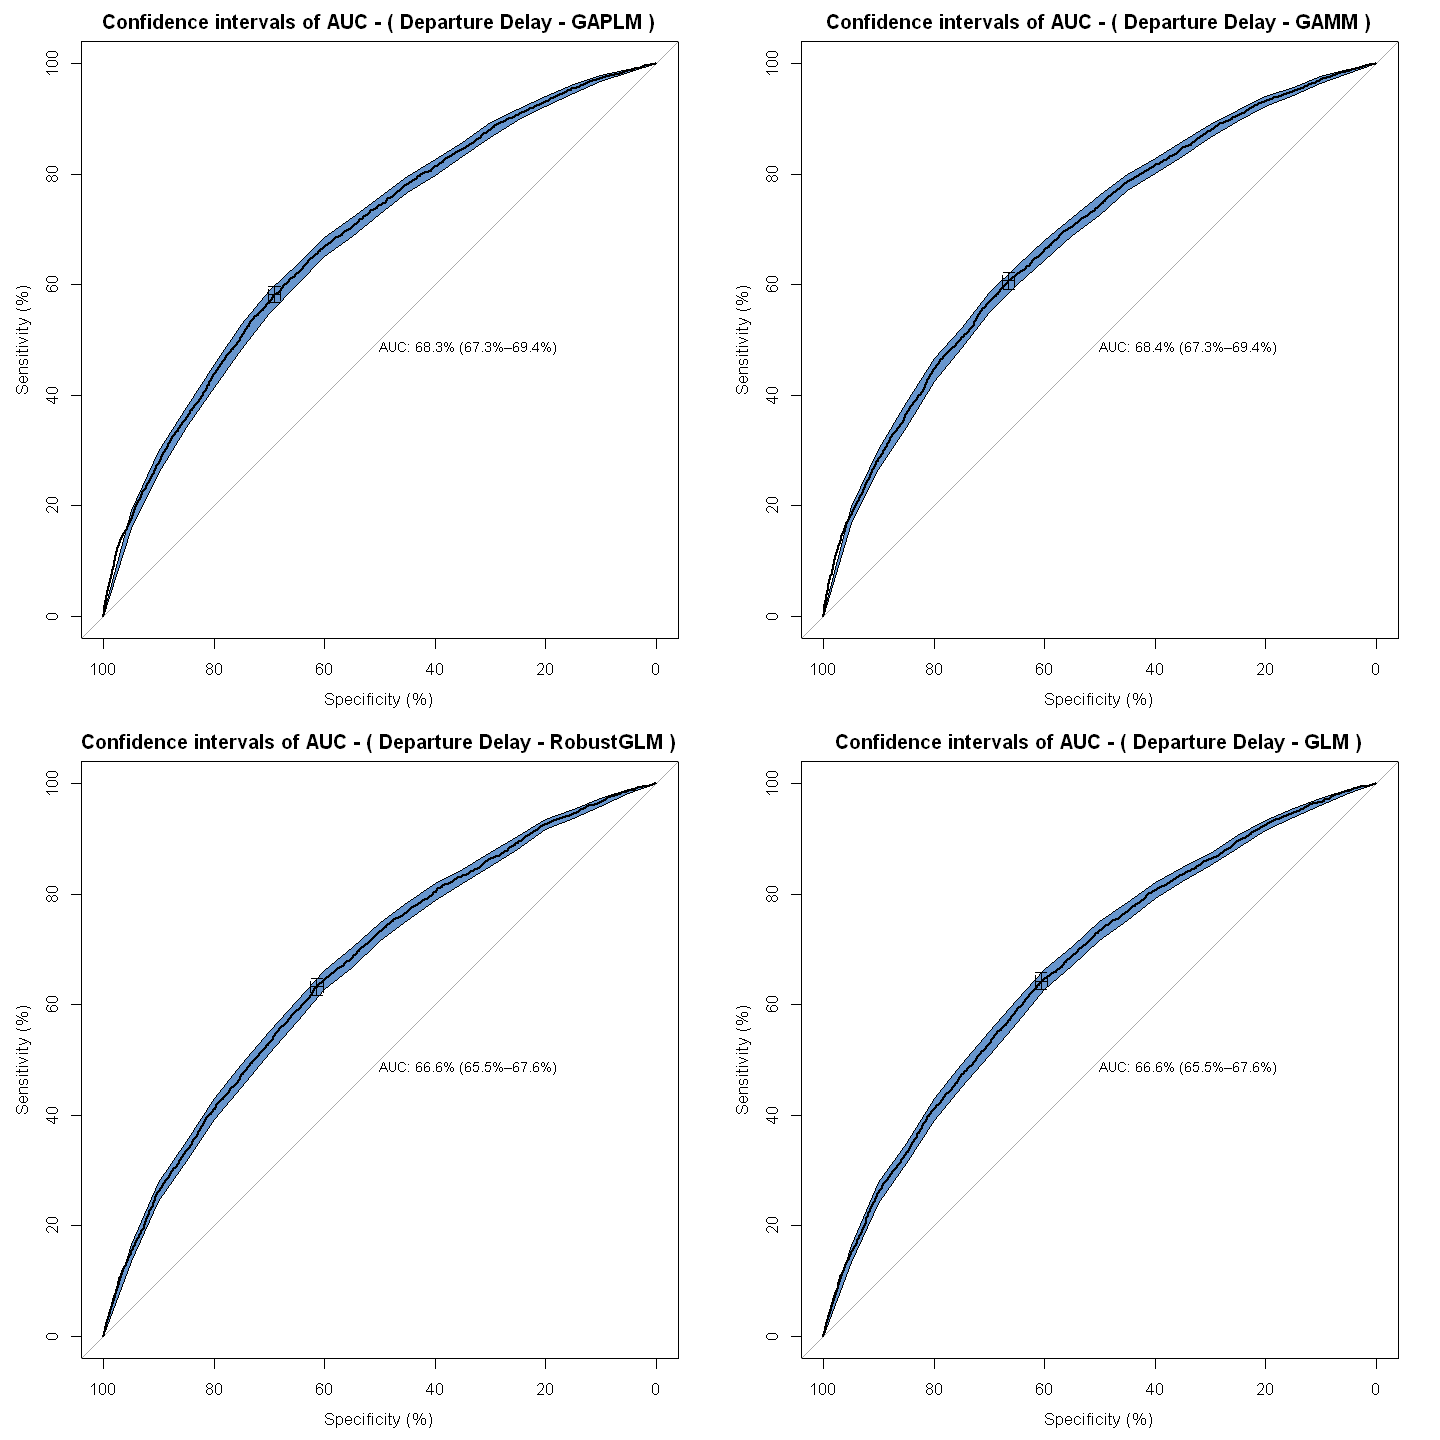

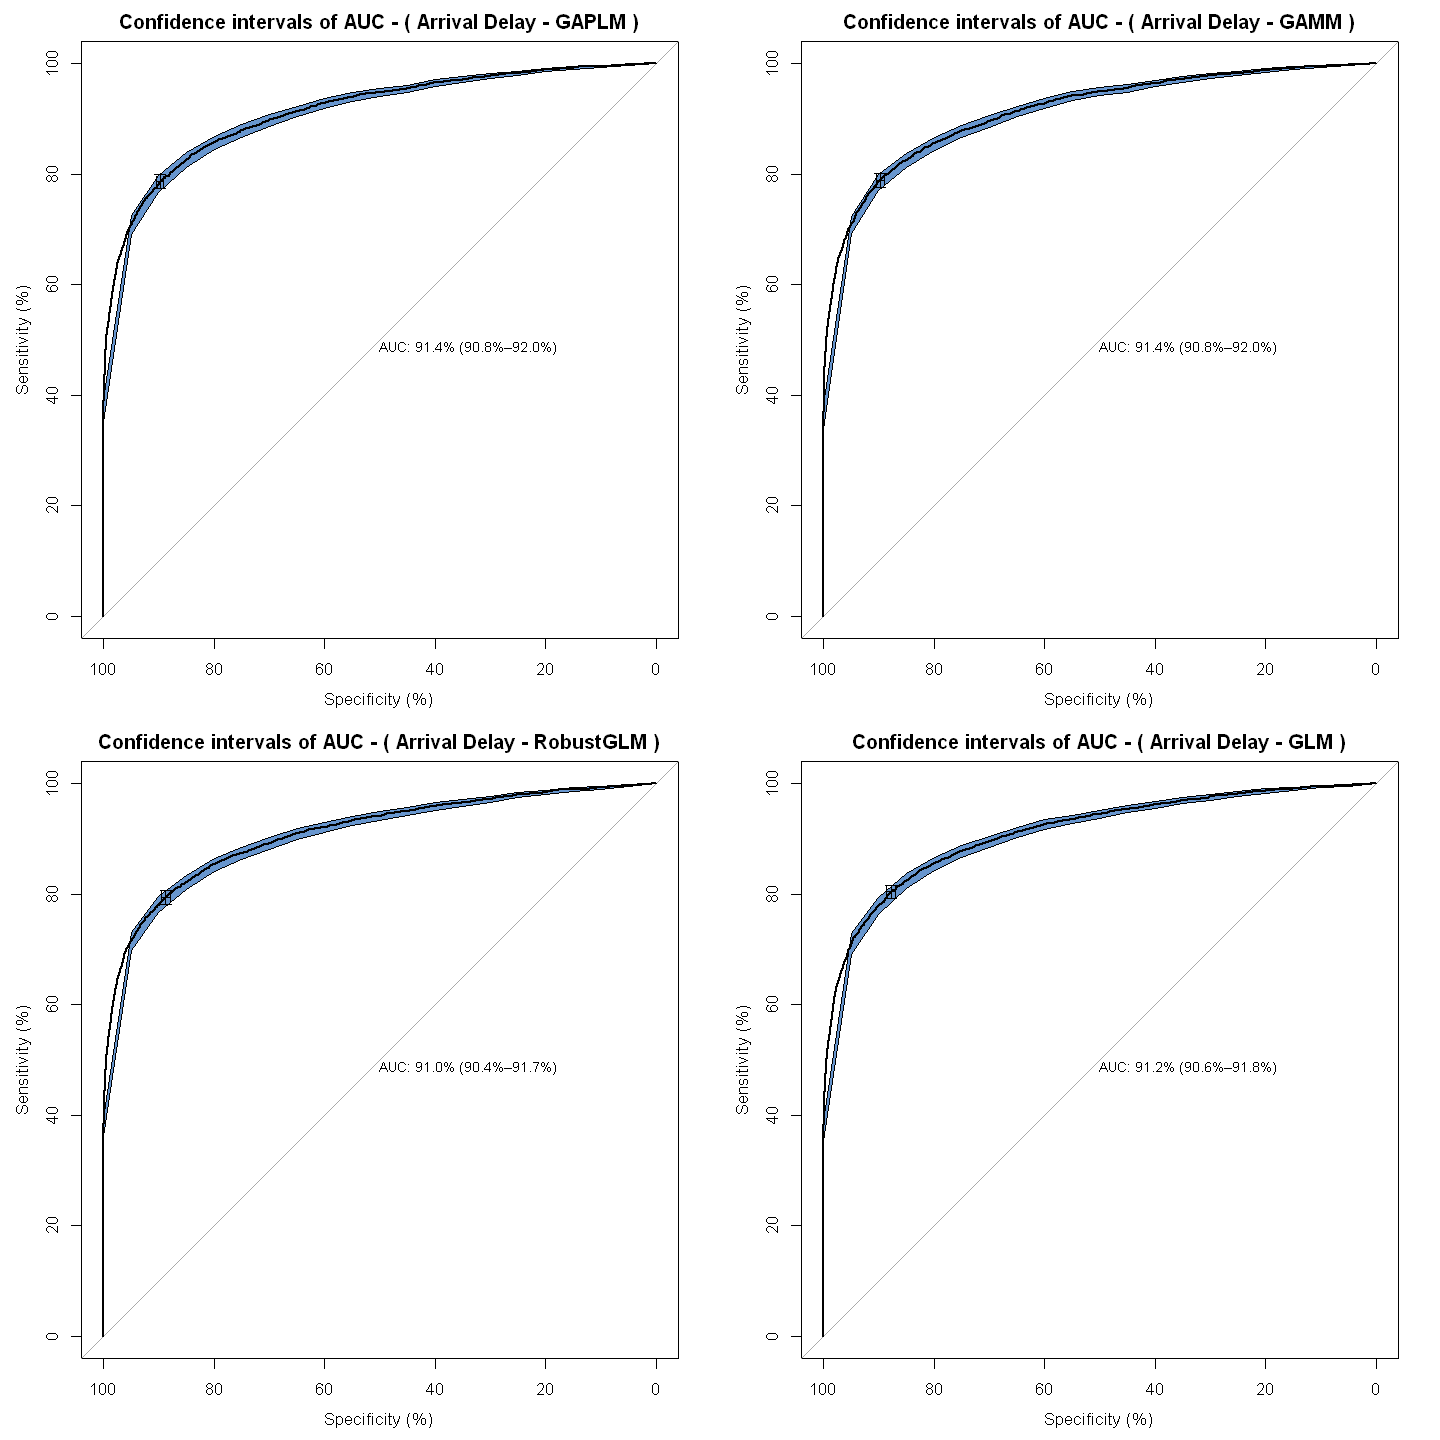

In [189]:
plot_roc_curve = function(actual_label, prediction, target){
    rocobj <- plot.roc(actual_label, prediction,
                   main = paste("Confidence intervals of AUC - (", target, ")"), 
                   percent=TRUE, ci = TRUE, print.auc = TRUE)           
    ciobj <- ci.se(rocobj, specificities = seq(0, 100, 5)) 
    plot(ciobj, type = "shape", col = "#1c61b6AA")     
    plot(ci(rocobj, of = "thresholds", thresholds = "best"))}

par(mfrow=c(2,2))
options(repr.plot.width=12, repr.plot.height=12)

plot_roc_curve(test.depart$depart_delay_ind, p_logistic_depart_1[,1], "Departure Delay - GAPLM")
plot_roc_curve(test.depart$depart_delay_ind, p_logistic_depart_2[,1], "Departure Delay - GAMM")
plot_roc_curve(test.depart$depart_delay_ind, p_logistic_depart_3[,1], "Departure Delay - RobustGLM")
plot_roc_curve(test.depart$depart_delay_ind, p_logistic_depart_4[,1], "Departure Delay - GLM")

plot_roc_curve(test.arrive$arrive_delay_ind, p_logistic_arrive_1[,1], "Arrival Delay - GAPLM")
plot_roc_curve(test.arrive$arrive_delay_ind, p_logistic_arrive_2[,1], "Arrival Delay - GAMM")
plot_roc_curve(test.arrive$arrive_delay_ind, p_logistic_arrive_3[,1], "Arrival Delay - RobustGLM")
plot_roc_curve(test.arrive$arrive_delay_ind, p_logistic_arrive_4[,1], "Arrival Delay - GLM")

In [156]:
p_gamma_depart_1 = data.frame(predict(gamma_depart_1, newdata = test.depart.delay, type = "response"))
p_gamma_depart_2 = data.frame(predict(gamma_depart_2, newdata = test.depart.delay, type = "response"))
p_gamma_depart_3 = data.frame(predict_glmrob_revised(gamma_depart_3, newdata = test.depart.delay, type = "response"))
p_gamma_depart_4 = data.frame(predict(gamma_depart_4, newdata = test.depart.delay, type = "response"))

Warning message in predict_glmrob_revised(gamma_depart_3, newdata = test.depart.delay, :
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"


In [157]:
MAE(p_gamma_depart_1[,1], test.depart.delay$DEPARTURE_DELAY)
MAE(p_gamma_depart_2[,1], test.depart.delay$DEPARTURE_DELAY)
MAE(p_gamma_depart_3[,1], test.depart.delay$DEPARTURE_DELAY)
MAE(p_gamma_depart_4[,1], test.depart.delay$DEPARTURE_DELAY)

[1] 30.43283

[1] 30.09733

[1] 29.74451

[1] 30.56953

In [158]:
p_gamma_arrive_1 = data.frame(predict(gamma_arrive_1, newdata = test.arrive.delay, type = "response"))
p_gamma_arrive_2 = data.frame(predict(gamma_arrive_2, newdata = test.arrive.delay, type = "response"))
p_gamma_arrive_3 = data.frame(predict_glmrob_revised(gamma_arrive_3, newdata = test.arrive.delay, type = "response"))
p_gamma_arrive_4 = data.frame(predict(gamma_arrive_4, newdata = test.arrive.delay, type = "response"))

Warning message in predict_glmrob_revised(gamma_arrive_3, newdata = test.arrive.delay, :
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"


In [186]:
MAE(p_gamma_arrive_1[,1], test.arrive.delay$ARRIVAL_DELAY)
MAE(p_gamma_arrive_2[,1], test.arrive.delay$ARRIVAL_DELAY)
MAE(p_gamma_arrive_3[,1], test.arrive.delay$ARRIVAL_DELAY)
MAE(p_gamma_arrive_4[,1], test.arrive.delay$ARRIVAL_DELAY)

[1] 10.59261

[1] 9.963362

[1] 28.71427

[1] 17.0004

<i><b>Analysis on non-parametric effects and subject-specific random effects:</b></i>

<ul><li><b>Departure Delay</b></li></ul>

Investigating the GAMM models, which generally performed the best for all four tasks, the likelihood ratio tests on each variable for the model on binary response of departure delay indicated a small p-value < 0.10 for most variables except the scheduled arrival minute. The partial regression plots further displayed the contributions of each variable, while some variables might be an approximately linear fit with degree of freedom close to 1.0, including the scheduled flight departure minute, daily frequency of flights in the original airport and hourly frequency of flights in the destination airport. Since the mgcv package did not separate apart the linear components and high-degree components, that was why these terms would be marked significant even it got a plot close to a linear fit. The scheduled arrival minute was flattened and confined to a small range of y-axis, therefore its effect was insignificant. 

For examples of fitted individual effects, it was observed that the probability of flights departure delays peaked at the period from afternoon after 15:00 to evening around 20:00 and during the weekends. It also increased with the frequency of scheduled flights in the origin airports. 

On the continuous Gamma response of departure delay, the daily and hourly frequency of flights specific to operating airlines and destination airports became not crucial. The partial effects of origin airports differed in daily counts (decreasing to reach minimum at 200 and then increasing gradually, df = 3.90) and hourly counts (generally decreasing with more counts, df = 1.76). The higher the crowdness within an hour at the origin airport contributed higher probability of departure delay, but the magnitudes of delay would be smaller, according to these modelling results.

The Q-Q plot of the random intercepts for airlines and airports were quite close to following a normality. Interpreting the coefficients from the random effects, airports KOA (Kona International Airport at Keahole) and HNL (Honolulu International Airport) had most negative effects on departure delays when they were at the role of starting airport of the flights. Both of them were located in Hawaii, far away from the main local territory of the United States, with less intensive traffics. Flights originated from EWR (Newark Liberty International Airport), SAV (Savannah/Hilton Head International Airport), SIT (Sitka Rocky Gutierrez Airport) had greatest positive impacts on delays. Among them, SIT was particularly located at the State of Alaska, which might be affected by weather conditions in winter season. As the destinating airports, flights heading to CLT (Charlotte Douglas International Airport) and DHN (Dothan Regional Airport) contributed the highest coefficients to departure delay, and both were located at the south-eastern states; while the opposite examples were SRQ (Sarasota-Bradenton International Airport) and SGF (Springfield-Branson National Airport). For airlines, AA (American Airlines), UA (United Air Lines), and B6 (JetBlue Airways) suffered greater possibilities of departure delay. 

<ul><li><b>Arrival Delay</b></li></ul>

The GAMM for arrival delay binary indicator had smoothing terms of more variables being insignificant, mainly the daily and hourly distributions of scheduled flights, daily and hourly counts of airline-specific scheduled flights, sheduled departure hour and minute. However, some of these variables still manifested a small linear slope of trend or variations of response values across their input ranges along x-axis from the partial plots. 

Arrival delay was more dependent on airport crowdness, it was ordinary to see the modelled log odds ratio of arrival delay increased with daily and hour counts of flights in the destination airports, yet at the meantime also observed an inverse trend with the counts of flights in origin airports. Most arrival delays occurred on Thursday and Friday instead of weekends. Taxi-out durations of waiting time between leaving the gate and actually taking off increased the risk of delays. The increasing slope of travelling distance and decreasing slope of scheduled time of trip basically cancelled out the partial effects of each other, and this might be due to the high multi-collinearity between the two variables. 

For the random effects, flights starting from CLL (Easterwood Airport), HSV (Huntsville International Airport), SWF (Stewart International Airport), PVD (Theodore Francis Green State Airport) were likely to be eventually delayed when arriving at the destination. The flights from the two Hawaii airports were likely to be on-time not only upon departing but also upon arriving. PPG (Pago Pago International Airport) was quite a special case as being a destinating airport accounting for high odds on arrival delay, this could be explained by its location at American Samoa, an island on the South Pacific Ocean, even farther than Hawaii. ASE (Aspen-Pitkin County Airport) and MKE (General Mitchell International Airport) were the other two destinating airports common in late arrivals. Opposite promising examples included LAS (McCarran International Airport), SBP (San Luis Obispo County Regional Airport), SLC (Salt Lake City International Airport), etc. These three were all located at the western part of the America.

For the airline performances, although the three airlines AA (American Airlines), UA (United Air Lines), and B6 (JetBlue Airways) were mentioned with highest odds on departure delays, in fact their behaviours on arrival delays were entirely different that B6 (JetBlue Airways) had the most negative coefficient on arrival delays, while AA (American Airlines) were also among the airlines with least reliable performances in terms of on-time arrivals. Flights operated by F9 (Frontier Airlines) and HA (Hawaiian Airlines) also had relatively high odds ratio on arrival delays.

In [168]:
summary(logistic_depart_2)


Family: binomial 
Link function: logit 

Formula:
depart_delay_ind ~ s(MONTH, bs = "cr") + s(DAY, bs = "cr") + 
    s(DAY_OF_WEEK, k = 7, bs = "cr") + s(day_of_year, bs = "cr") + 
    s(sch_hour_of_year, bs = "cr") + s(day.dist.all, bs = "cr") + 
    s(hour.dist.all, bs = "cr") + s(daily_count_airline_specific, 
    bs = "cr") + s(daily_count_origin_specific, bs = "cr") + 
    s(daily_count_destination_specific, bs = "cr") + s(hourly_count_airline_specific, 
    bs = "cr") + s(hourly_count_origin_specific, bs = "cr") + 
    s(hourly_count_destination_specific, bs = "cr") + s(DISTANCE, 
    bs = "cr") + s(SCHEDULED_TIME, bs = "cr") + s(sch_depart_hour, 
    bs = "cr") + s(sch_depart_min, bs = "cr") + s(sch_arrive_hour, 
    bs = "cr") + s(sch_arrive_min, bs = "cr") + s(AIRLINE, bs = "re") + 
    s(ORIGIN_AIRPORT, bs = "re") + s(DESTINATION_AIRPORT, bs = "re")

Parametric coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -0.6828     0.1108   -6.16 7.28e-10 

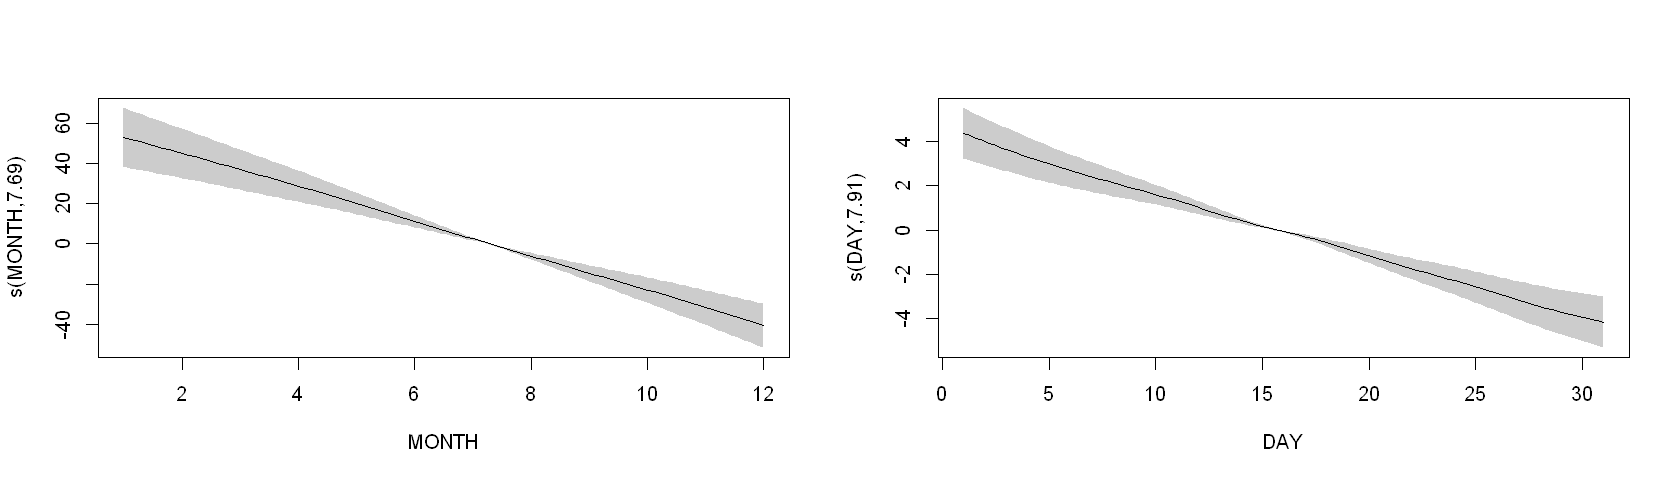

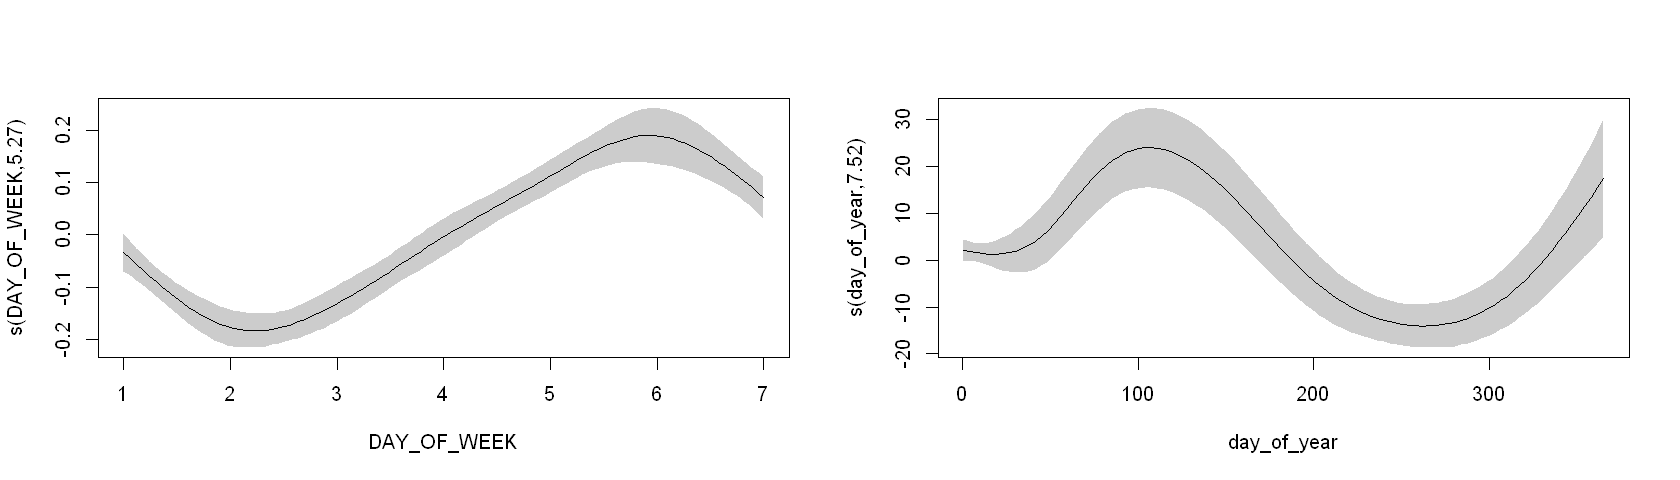

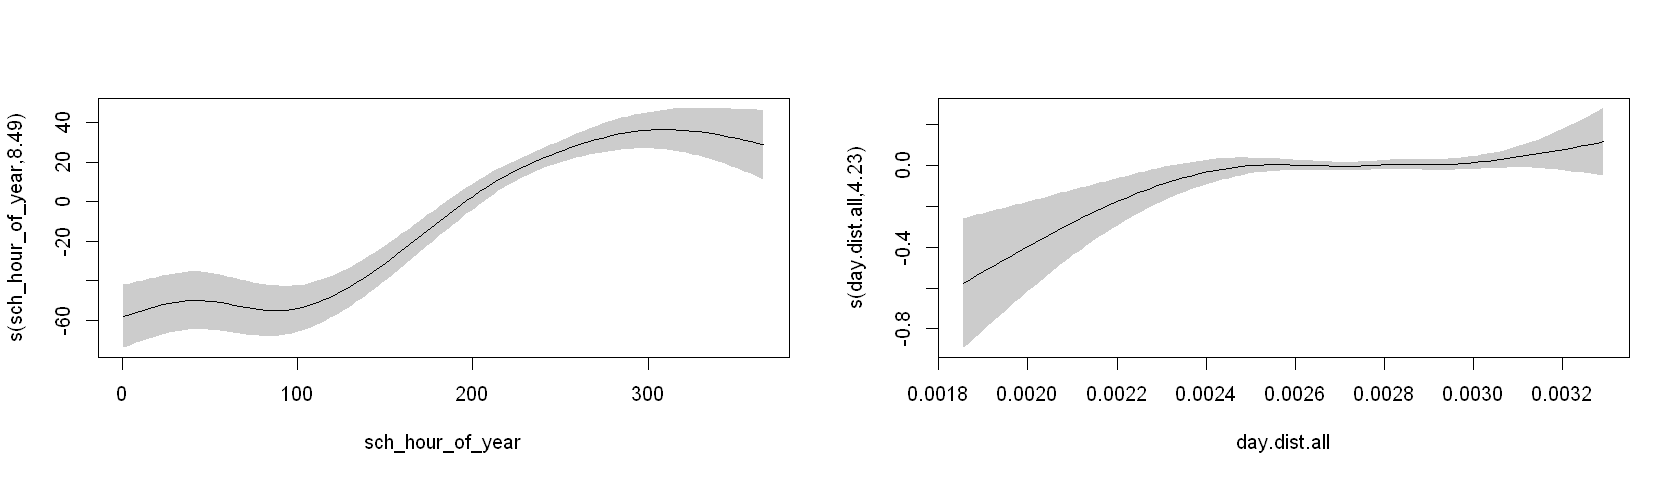

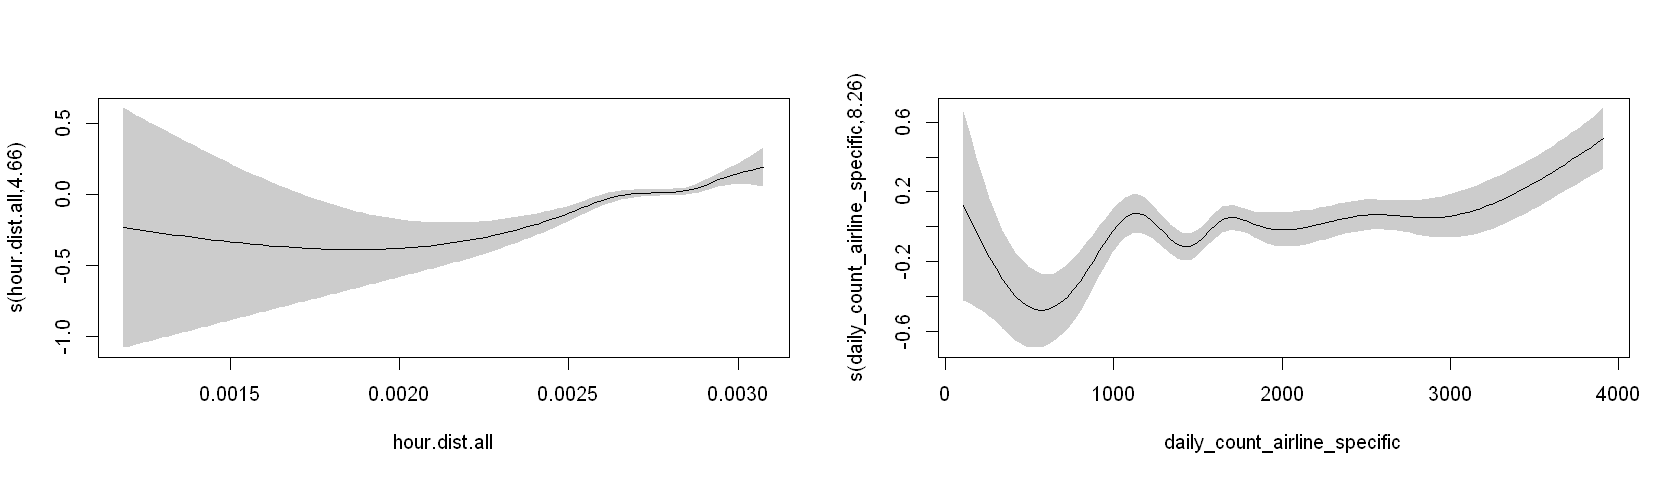

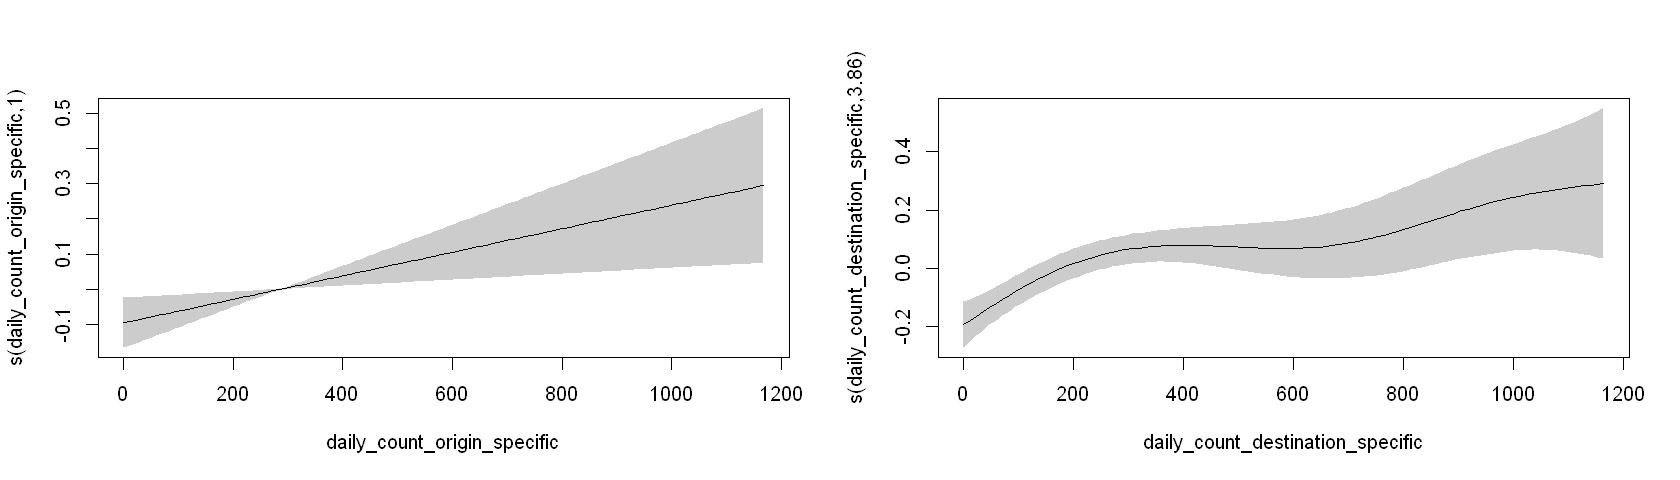

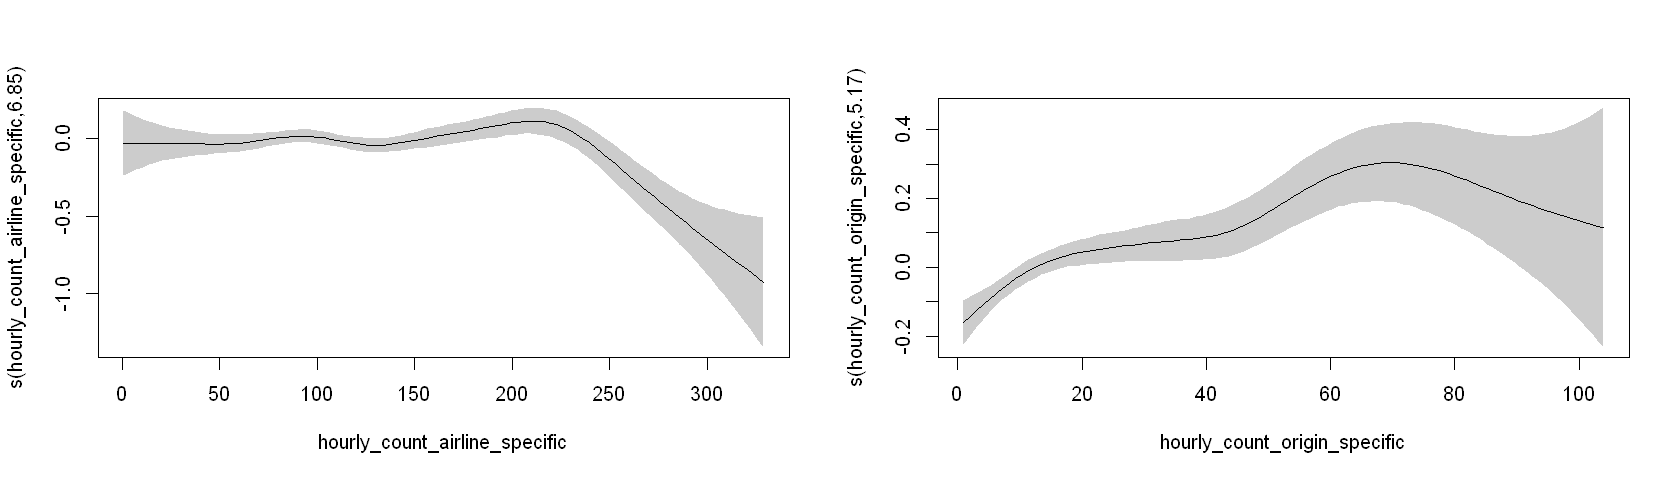

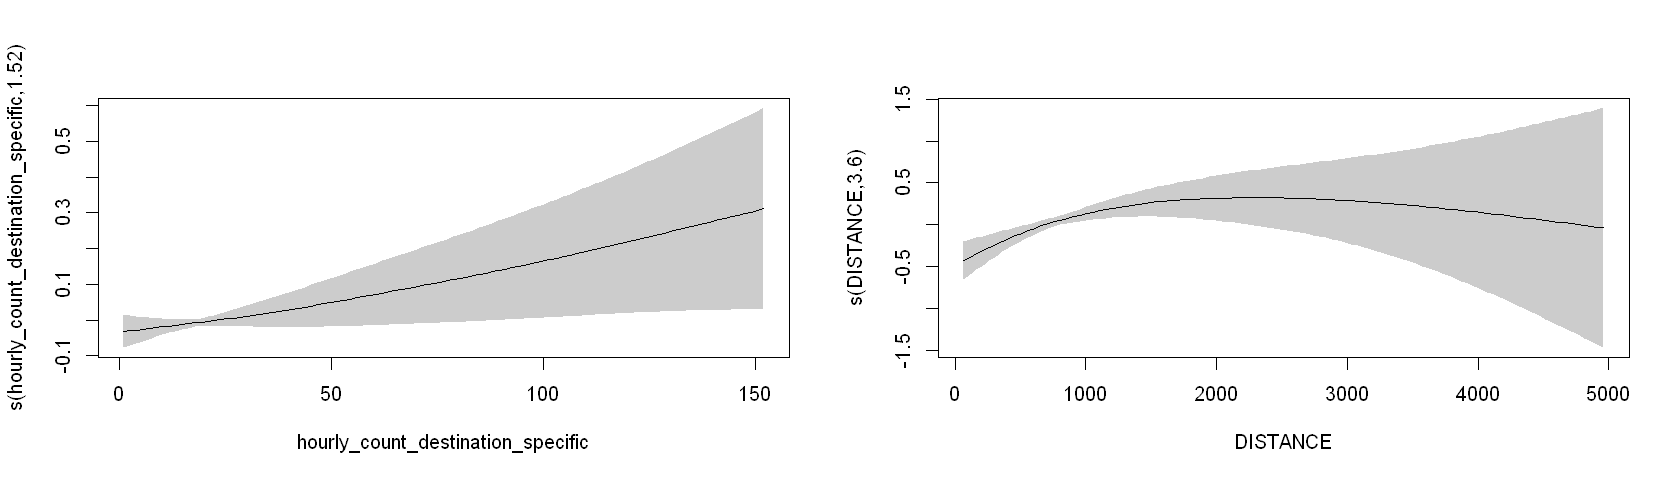

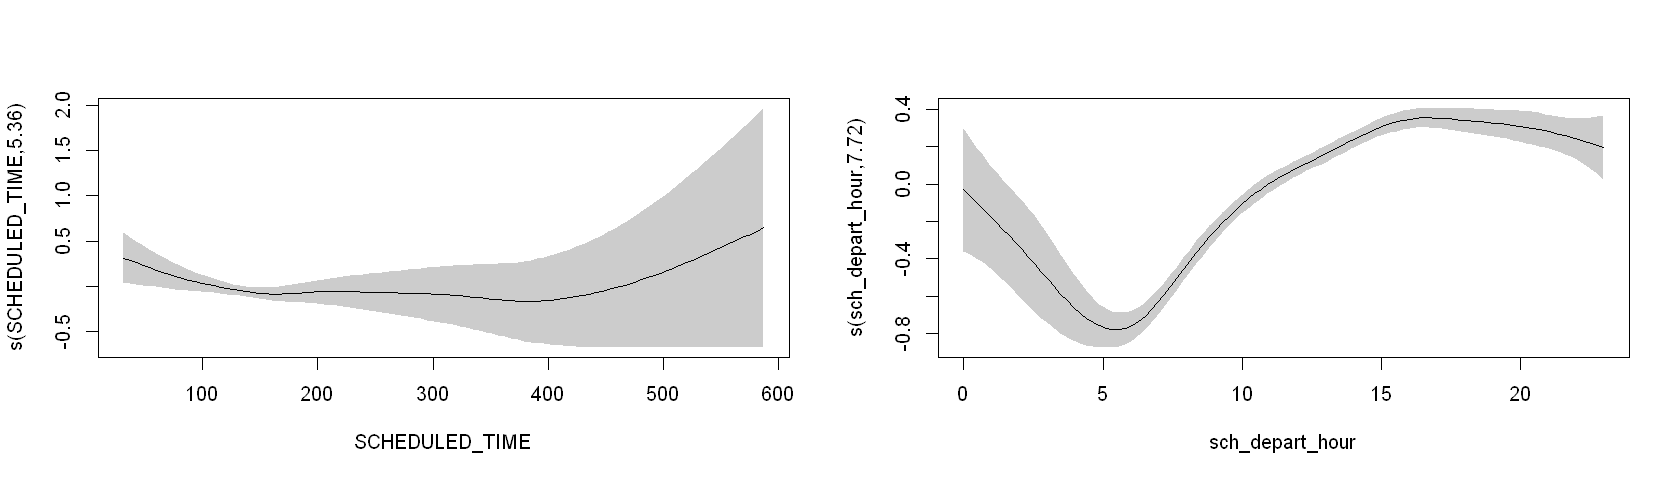

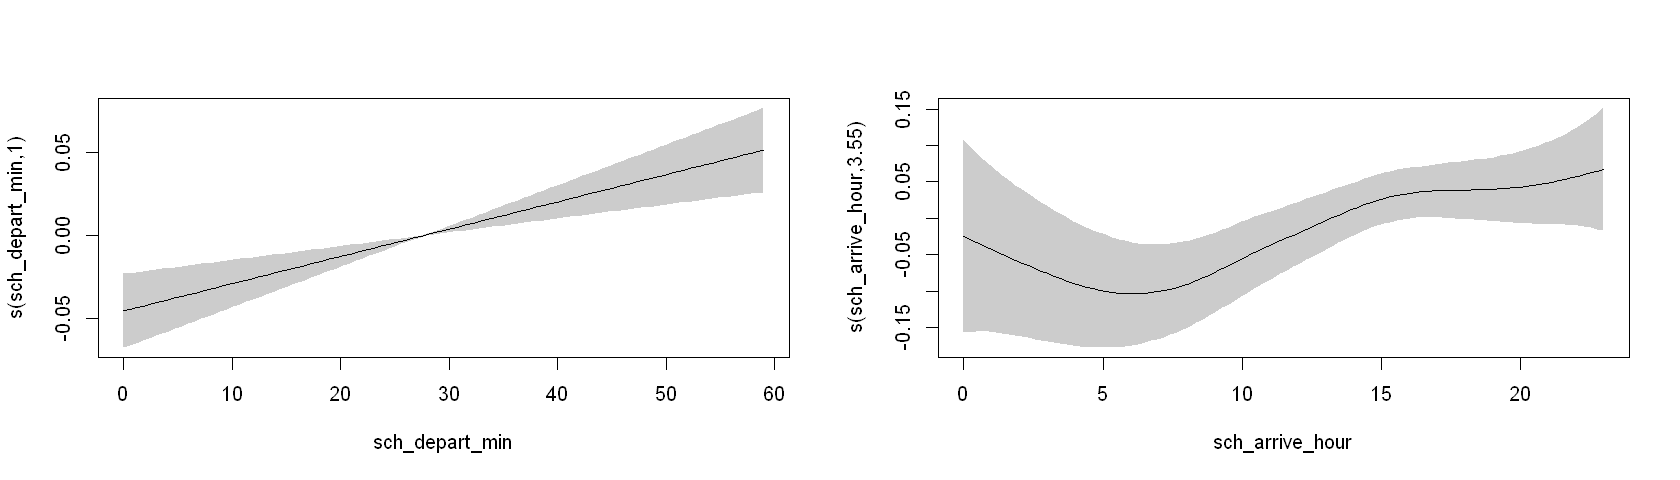

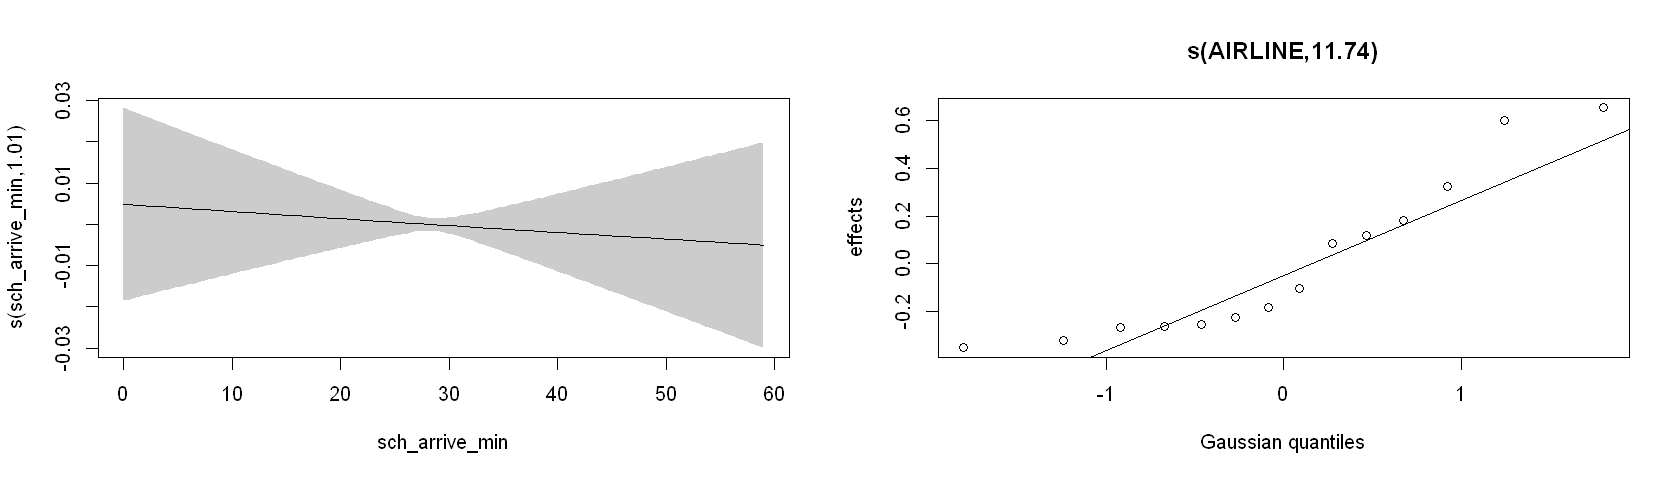

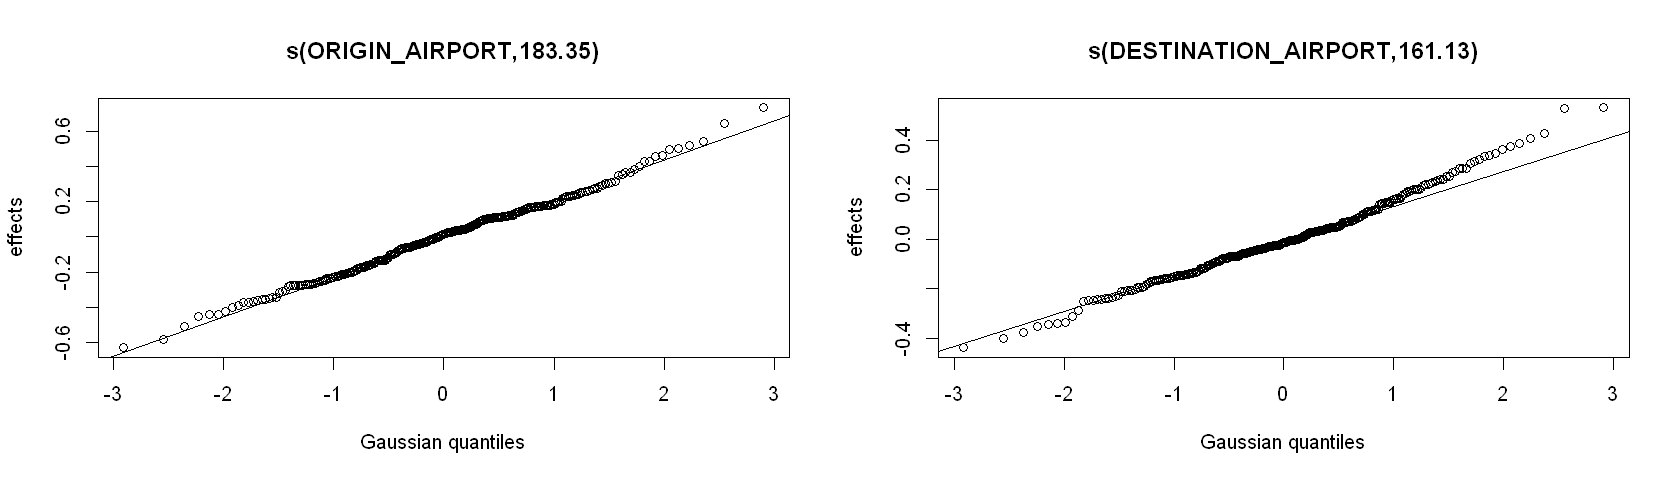

In [177]:
par(mfrow=c(1,2))
options(repr.plot.width=14, repr.plot.height=4)
plot(logistic_depart_2, se = TRUE, shade = TRUE, scale=0)

In [170]:
summary(logistic_arrive_2)


Family: binomial 
Link function: logit 

Formula:
arrive_delay_ind ~ s(MONTH, bs = "cr") + s(DAY, bs = "cr") + 
    s(DAY_OF_WEEK, k = 7, bs = "cr") + s(day_of_year, bs = "cr") + 
    s(sch_hour_of_year, bs = "cr") + s(day.dist.all, bs = "cr") + 
    s(hour.dist.all, bs = "cr") + s(daily_count_airline_specific, 
    bs = "cr") + s(daily_count_origin_specific, bs = "cr") + 
    s(daily_count_destination_specific, bs = "cr") + s(hourly_count_airline_specific, 
    bs = "cr") + s(hourly_count_origin_specific, bs = "cr") + 
    s(hourly_count_destination_specific, bs = "cr") + s(DISTANCE, 
    bs = "cr") + s(SCHEDULED_TIME, bs = "cr") + s(DEPARTURE_DELAY, 
    bs = "cr") + s(TAXI_OUT, bs = "cr") + s(sch_depart_hour, 
    bs = "cr") + s(sch_depart_min, bs = "cr") + s(sch_arrive_hour, 
    bs = "cr") + s(sch_arrive_min, bs = "cr") + s(AIRLINE, bs = "re") + 
    s(ORIGIN_AIRPORT, bs = "re") + s(DESTINATION_AIRPORT, bs = "re")

Parametric coefficients:
            Estimate Std. Error z value 

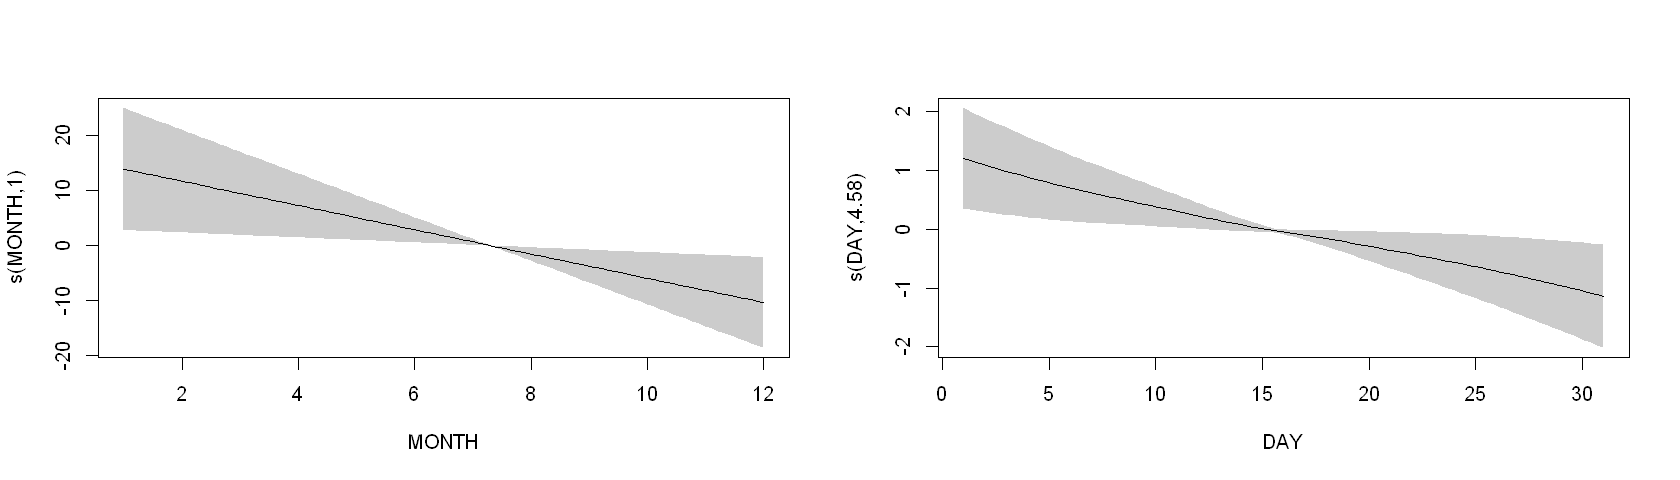

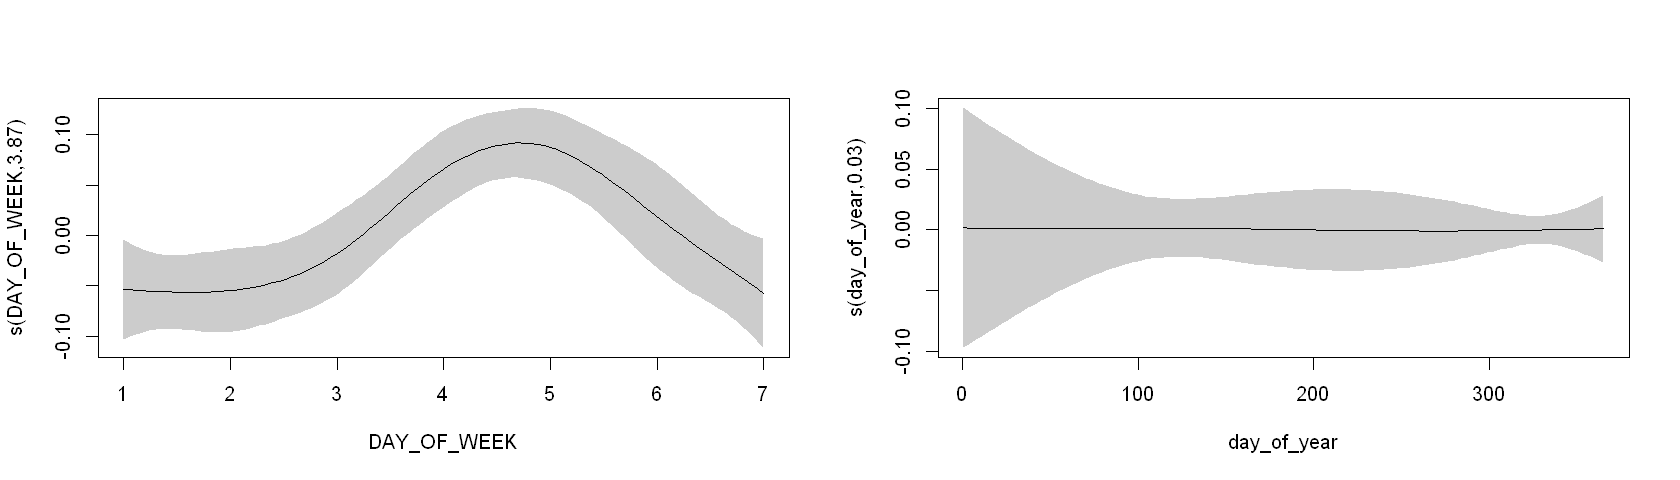

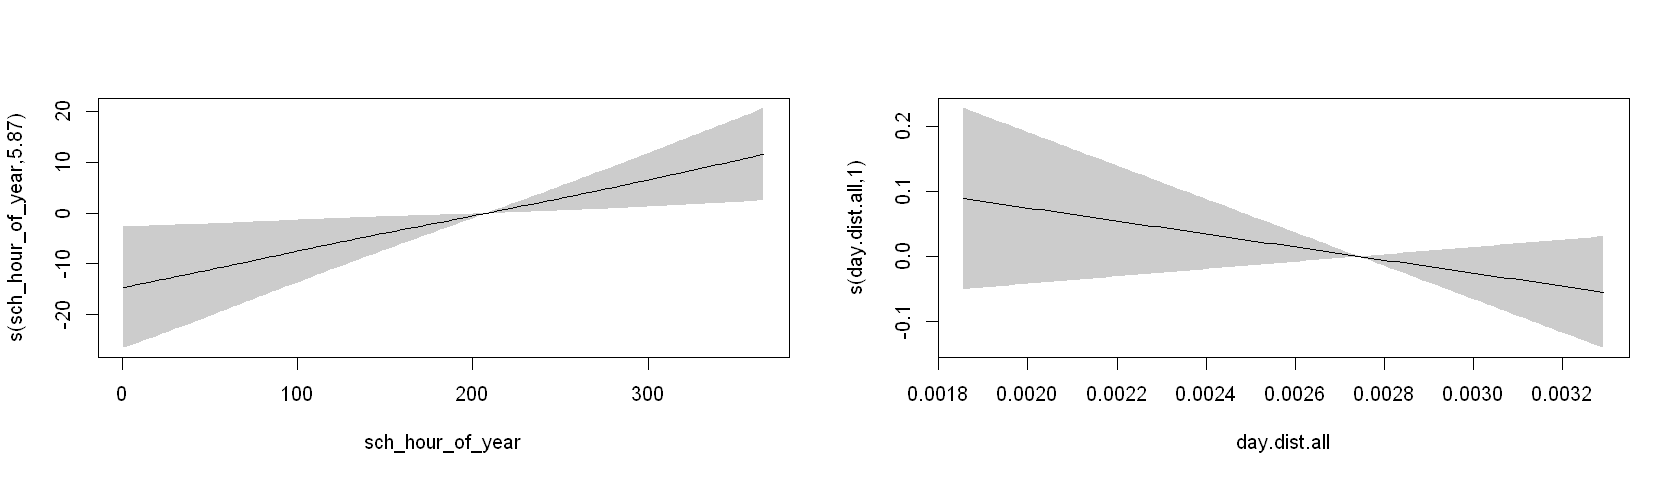

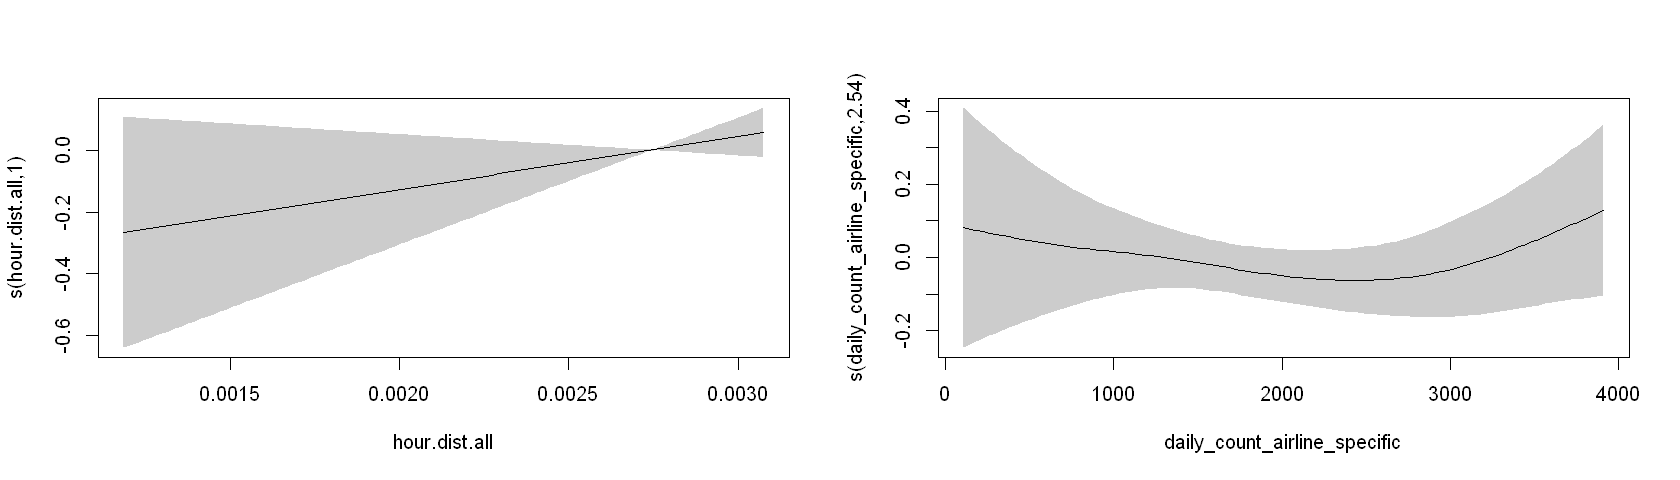

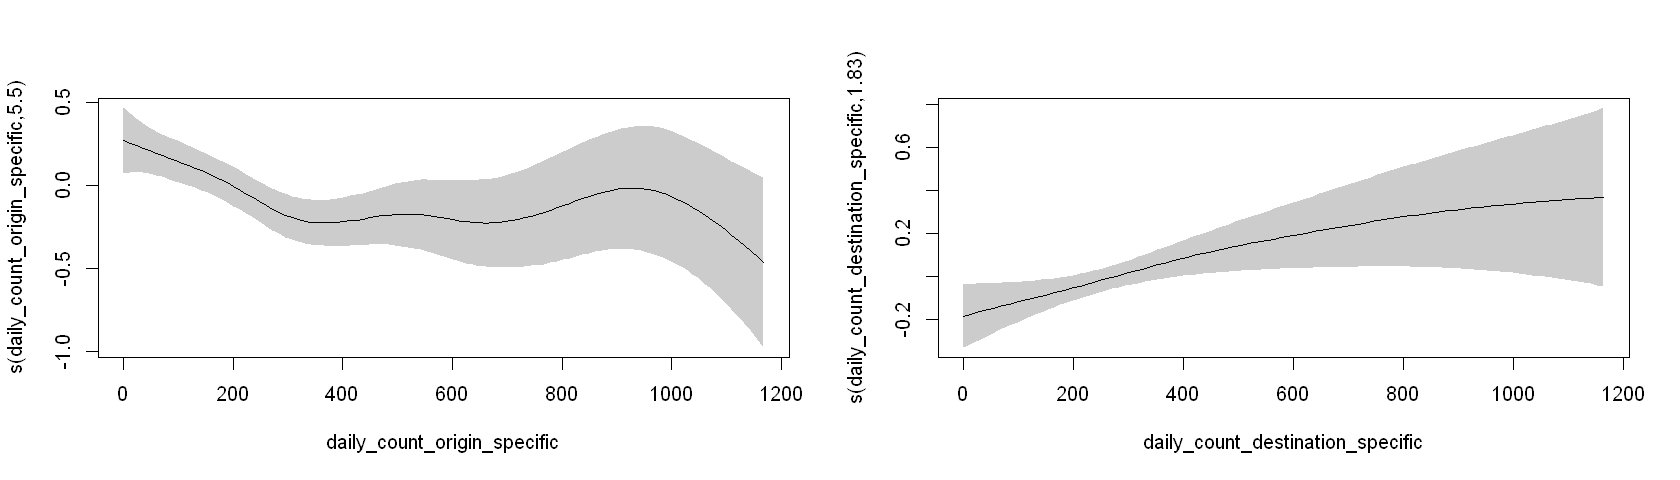

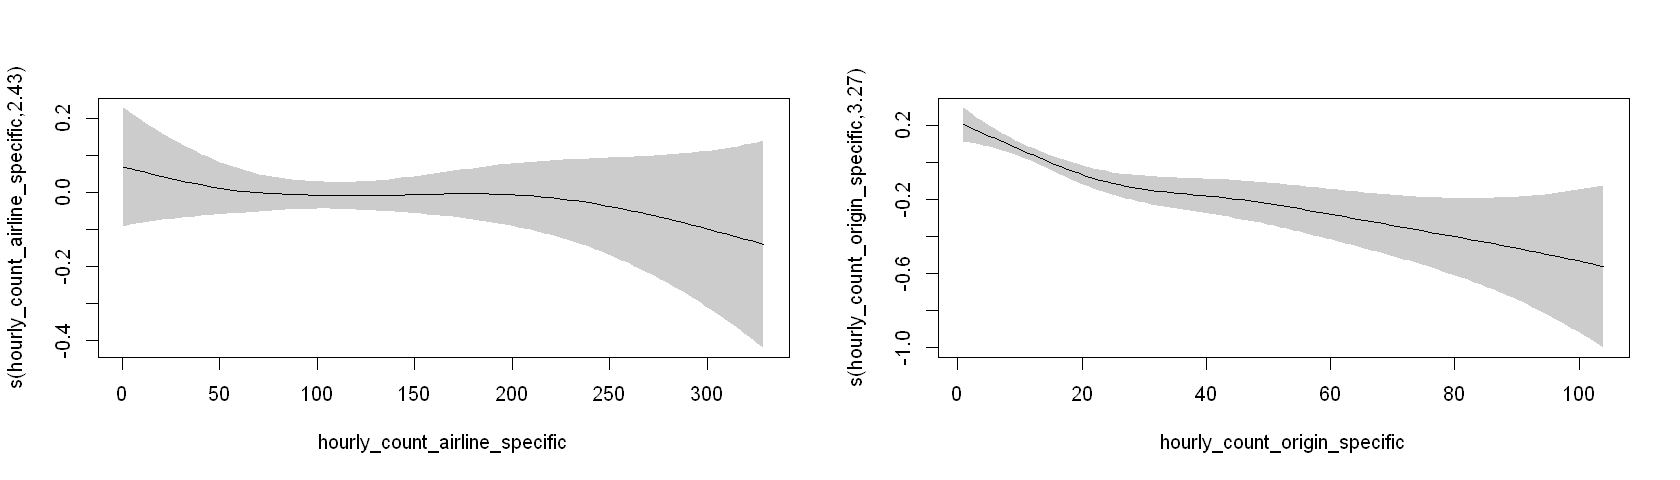

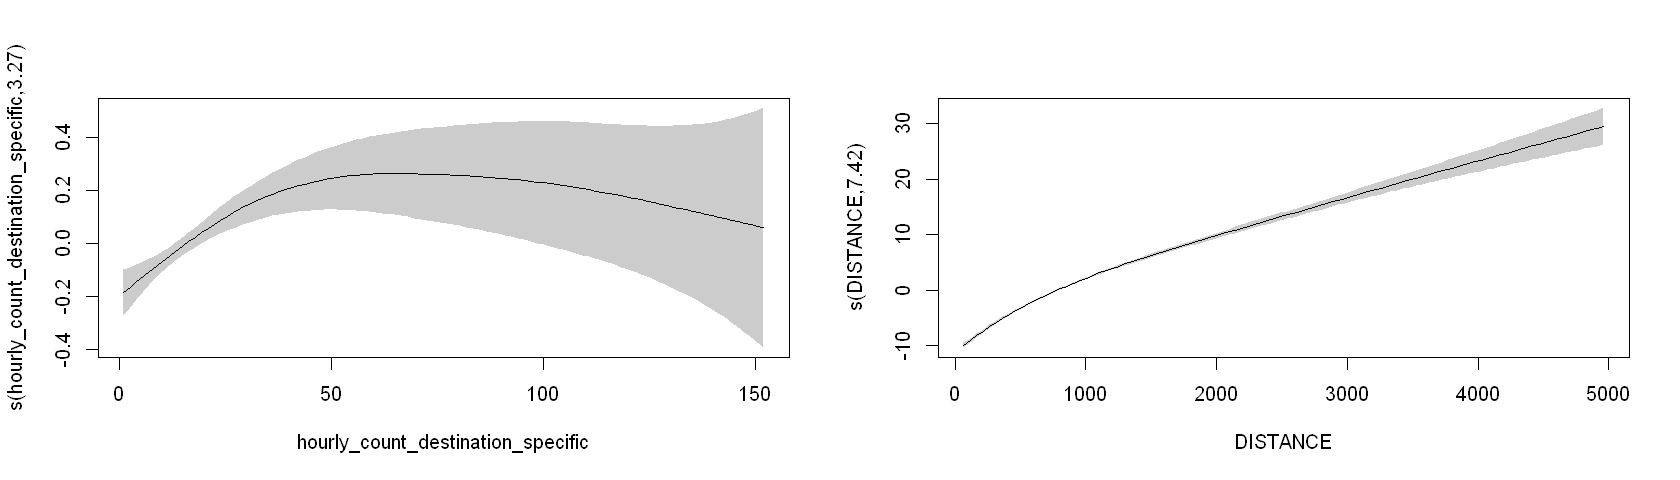

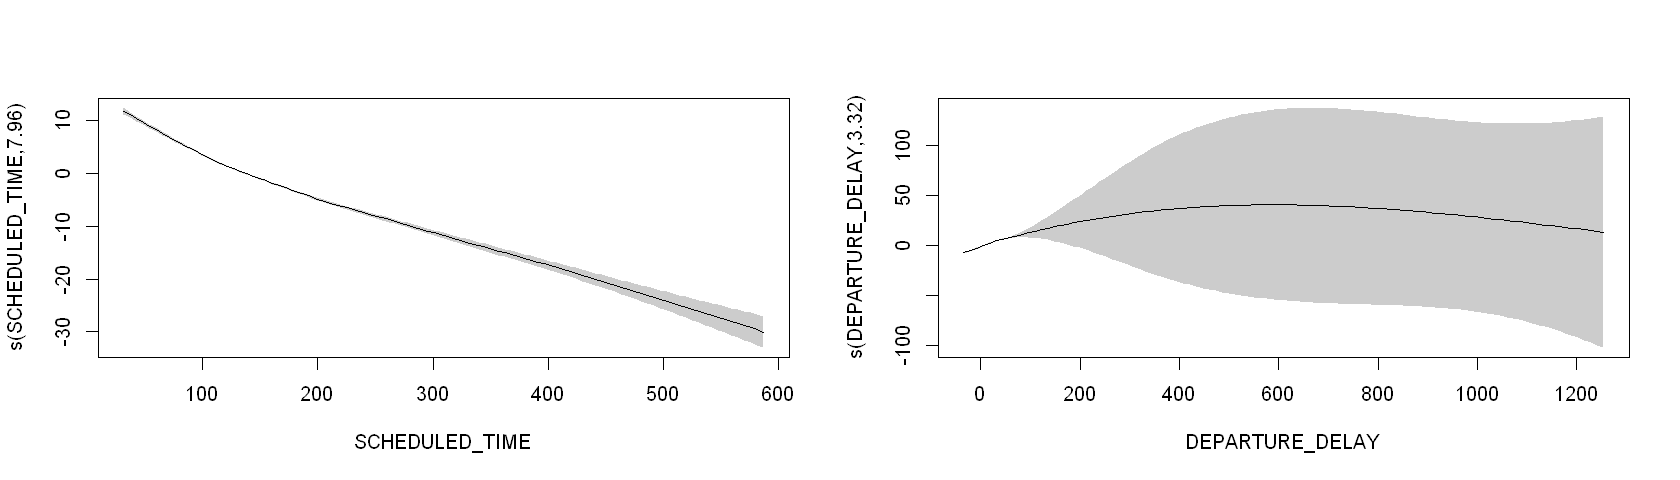

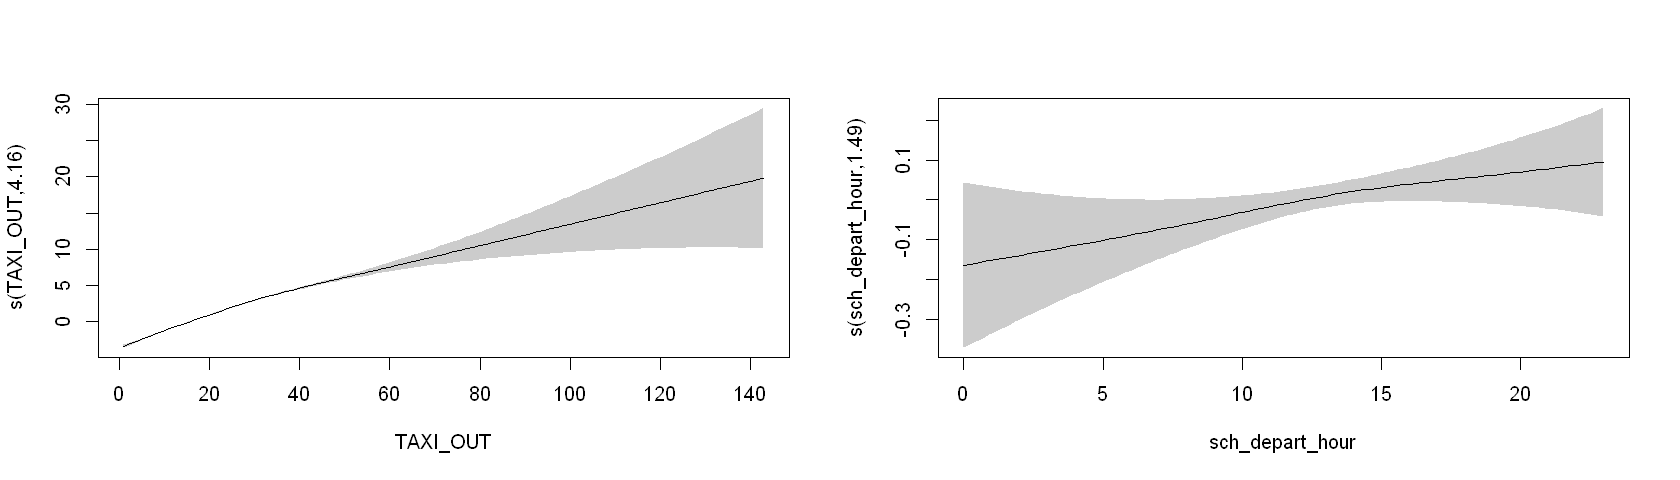

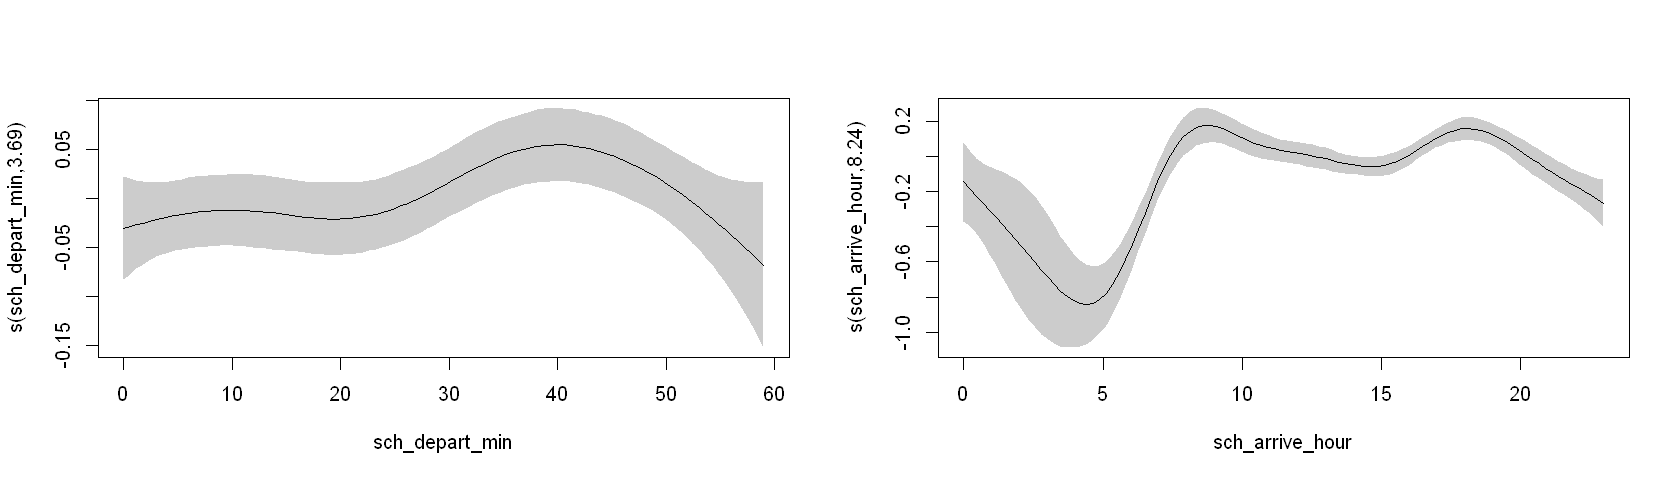

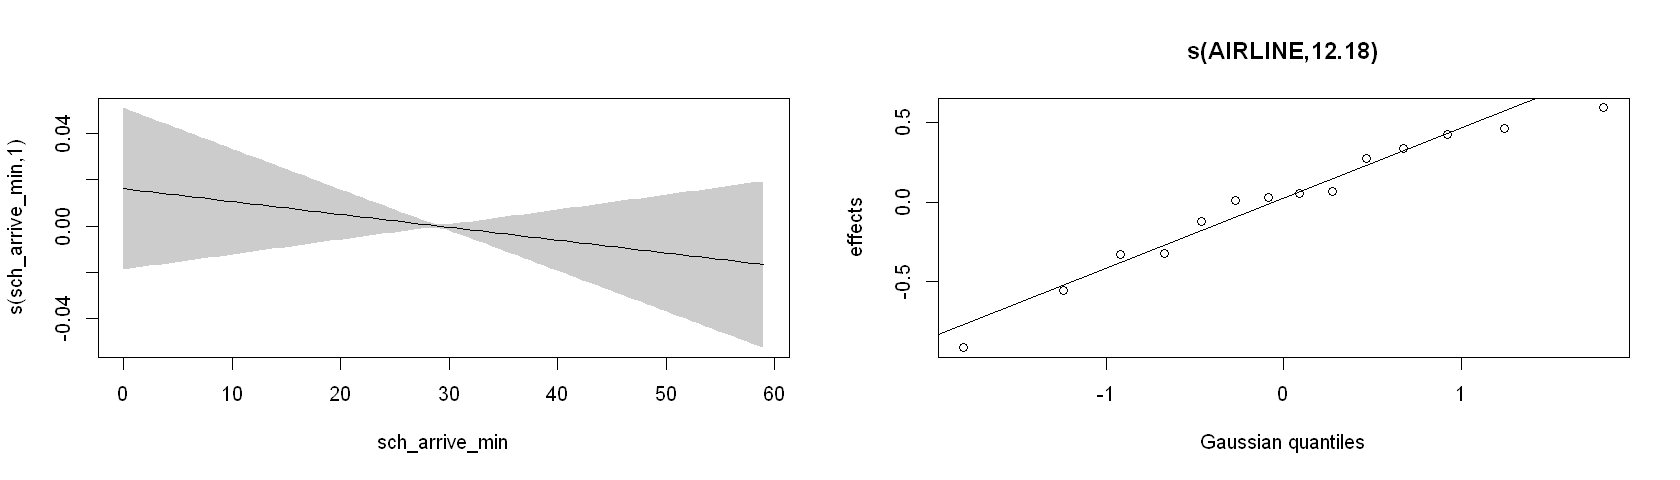

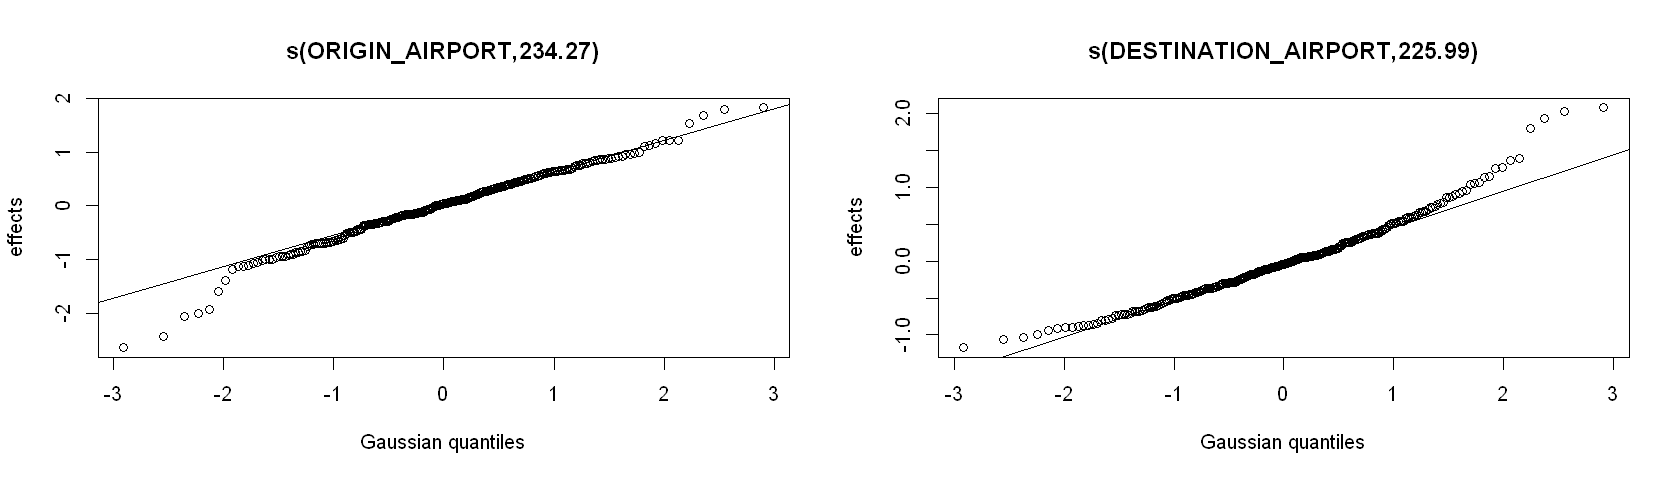

In [176]:
par(mfrow=c(1,2))
options(repr.plot.width=14, repr.plot.height=4)
plot(logistic_arrive_2, se = TRUE, shade = TRUE, scale=0)

In [181]:
summary(gamma_depart_2)


Family: Gamma 
Link function: log 

Formula:
DEPARTURE_DELAY ~ s(MONTH, bs = "cr") + s(DAY, bs = "cr") + s(DAY_OF_WEEK, 
    k = 7, bs = "cr") + s(day_of_year, bs = "cr") + s(sch_hour_of_year, 
    bs = "cr") + s(day.dist.all, bs = "cr") + s(hour.dist.all, 
    bs = "cr") + s(daily_count_airline_specific, bs = "cr") + 
    s(daily_count_origin_specific, bs = "cr") + s(daily_count_destination_specific, 
    bs = "cr") + s(hourly_count_airline_specific, bs = "cr") + 
    s(hourly_count_origin_specific, bs = "cr") + s(hourly_count_destination_specific, 
    bs = "cr") + s(DISTANCE, bs = "cr") + s(SCHEDULED_TIME, bs = "cr") + 
    s(sch_depart_hour, bs = "cr") + s(sch_depart_min, bs = "cr") + 
    s(sch_arrive_hour, bs = "cr") + s(sch_arrive_min, bs = "cr") + 
    s(AIRLINE, bs = "re") + s(ORIGIN_AIRPORT, bs = "re") + s(DESTINATION_AIRPORT, 
    bs = "re")

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.39869    0.05368   63.32   <2e-16 ***
--

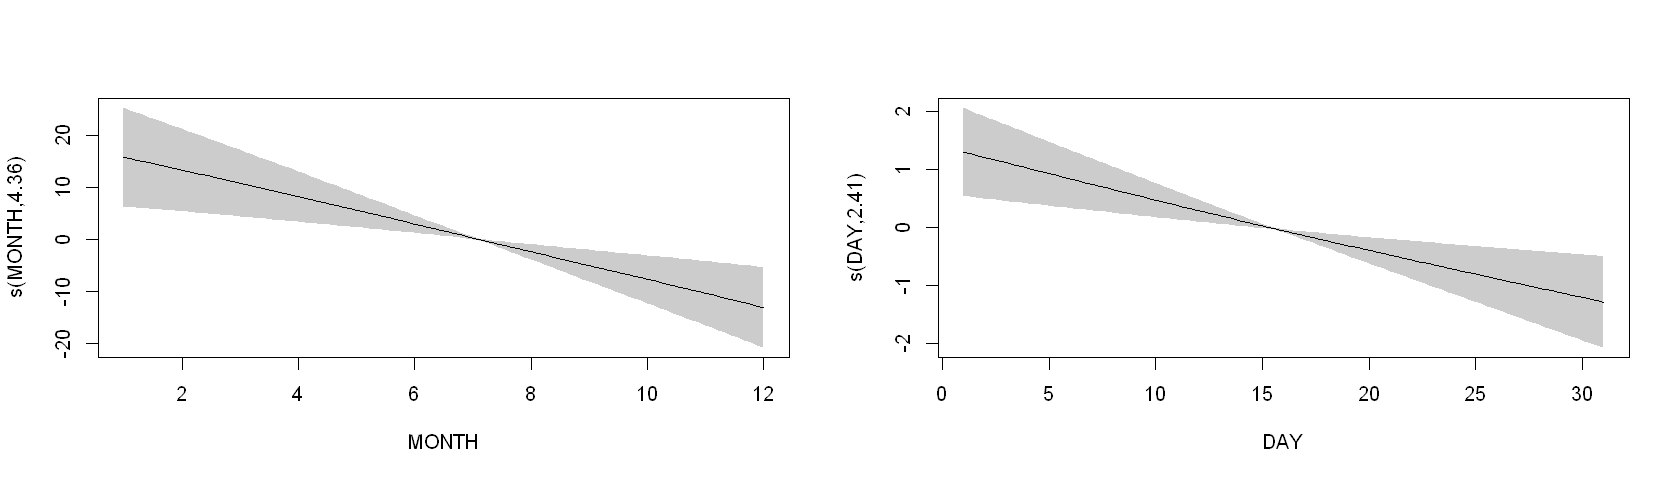

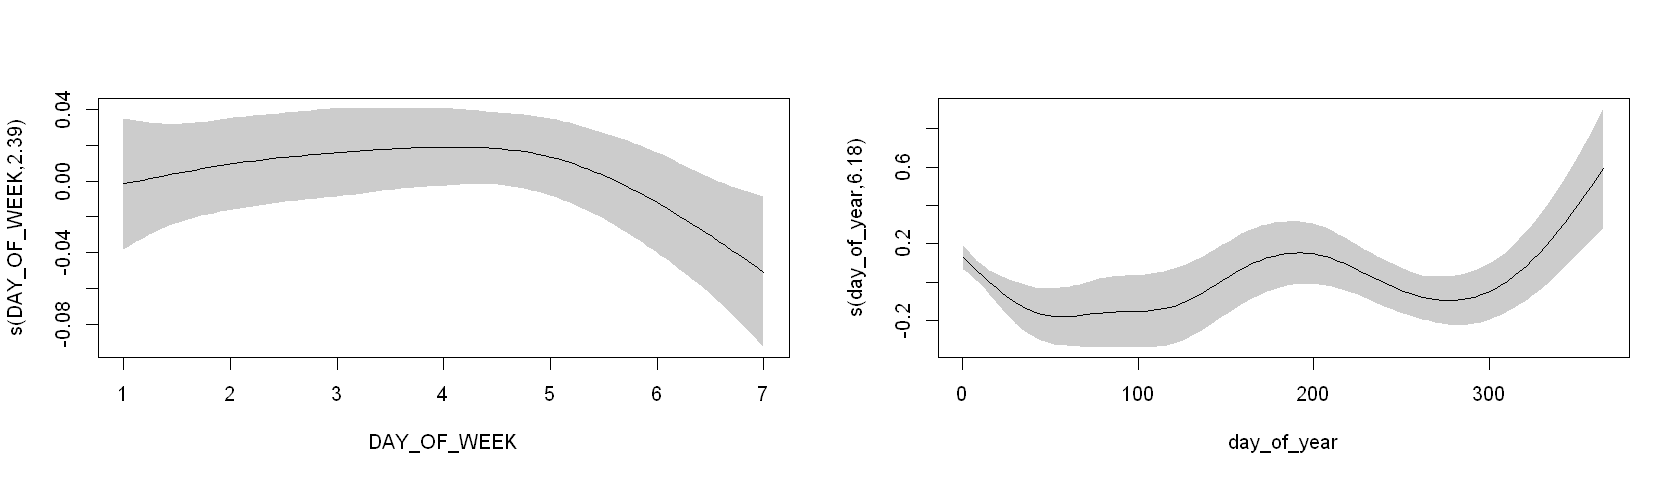

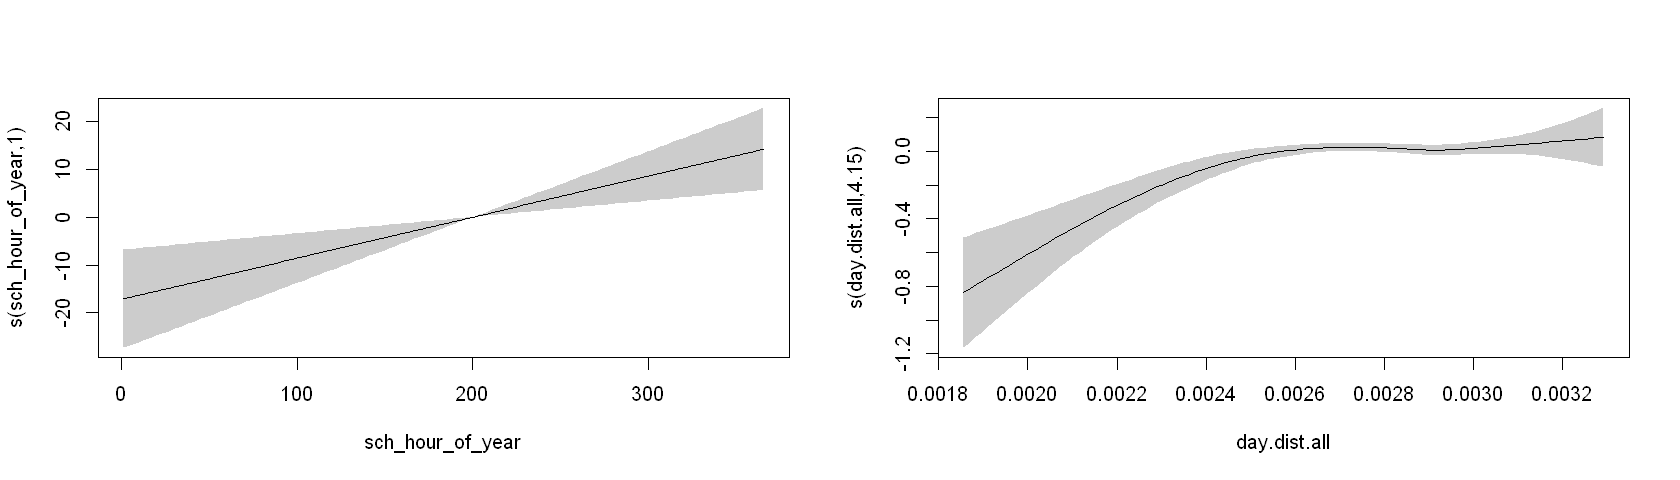

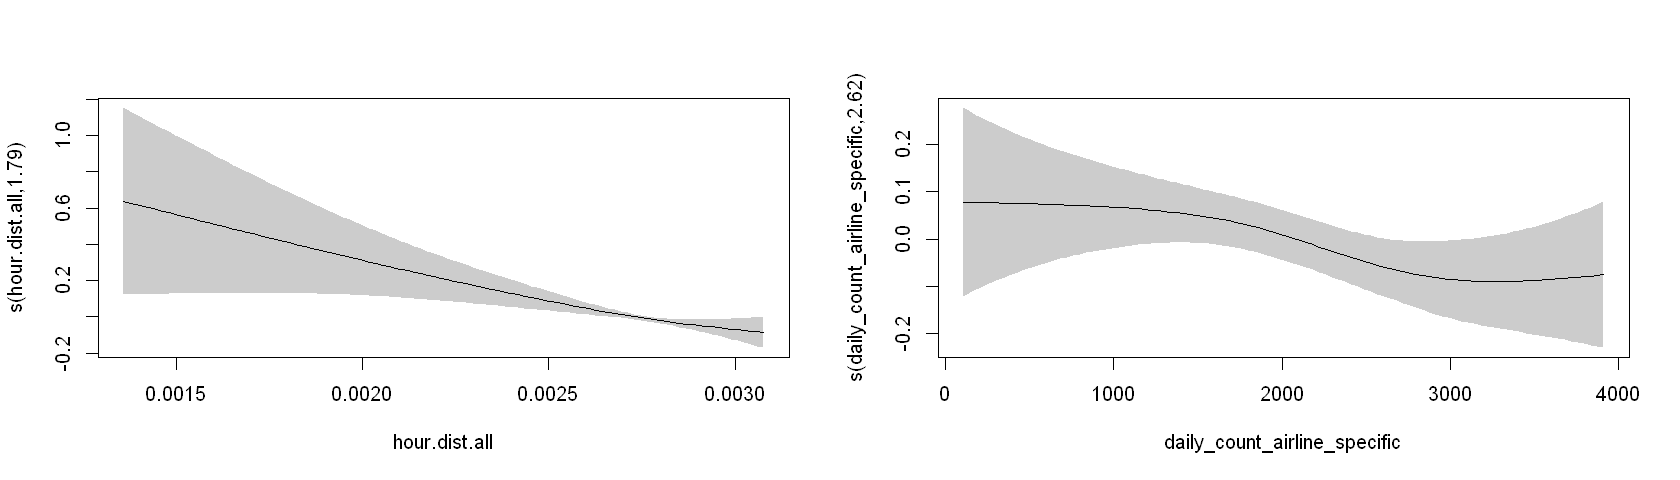

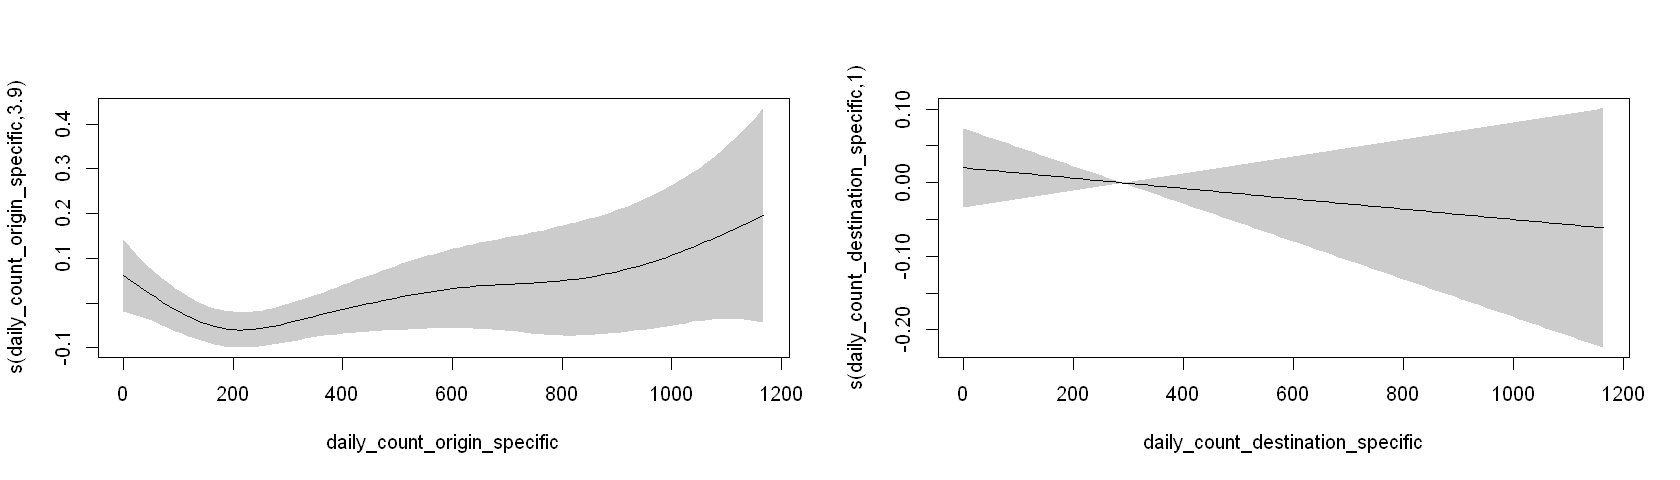

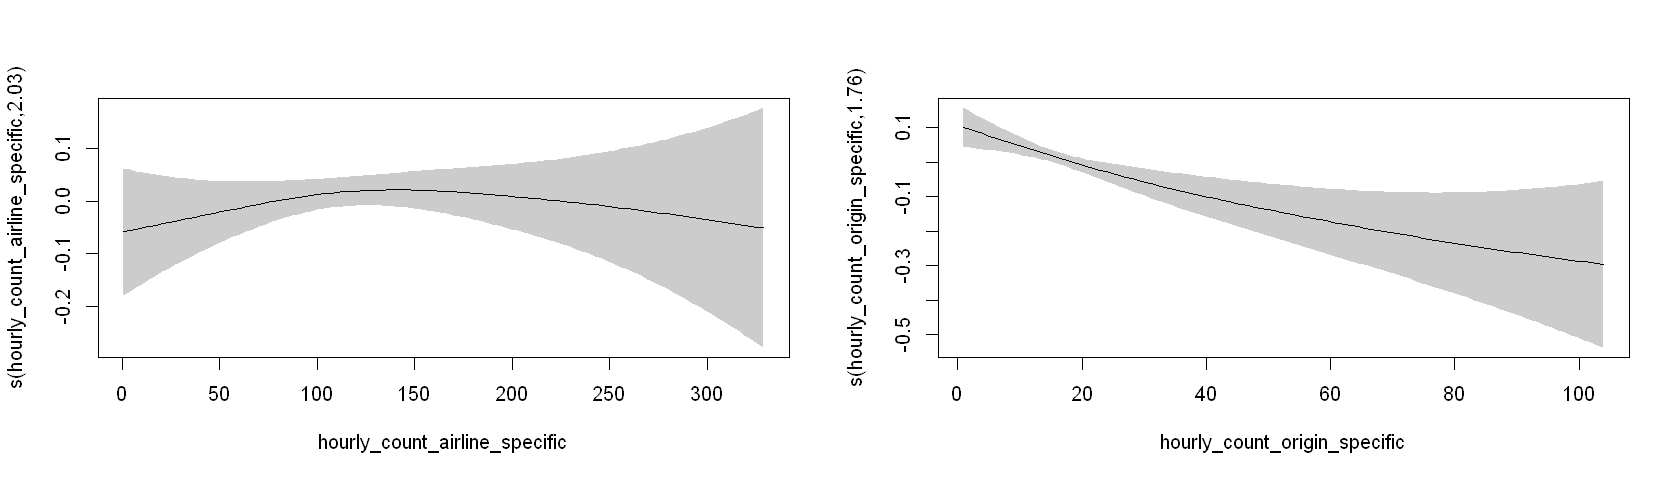

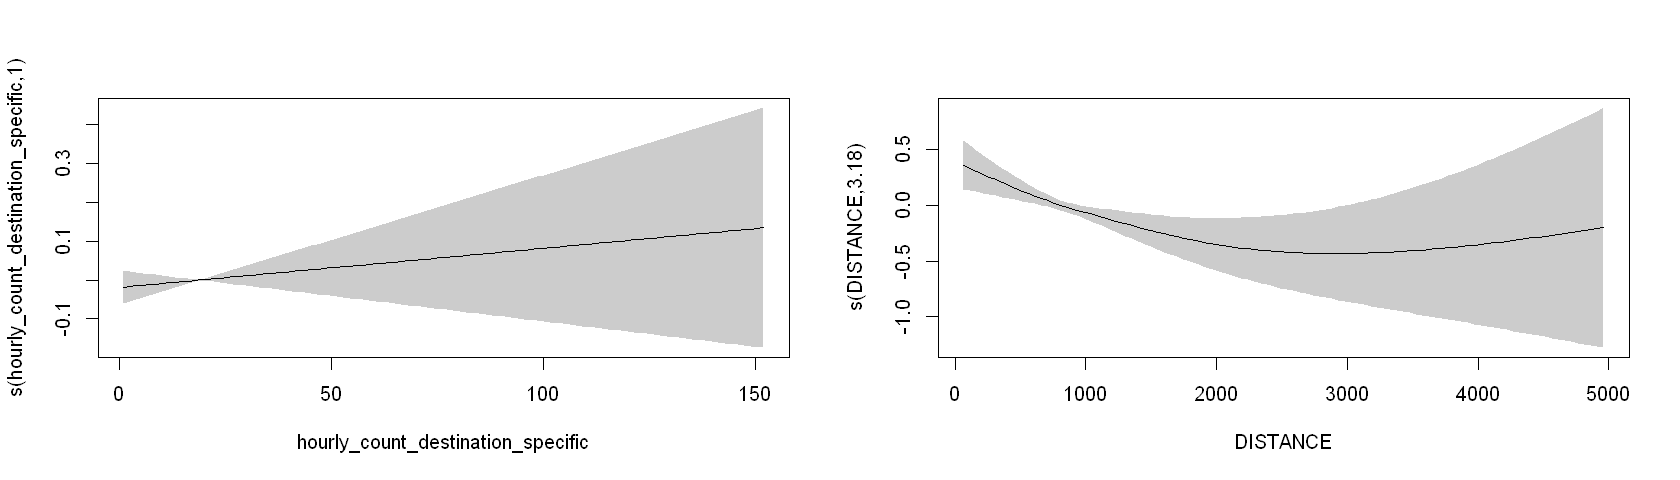

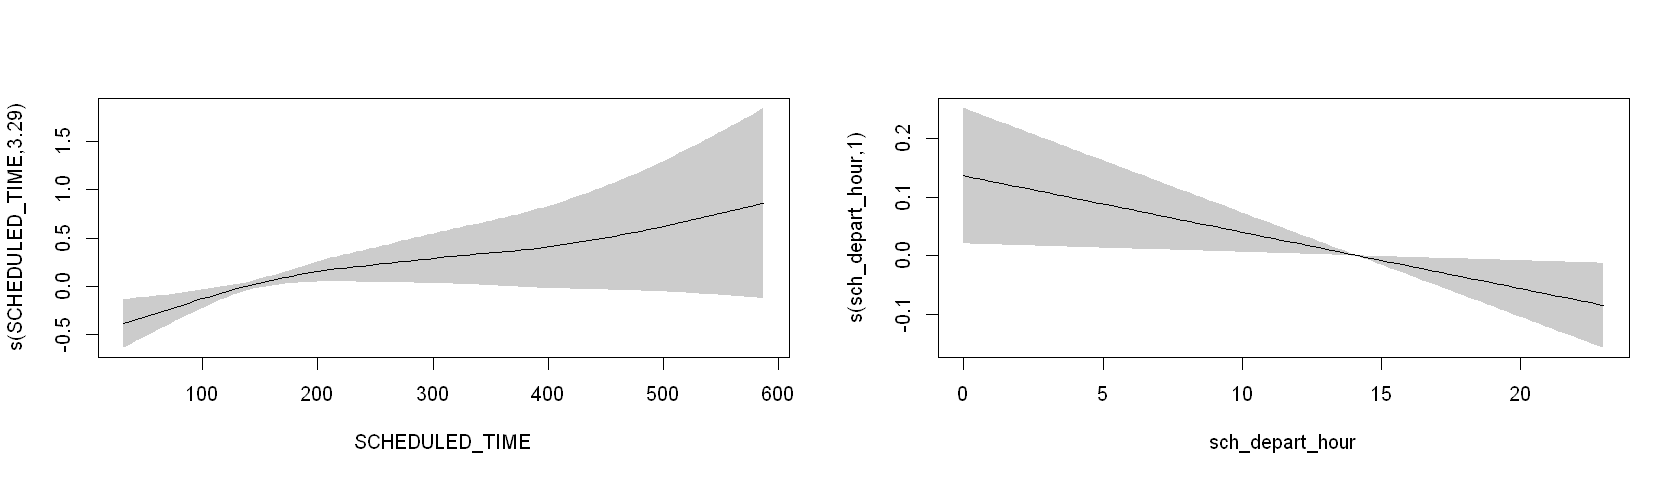

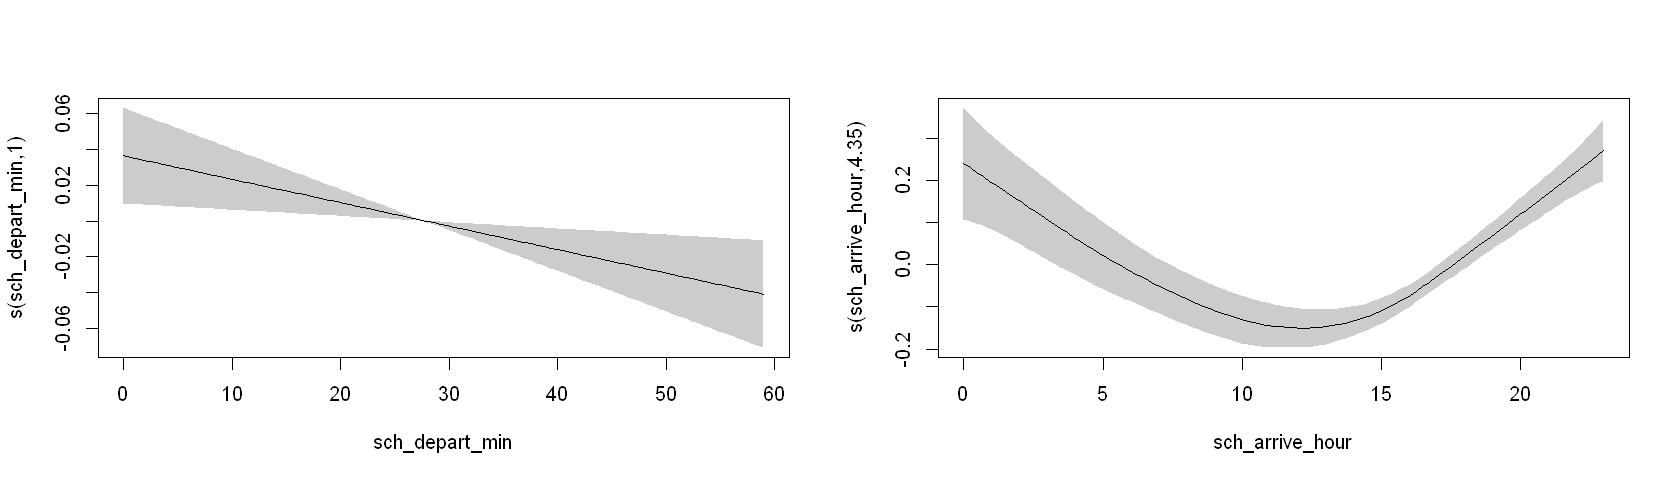

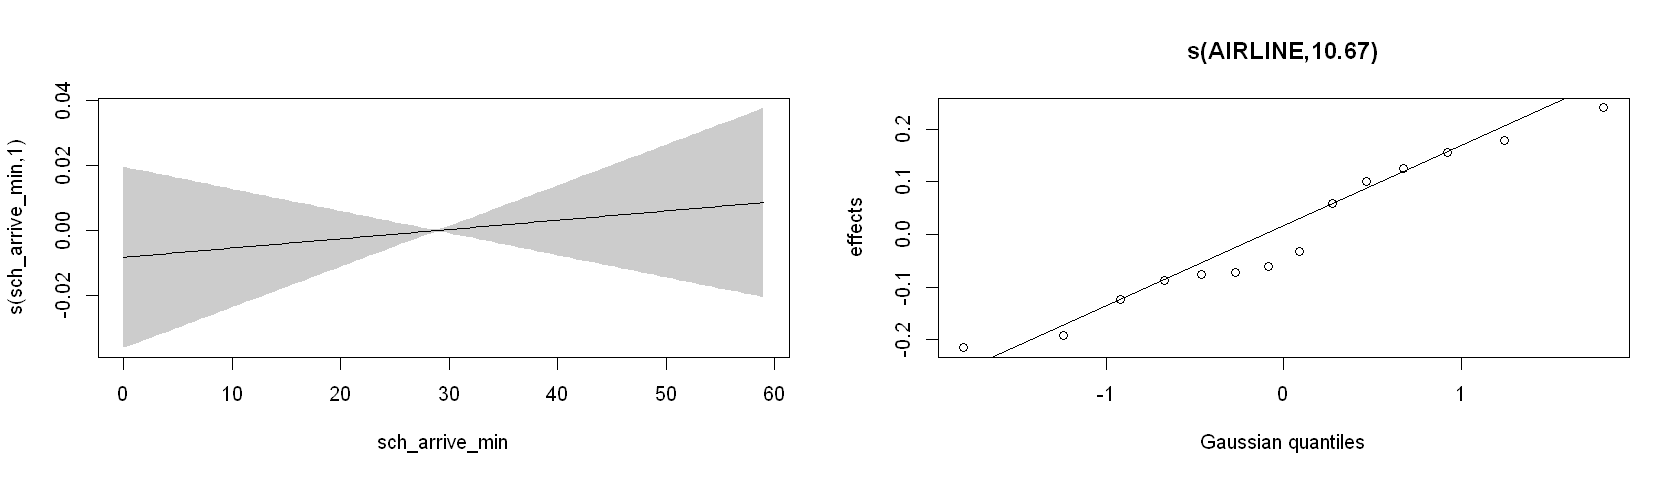

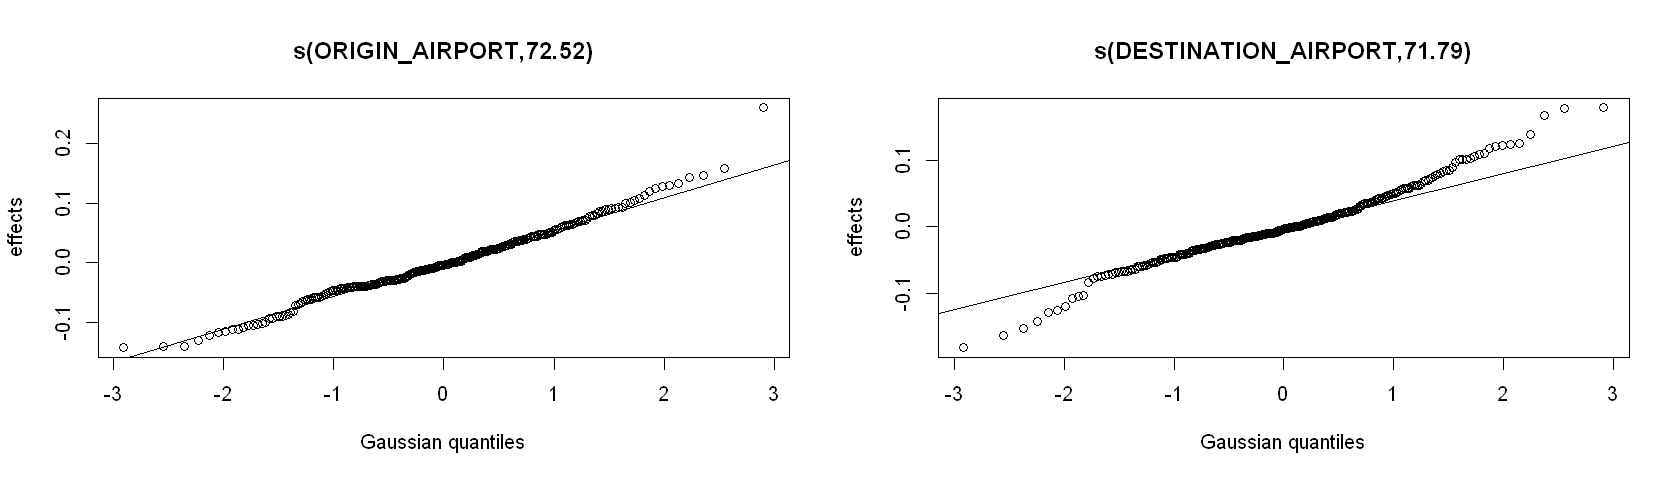

In [182]:
par(mfrow=c(1,2))
options(repr.plot.width=14, repr.plot.height=4)
plot(gamma_depart_2, se = TRUE, shade = TRUE, scale=0)

In [175]:
summary(gamma_arrive_2)


Family: Gamma 
Link function: log 

Formula:
ARRIVAL_DELAY ~ s(MONTH, bs = "cr") + s(DAY, bs = "cr") + s(DAY_OF_WEEK, 
    k = 7, bs = "cr") + s(day_of_year, bs = "cr") + s(sch_hour_of_year, 
    bs = "cr") + s(day.dist.all, bs = "cr") + s(hour.dist.all, 
    bs = "cr") + s(daily_count_airline_specific, bs = "cr") + 
    s(daily_count_origin_specific, bs = "cr") + s(daily_count_destination_specific, 
    bs = "cr") + s(hourly_count_airline_specific, bs = "cr") + 
    s(hourly_count_origin_specific, bs = "cr") + s(hourly_count_destination_specific, 
    bs = "cr") + s(DISTANCE, bs = "cr") + s(SCHEDULED_TIME, bs = "cr") + 
    s(DEPARTURE_DELAY, bs = "cr") + s(TAXI_OUT, bs = "cr") + 
    s(sch_depart_hour, bs = "cr") + s(sch_depart_min, bs = "cr") + 
    s(sch_arrive_hour, bs = "cr") + s(sch_arrive_min, bs = "cr") + 
    s(AIRLINE, bs = "re") + s(ORIGIN_AIRPORT, bs = "re") + s(DESTINATION_AIRPORT, 
    bs = "re")

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)

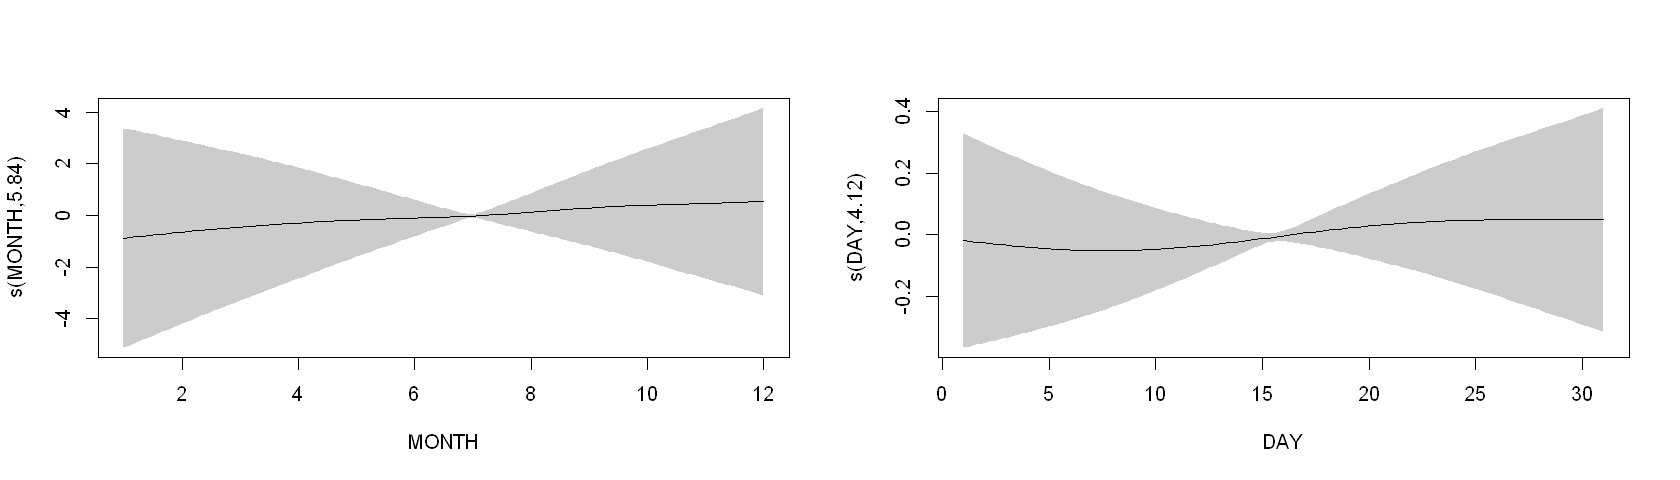

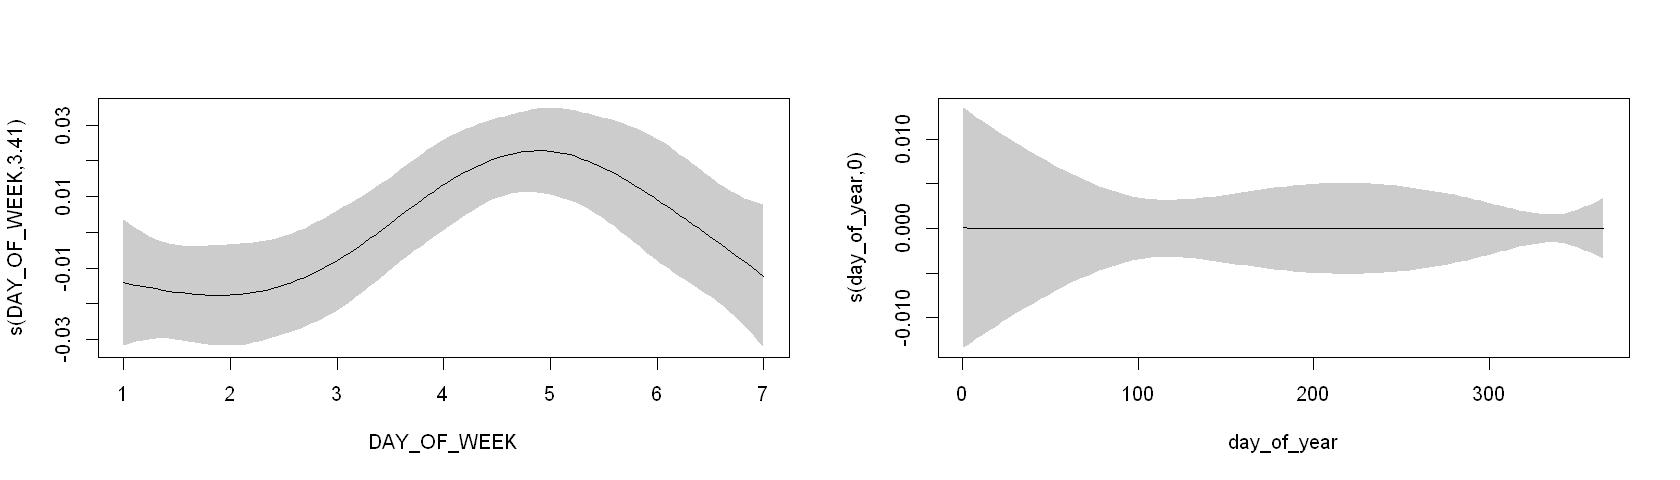

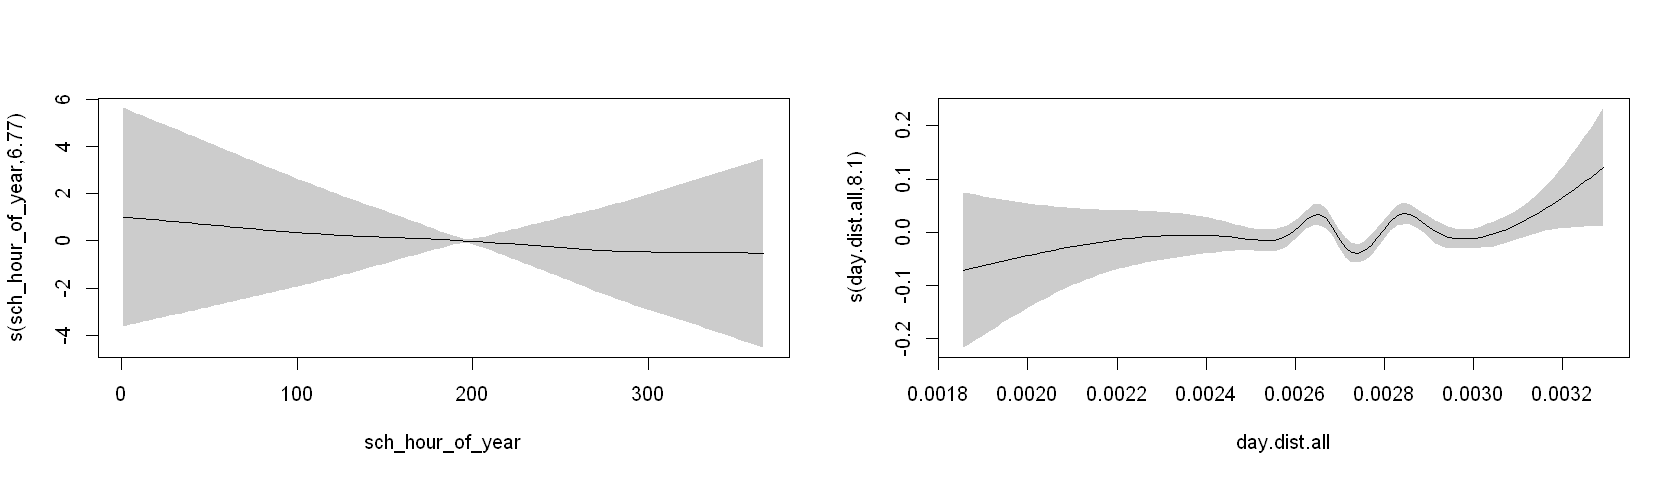

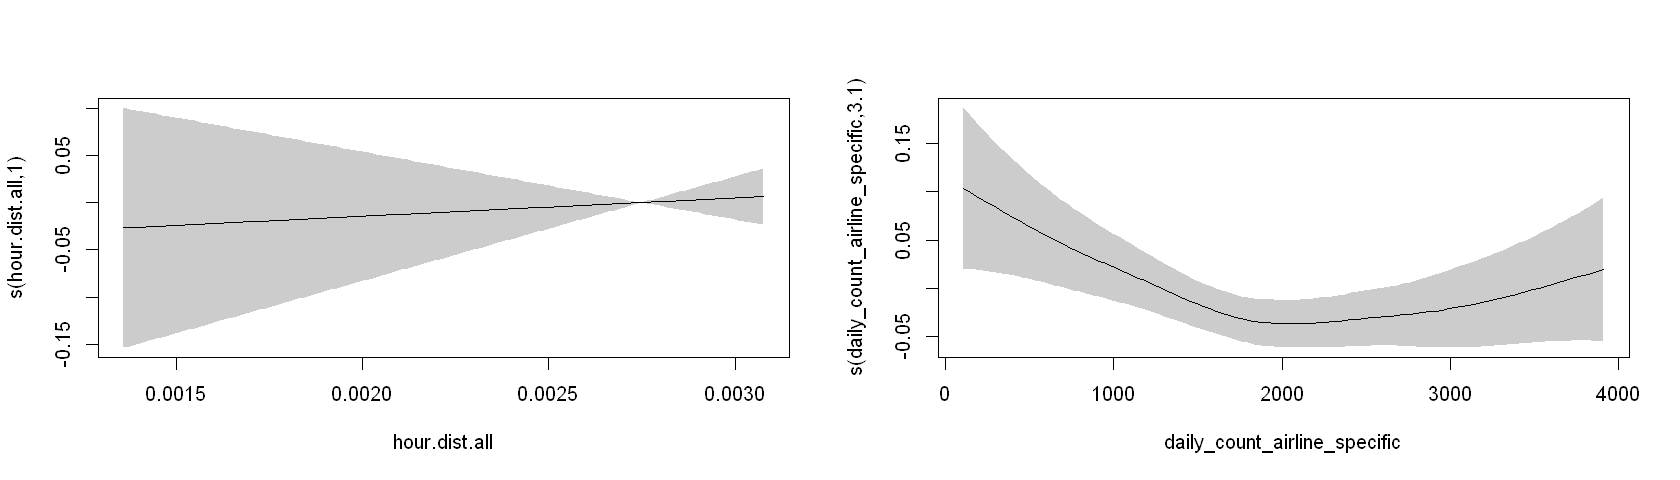

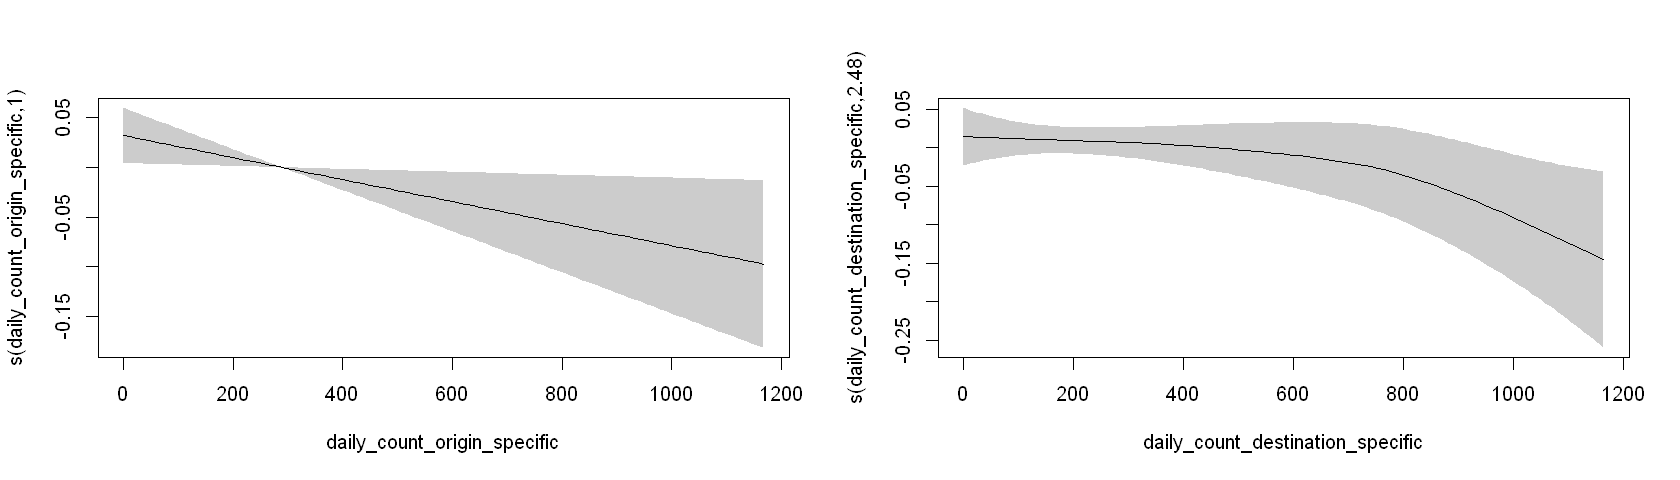

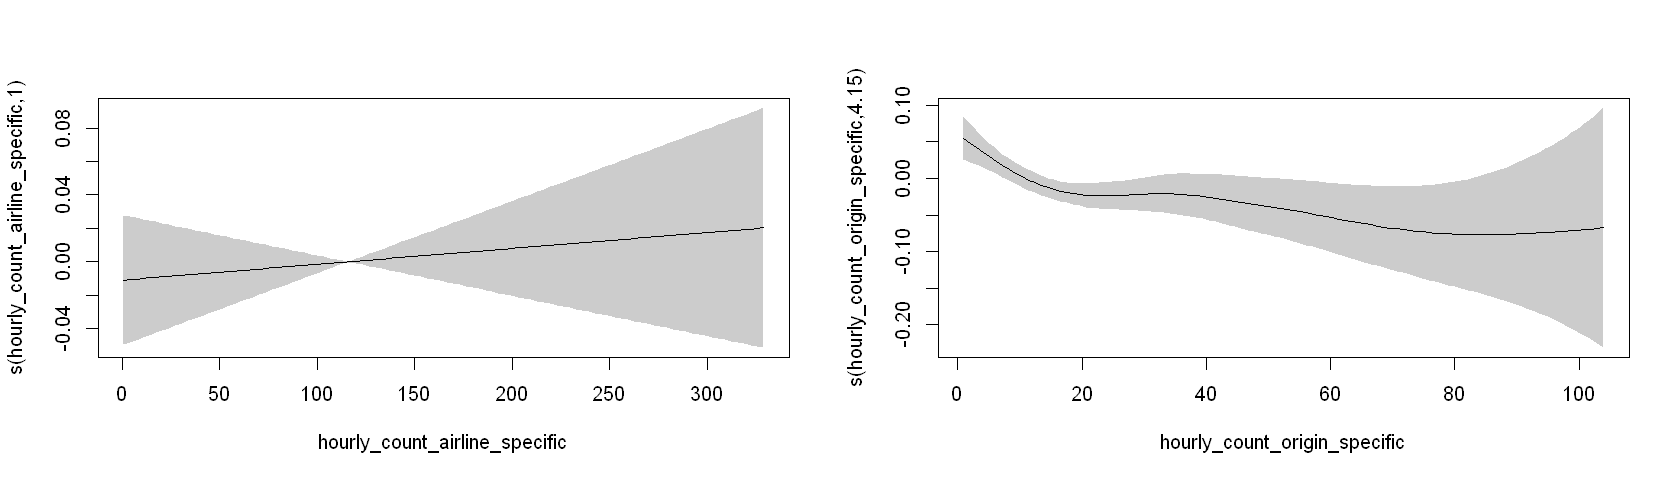

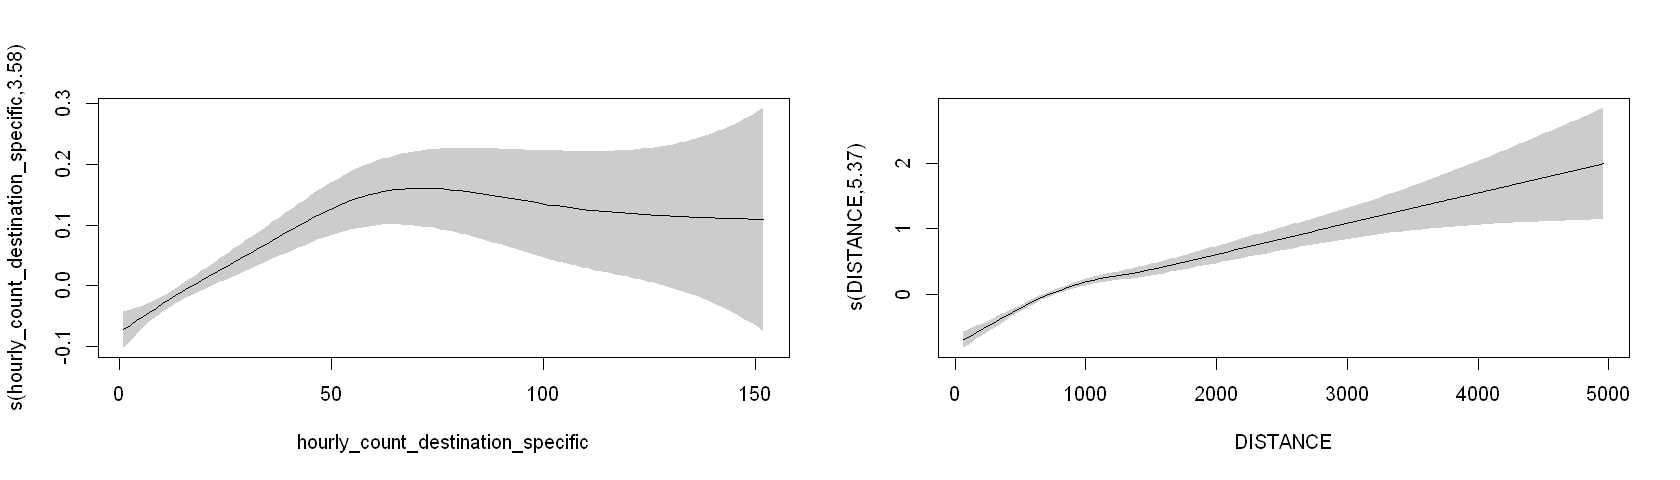

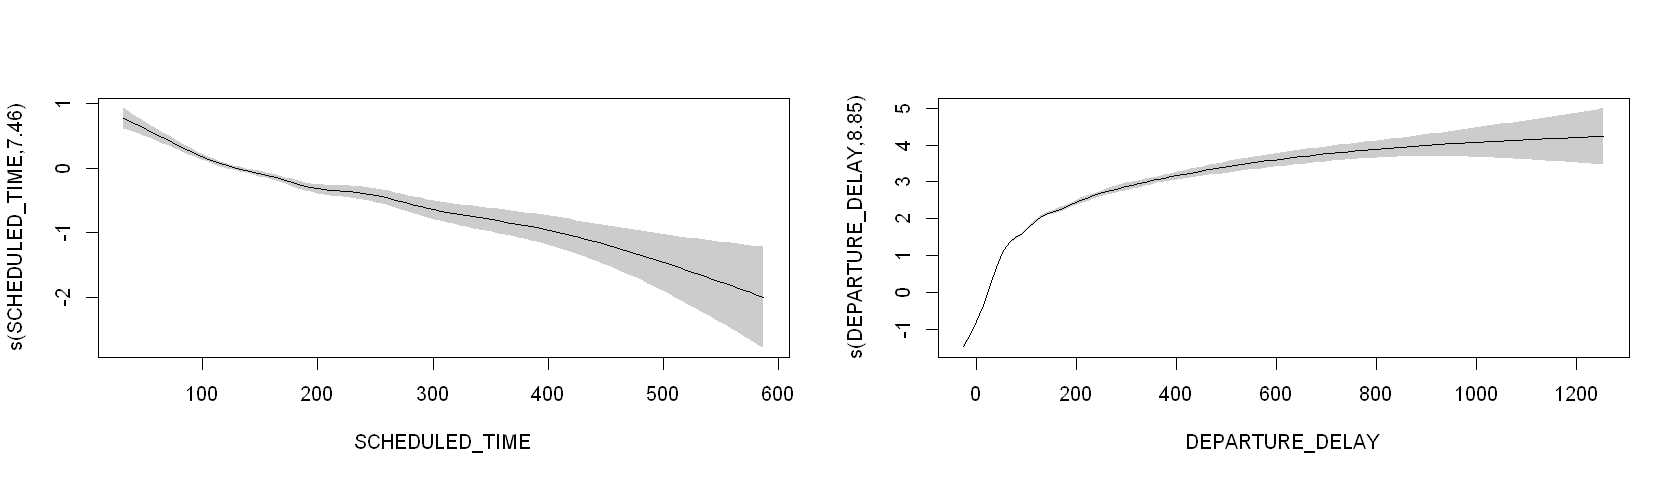

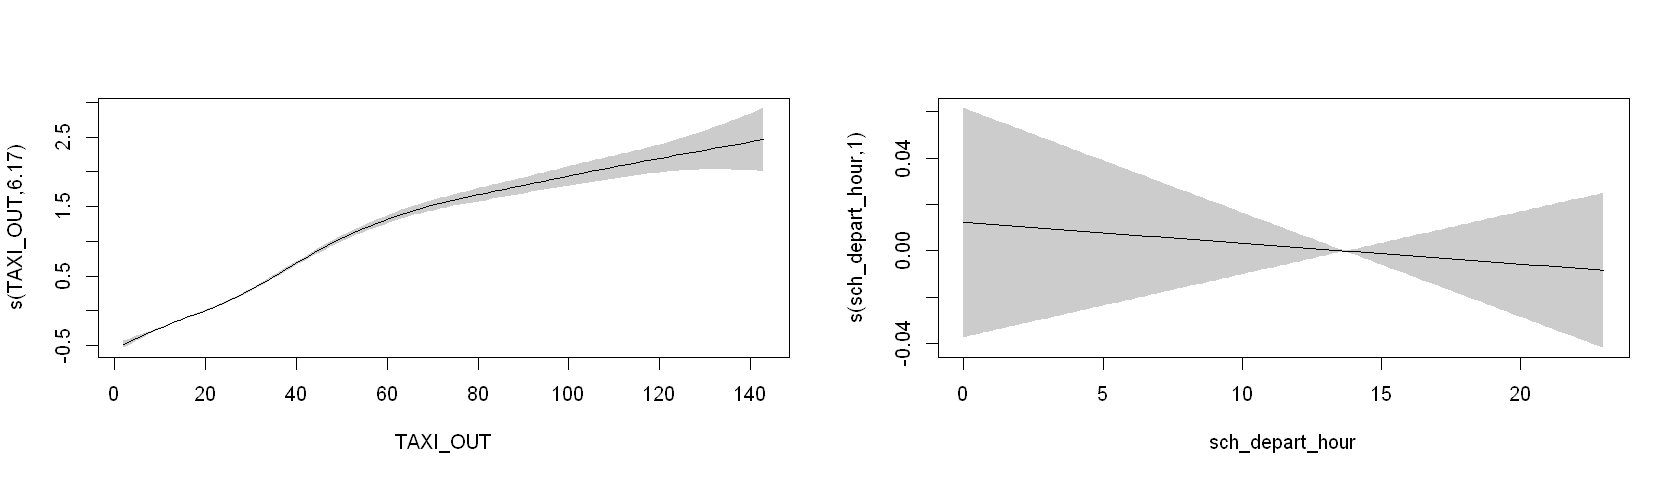

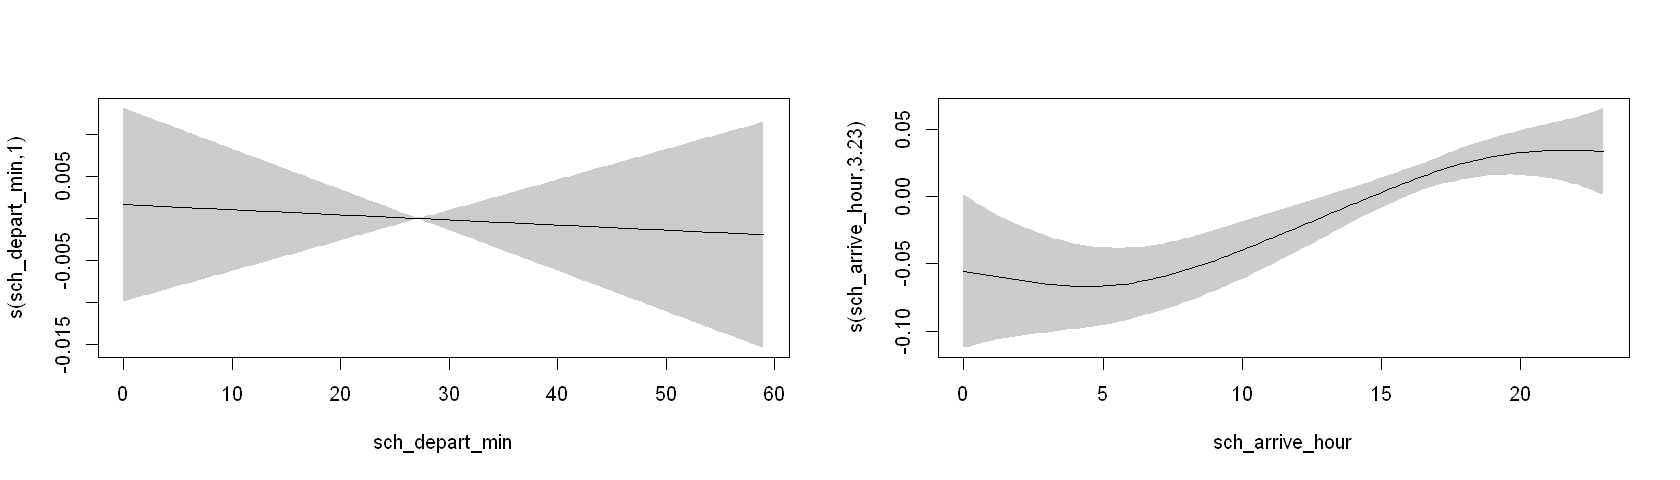

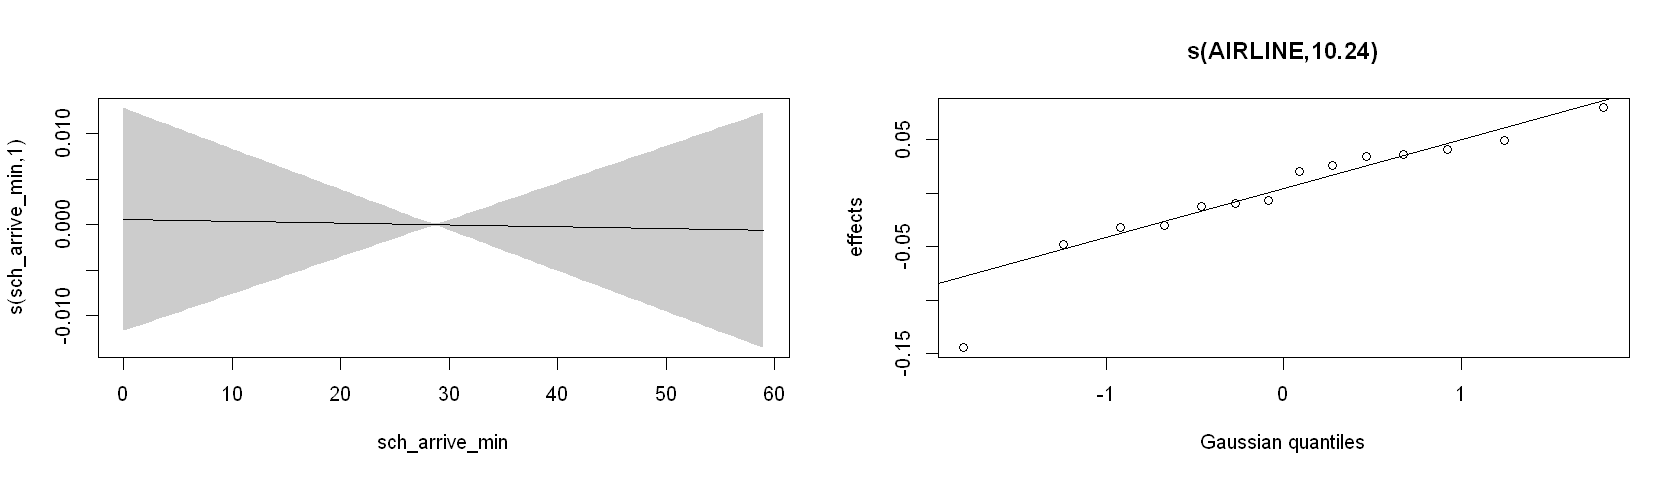

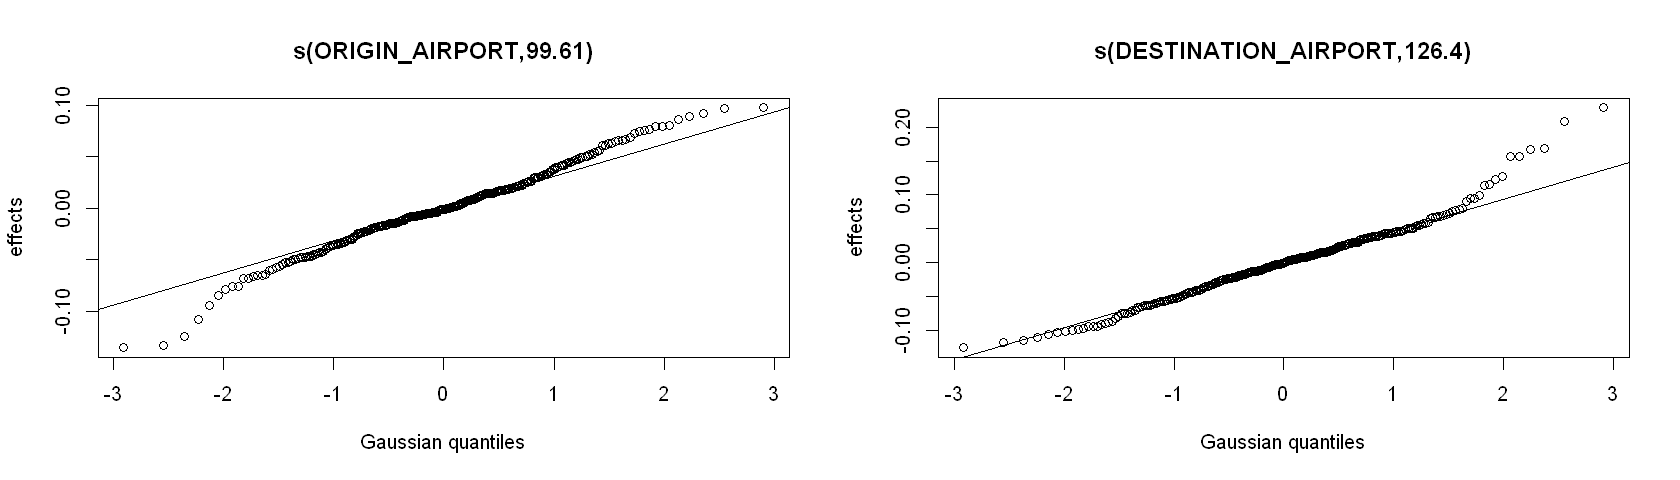

In [179]:
par(mfrow=c(1,2))
options(repr.plot.width=14, repr.plot.height=4)
plot(gamma_arrive_2, se = TRUE, shade = TRUE, scale=0)

In [230]:
coef_val_logistic_depart = data.frame(coef(logistic_depart_2))[170:dim(data.frame(coef(logistic_depart_2)))[1],]
level_name_logistic_depart = c(unique(train.depart$AIRLINE), unique(train.depart$ORIGIN_AIRPORT), unique(train.depart$DESTINATION_AIRPORT))
df_specific_effect_logistic_depart = data.frame(level_name_logistic_depart, coef_val_logistic_depart)

In [290]:
coef_val_logistic_arrive = data.frame(coef(logistic_arrive_2))[188:dim(data.frame(coef(logistic_arrive_2)))[1],]
level_name_logistic_arrive = c(unique(train.arrive$AIRLINE), unique(train.arrive$ORIGIN_AIRPORT), unique(train.arrive$DESTINATION_AIRPORT))
df_specific_effect_logistic_arrive = data.frame(level_name_logistic_arrive, coef_val_logistic_arrive)

In [257]:
df_airline_effect = data.frame(unique(train.depart$AIRLINE),
                                 df_specific_effect_logistic_depart[1:length(unique(train.depart$AIRLINE)),2],
                                 df_specific_effect_logistic_arrive[1:length(unique(train.arrive$AIRLINE)),2])
colnames(df_airline_effect) = c("AIRLINE", "effect_depart_delay", "effect_arrive_delay")

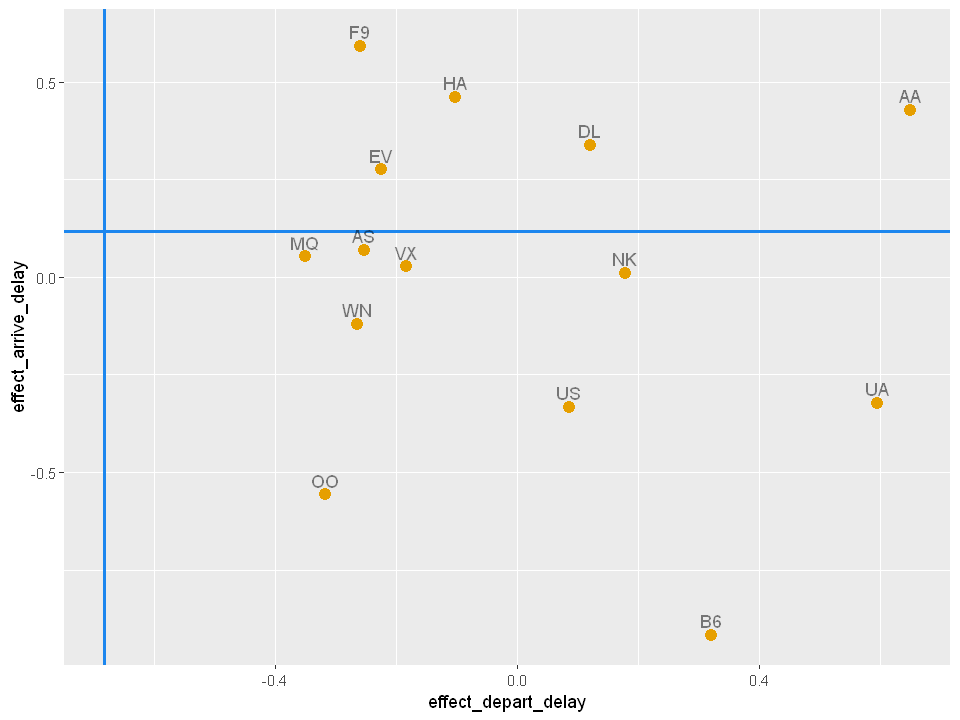

In [260]:
options(repr.plot.width=8, repr.plot.height=6)

ggplot(df_airline_effect, aes(x=effect_depart_delay, y=effect_arrive_delay)) +
  geom_point(size=3, col="#E69F00") + 
  geom_vline(xintercept = data.frame(coef(logistic_depart_2))[1,1], col="dodgerblue2", lwd=1) + 
  geom_hline(yintercept = data.frame(coef(logistic_arrive_2))[1,1], col="dodgerblue2", lwd=1) +
  geom_text(label=df_airline_effect$AIRLINE, col="black", alpha = 0.5, vjust = 0, nudge_y = 0.02)

In [278]:
df_origin_airport_effect = data.frame(
    unique(train.depart$ORIGIN_AIRPORT),
    df_specific_effect_logistic_depart[(length(unique(train.depart$AIRLINE))+1):(length(unique(train.depart$AIRLINE))+length(unique(train.depart$ORIGIN_AIRPORT))),2],
    df_specific_effect_logistic_arrive[(length(unique(train.arrive$AIRLINE))+1):(length(unique(train.arrive$AIRLINE))+length(unique(train.arrive$ORIGIN_AIRPORT))),2])
colnames(df_origin_airport_effect) = c("ORIGIN_AIRPORT", "effect_depart_delay", "effect_arrive_delay")

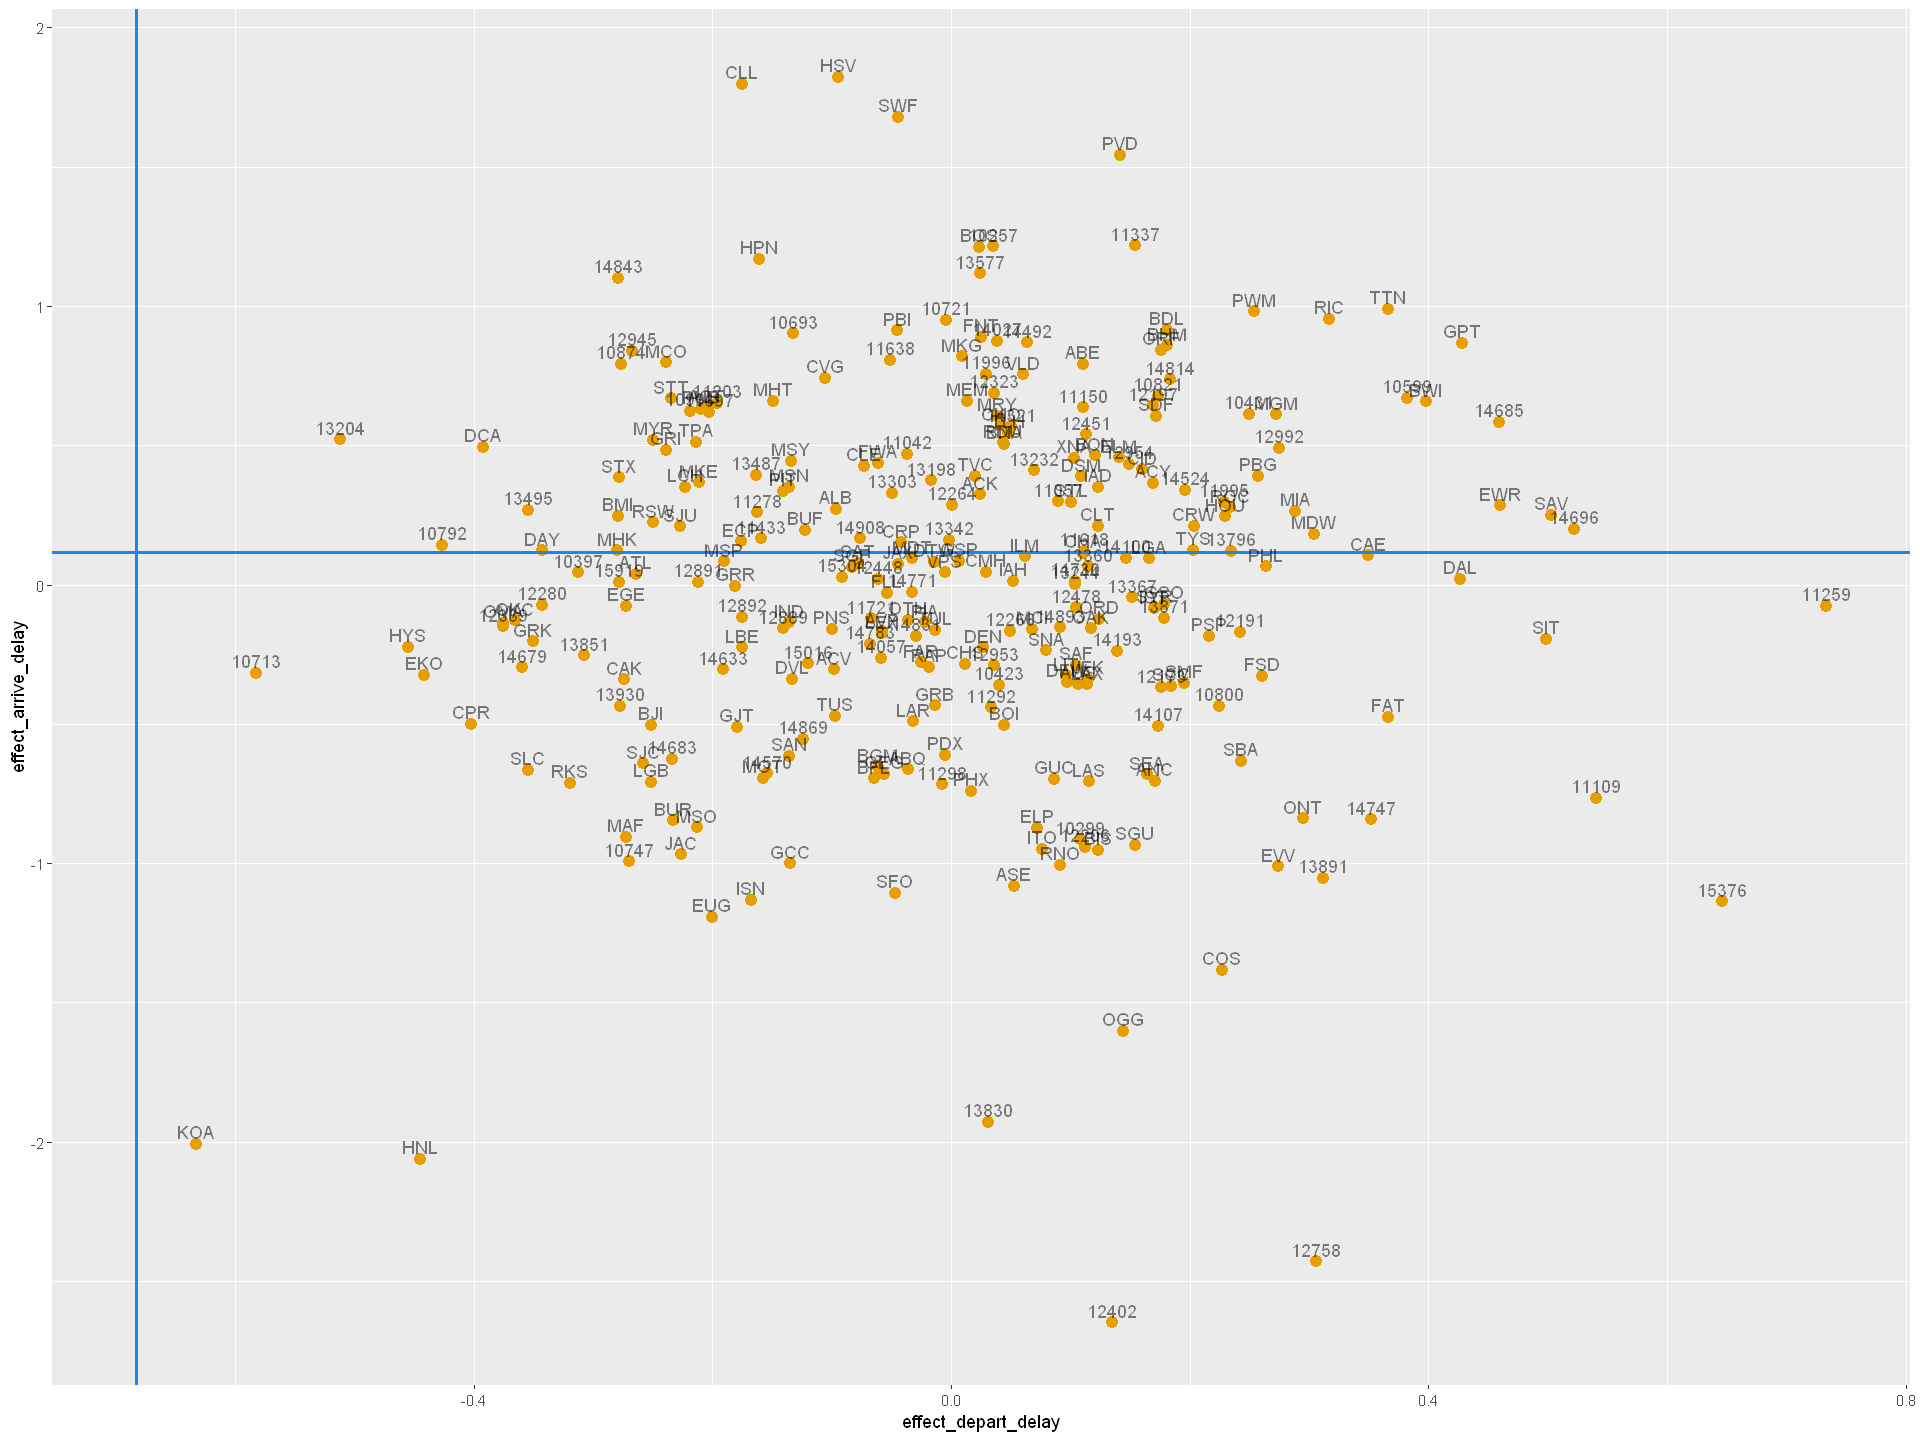

In [280]:
options(repr.plot.width=16, repr.plot.height=12)

ggplot(df_origin_airport_effect, aes(x=effect_depart_delay, y=effect_arrive_delay)) +
  geom_point(size=3, col="#E69F00") + 
  geom_vline(xintercept = data.frame(coef(logistic_depart_2))[1,1], col="dodgerblue2", lwd=1) + 
  geom_hline(yintercept = data.frame(coef(logistic_arrive_2))[1,1], col="dodgerblue2", lwd=1) +
  geom_text(label=df_origin_airport_effect$ORIGIN_AIRPORT, col="black", alpha = 0.5, vjust = 0, nudge_y = 0.02)

In [281]:
df_destination_airport_effect = data.frame(
    unique(train.depart$DESTINATION_AIRPORT),
    df_specific_effect_logistic_depart[(length(unique(train.depart$AIRLINE))+length(unique(train.depart$ORIGIN_AIRPORT))+1):dim(df_specific_effect_logistic_depart)[1],2],
    df_specific_effect_logistic_arrive[(length(unique(train.arrive$AIRLINE))+length(unique(train.arrive$ORIGIN_AIRPORT))+1):dim(df_specific_effect_logistic_arrive)[1],2])
colnames(df_destination_airport_effect) = c("DESTINATION_AIRPORT", "effect_depart_delay", "effect_arrive_delay")

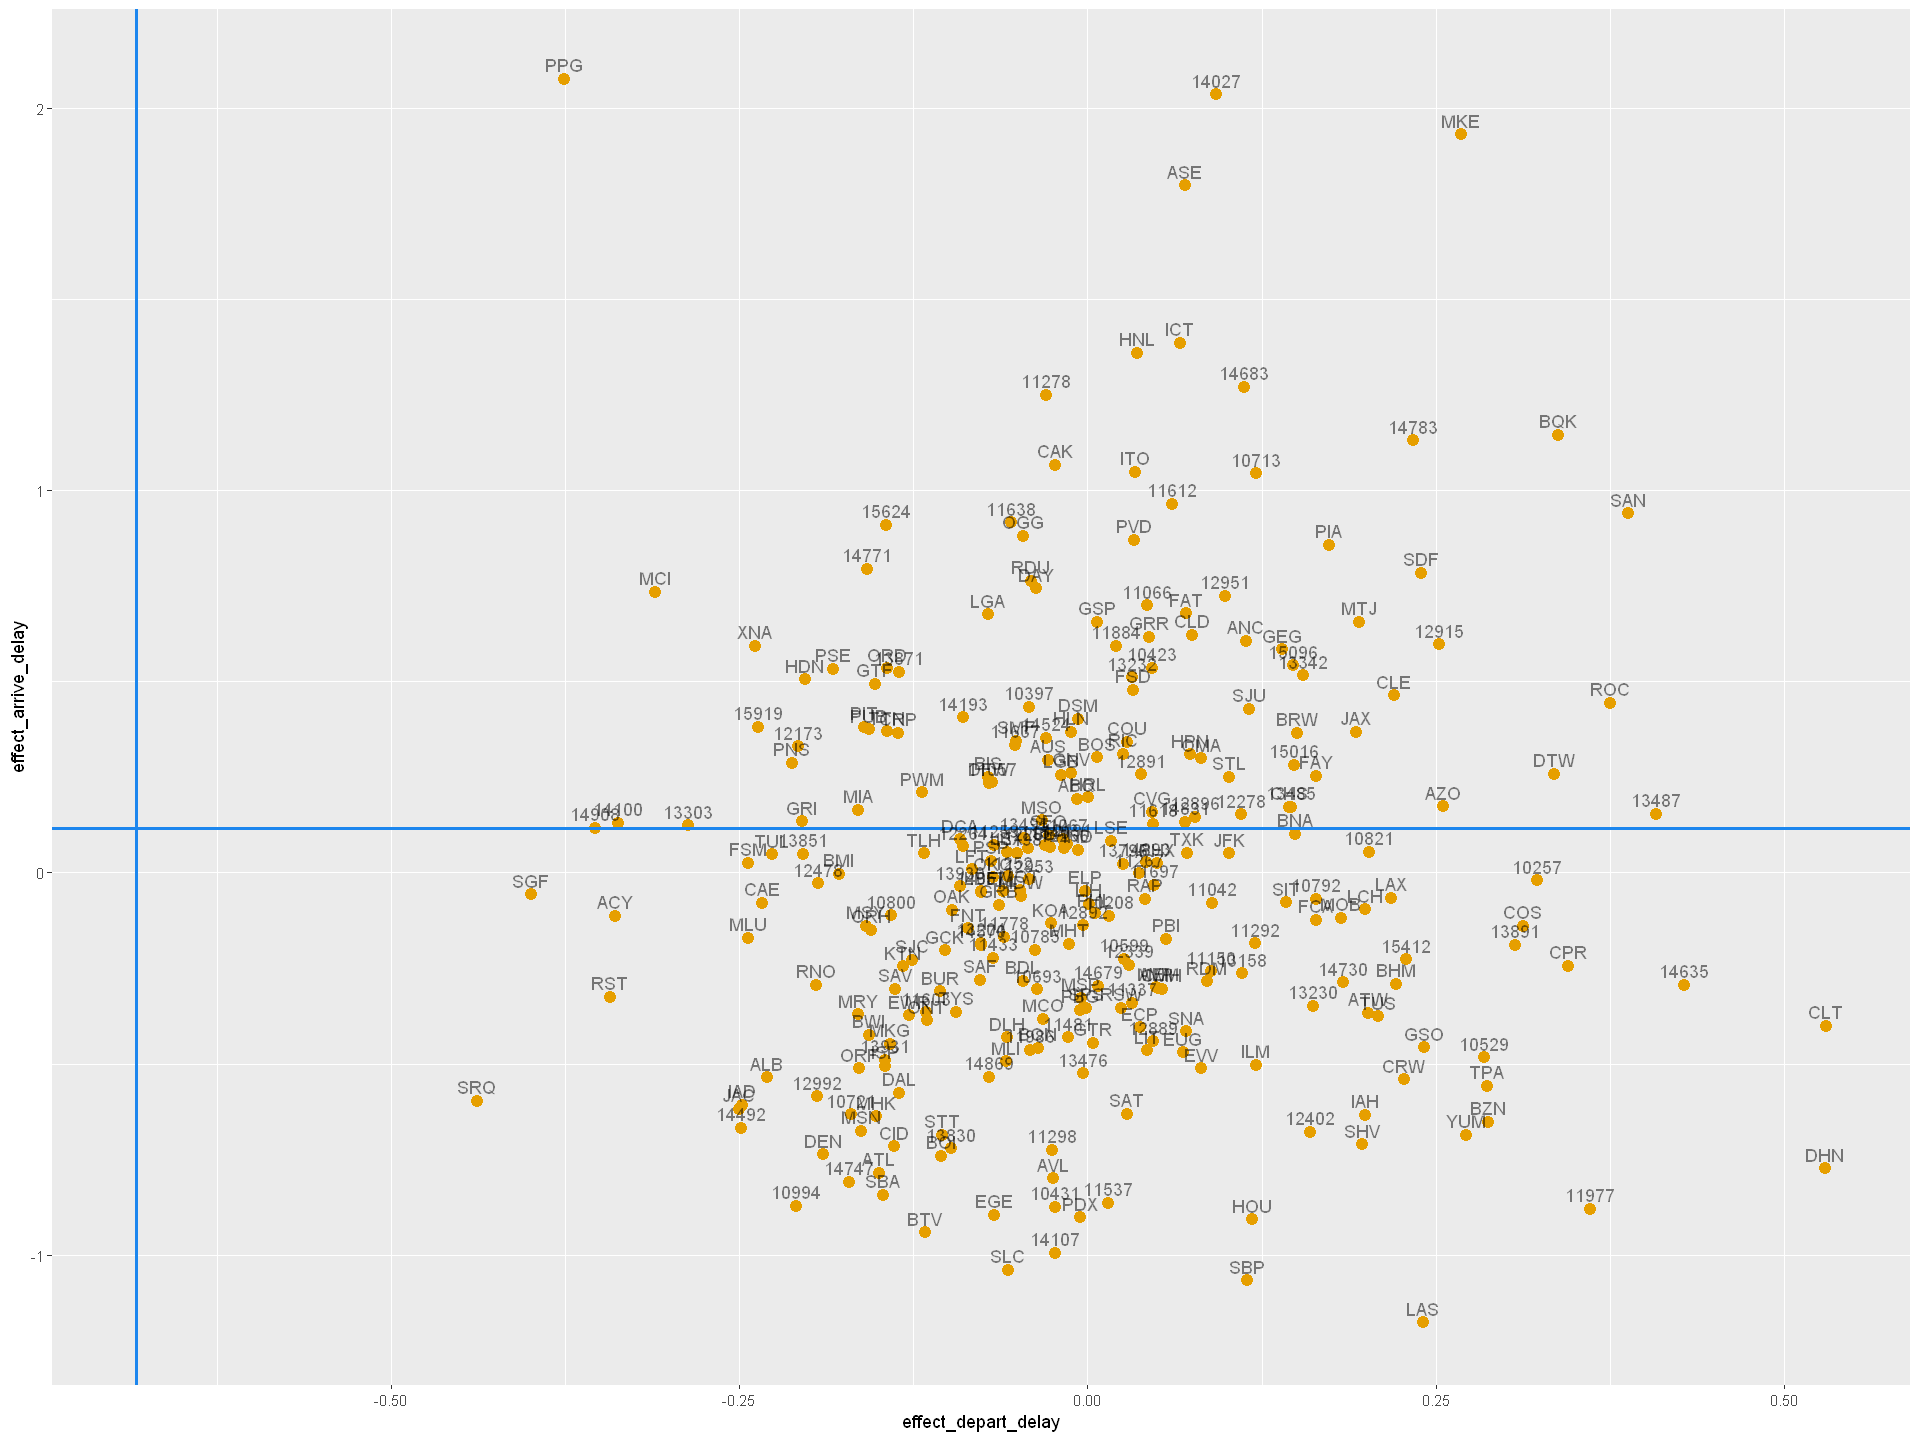

In [282]:
options(repr.plot.width=16, repr.plot.height=12)

ggplot(df_destination_airport_effect, aes(x=effect_depart_delay, y=effect_arrive_delay)) +
  geom_point(size=3, col="#E69F00") + 
  geom_vline(xintercept = data.frame(coef(logistic_depart_2))[1,1], col="dodgerblue2", lwd=1) + 
  geom_hline(yintercept = data.frame(coef(logistic_arrive_2))[1,1], col="dodgerblue2", lwd=1) +
  geom_text(label=df_destination_airport_effect$DESTINATION_AIRPORT, col="black", alpha = 0.5, vjust = 0, nudge_y = 0.02)

<i><b>Analysis on flight cancellations: </b></i>

As shown at the exploratory visualization section, number of cancelled flights only accounted for 1.54% of total records, and the number of cancellations per hourly time interval would be rare occurrences following Poisson distributions, analogous to modelling the annual counts of earthquakes. Generating aggregations by the hour of the year, we could get a time series sequence of the hourly numbers of flights cancelled. It was hypothesized if there was unobservable dependence of the observed sequence on a hidden transition state sequence, hence Poisson HMM would be a popular statistical modelling option to recognize the patterns. Validations with number of hidden states ranging from 2 to 10 were experimented.

Given that within some periods there might be extremely large number of cancellations due to abrupt conditions, like weather’s impacts, this would cause the Poisson HMM difficult to define a set of good initial estimates and successfully converge in fitting data with the package of “depmixS4”. Here, dividing the numbers by 10 binning the data could be an option to get the model converged. 

Determining through AIC and BIC of the fitted models, AIC attained minimum at 10 states while BIC was the lowest at 6 states, however for AIC, there was an increase from 7 states to 8 states, and the score of the 7-state model did not deviate much from that of the 10-state model. Therefore, it was reasonable to select the 6-state HMM and 7-state HMM and inspect their output summary. The transition probability matrix of the two models was maximized at diagonal elements for majority of states. 

For the 6-state HMM, the estimated Poisson rate parameters were listed as <br>
λ1: 10 * exp(1.765) = 58.4 cancellations; <br>
λ2: 10 * exp(-0.164) = 8.5 cancellations; <br>
λ3: 10 * exp(2.722) = 152.1 cancellations; <br>
λ4: 10 * exp(-3.489) = 0.3 cancellations; <br>
λ5: 10 * exp(-0.716) = 4.9 cancellations; <br>
λ6: 10 * exp(0.845) = 23.3 cancellations. <br>
Therefore, hidden state 4 was corresponding to low cancellation numbers close to zero, and states 2 and 5 were emitted with probability distributions to obtain observations of few cancellations below 10 cases, while hidden state 3 was inferred to be extremely high cancellation numbers averagely over 150 flights within an hour.

The fitted distributions of the rate parameter estimates given by 7 states were  <br>
λ1: 10 * exp(-4.460) = 0.1 cancellations; <br>
λ2: 10 * exp(0.997) = 27.1 cancellations; <br>
λ3: 10 * exp(-0.058) = 9.4 cancellations; <br>
λ4: 10 * exp(2.737) = 154.4 cancellations; <br>
λ5: 10 * exp(-0.508) = 6.0 cancellations; <br>
λ6: 10 * exp(1.817) = 61.5 cancellations. <br>
λ7: 10 * exp(-2.706) = 0.7 cancellations. <br>
The 7-state HMM added one hidden state further differentiating the state of low mean number of cancellations (state 4 in the 6-state HMM) into two states (state 1 and state 7 with mean number of cancellations smaller than 1.0), while other states were similar. Increasing hidden states could better to represent the data as it would get to be more informative and helpful to predict boundary patterns, while the improvements might be not significant, for simplicity, 6-state Poisson HMM would be an appropriate model.

In [294]:
## count of daily cancellations
flights2_cancel = aggregate(CANCELLED ~ sch_hour_of_year, data = flights, FUN = sum)

In [ ]:
library(depmixS4)
library(HMM)

In [ ]:
## Poisson HMM on daily cancellation counts
hmm_list = list()
fitted_hmm_list = list()

for (i in 2:10){
    hmm <- depmix(round(flights2_cancel[,2] / 10) ~ 1, nstates=i, family=poisson(), ntimes=nrow(flights2_cancel))
    hmm_list[i-1] <- hmm
    fitted_hmm_list[i-1] <- fit(hmm)
}

In [319]:
aic_hmm = list()
bic_hmm = list()
loglik_hmm = list()

for (i in 2:10){
    aic_hmm[i-1] = AIC(fitted_hmm_list[[i-1]])
    bic_hmm[i-1] = BIC(fitted_hmm_list[[i-1]])
    loglik_hmm[i-1] = logLik(fitted_hmm_list[[i-1]])
}

In [330]:
df_hmm = data.frame(rep(c(2:10),2),
                    c(rep(c("AIC"),9),rep(c("BIC"),9)),
                    matrix(c(aic_hmm, bic_hmm)))
colnames(df_hmm) = c("number_states", "metric", "values")
df_hmm$values = as.numeric(df_hmm$values)

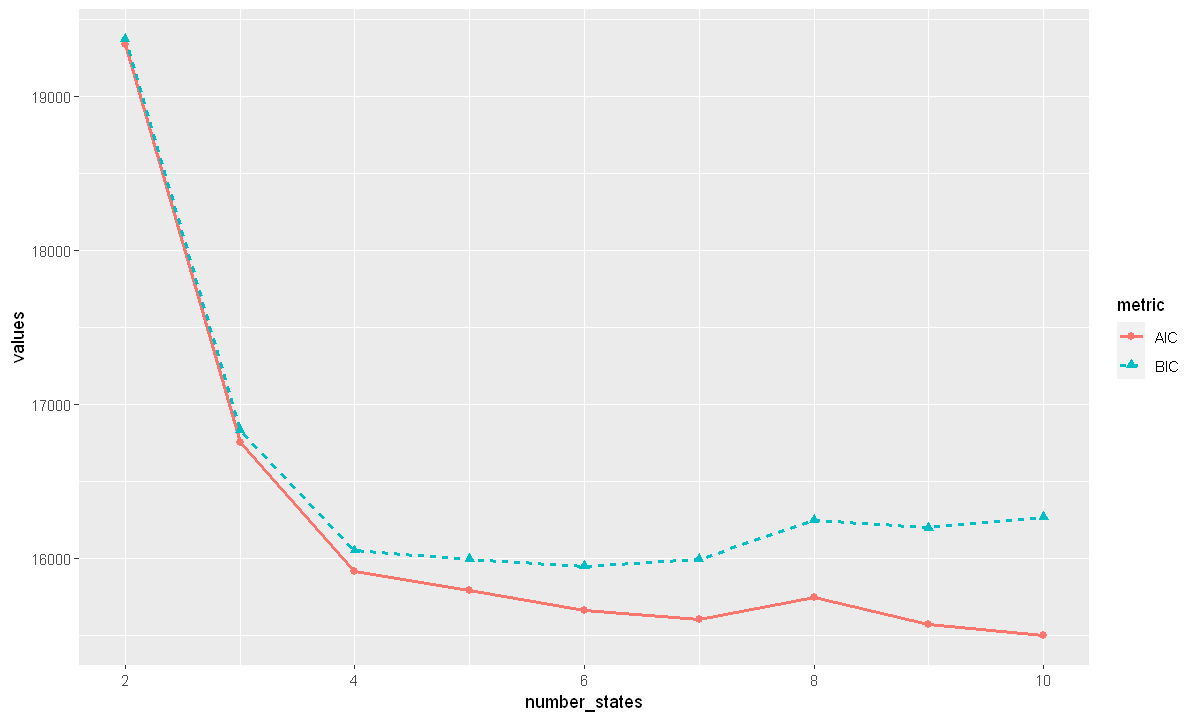

In [346]:
options(repr.plot.width=10, repr.plot.height=6)

ggplot(df_hmm, aes(x=number_states, y=values, group=metric, color=metric))+
  geom_line(aes(linetype=metric), size=1)+
  geom_point(aes(shape=metric), size=2)

In [348]:
summary(fitted_hmm_list[[6-1]])

Initial state probabilities model 
pr1 pr2 pr3 pr4 pr5 pr6 
  0   0   0   1   0   0 

Transition matrix 
        toS1  toS2  toS3  toS4  toS5  toS6
fromS1 0.827 0.000 0.037 0.001 0.000 0.135
fromS2 0.000 0.875 0.000 0.101 0.000 0.024
fromS3 0.145 0.000 0.855 0.000 0.000 0.000
fromS4 0.000 0.000 0.000 0.928 0.072 0.000
fromS5 0.101 0.697 0.000 0.016 0.106 0.081
fromS6 0.024 0.033 0.000 0.106 0.000 0.837

Response parameters 
Resp 1 : poisson 
    Re1.(Intercept)
St1           1.765
St2          -0.164
St3           2.722
St4          -3.489
St5          -0.716
St6           0.845


In [347]:
summary(fitted_hmm_list[[7-1]])

Initial state probabilities model 
pr1 pr2 pr3 pr4 pr5 pr6 pr7 
  1   0   0   0   0   0   0 

Transition matrix 
        toS1  toS2  toS3  toS4  toS5  toS6  toS7
fromS1 0.601 0.000 0.000 0.000 0.000 0.000 0.399
fromS2 0.000 0.847 0.000 0.000 0.130 0.024 0.000
fromS3 0.000 0.034 0.870 0.001 0.095 0.000 0.000
fromS4 0.000 0.000 0.000 0.851 0.000 0.149 0.000
fromS5 0.543 0.000 0.000 0.000 0.456 0.000 0.001
fromS6 0.000 0.102 0.000 0.037 0.030 0.831 0.000
fromS7 0.361 0.004 0.135 0.000 0.000 0.014 0.486

Response parameters 
Resp 1 : poisson 
    Re1.(Intercept)
St1          -4.460
St2           0.997
St3          -0.058
St4           2.737
St5          -0.508
St6           1.817
St7          -2.706


<i><b>Analysis on reasons of delay: </b></i>

The raw data allocated how many minutes were attributed to each of the 5 root causes in case of delays: airline’s responsibility, security reason, defects of air system, aircraft’s late, bad weather conditions. To learn the dependence among these factors, Bayesian network with Gaussian conditional probability for each node was constructed.

Retrieving all observations with non-missing allocated reasons (around 1 million rows), a directed acyclic graph (DAG) was constructed with the structure learnt by the Max-Min Hill Climbing algorithm (the Hill-Climbing heuristic learns the Bayesian network by maximizing the log-likelihood score at each iteration, while Max-Min version applied a hybrid approach to first restrict the structure options by conditional independence constraints, and then maximize the likelihood score. To make comparison, an equivalent Bayesian network was created using a randomly sampled data for 10,000 observations respectively. 

The Bayesian network learnt on 10,000 random samples simply formed four conditional dependent arcs. Security-reasoned delays occurred with its own probability and conditionally independent to other factors, contributing to a mean estimate of 0.05 minutes (S.D. = 1.74 minutes). Air system delay was treated as the starting node, with a mean of 13.27 minutes (S.D. = 26.54 minutes) delayed. Airline factor was conditionally dependent on air system faults and weather condition factor was affected by airline factors. The existance of airline and air system driven delays would determine the probability of late aircraft occurrences. All of the slopes in these dependence realtionships were negative, meaning that it was not common for these effects to co-occur at the same time.

More comprehensive pattern recognition results could be read from the Bayesian network learnt on all data. Delays from air system defects and weather-caused delays were not dependent on any other reason and these two could happen with their own marginal probability distributions. Both problems could affect the conditional probability dependences of late aircraft readiness, extended time for security assurance and additional time for airline’s reactions. Air system defects contributed to an average delay of 13.48 minutes, and this figure was only 2.92 minutes for bad weather, which meant systematic or engineering insufficiencies were more critical than the natural influences in bringing the aviation interruptions. Airline delay was the terminating node that conditionally depended on all other four nodes. The magnitude of four coefficients indicated the individual impacts of the four reasons attributed to the mean length of airline delays. As all coefficients were negative, one unit longer time due to air system and security delays would have more deductions in the minutes allocated to airline responsibility, compared to late-coming aircraft and bad weather. 

Particularly, security reasons had a much lower standard deviation (2.14 minutes) than others (more than 20 and 40 minutes). It probably reflected that with a security regulation or code of practice, this factor would be stably controllable, while time spent to handle other reasons would be more unexpected.

In [ ]:
library(bnlearn)

In [350]:
flights_delay = subset(flights2, !is.na(flights2$AIR_SYSTEM_DELAY))
delay_partition = sample_n(flights_delay, 10000)
delay_partition_reason = delay_partition[,c("AIR_SYSTEM_DELAY","SECURITY_DELAY","AIRLINE_DELAY",
                                            "LATE_AIRCRAFT_DELAY","WEATHER_DELAY")]
for (i in 1:length(colnames(delay_partition_reason))){
  delay_partition_reason[,i] = as.numeric(delay_partition_reason[,i])
}

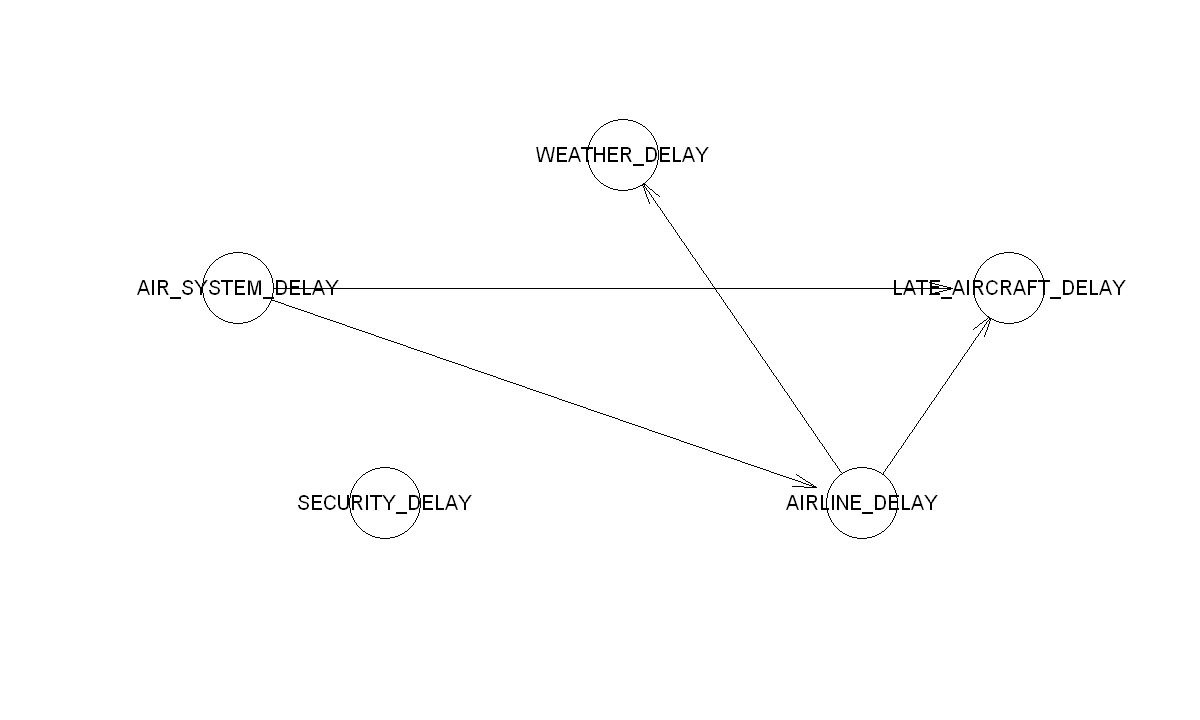

In [354]:
mmhcdag <- mmhc(delay_partition_reason, whitelist = NULL, blacklist = NULL)
plot(mmhcdag)
mmbnfit <- bn.fit(mmhcdag, delay_partition_reason, method = "mle")

In [356]:
mmbnfit


  Bayesian network parameters

  Parameters of node AIR_SYSTEM_DELAY (Gaussian distribution)

Conditional density: AIR_SYSTEM_DELAY
Coefficients:
(Intercept)  
    13.2667  
Standard deviation of the residuals: 26.54483 

  Parameters of node SECURITY_DELAY (Gaussian distribution)

Conditional density: SECURITY_DELAY
Coefficients:
(Intercept)  
     0.0541  
Standard deviation of the residuals: 1.737376 

  Parameters of node AIRLINE_DELAY (Gaussian distribution)

Conditional density: AIRLINE_DELAY | AIR_SYSTEM_DELAY
Coefficients:
     (Intercept)  AIR_SYSTEM_DELAY  
      21.9426879        -0.2234382  
Standard deviation of the residuals: 47.5388 

  Parameters of node LATE_AIRCRAFT_DELAY (Gaussian distribution)

Conditional density: LATE_AIRCRAFT_DELAY | AIR_SYSTEM_DELAY + AIRLINE_DELAY
Coefficients:
     (Intercept)  AIR_SYSTEM_DELAY     AIRLINE_DELAY  
      28.7815111        -0.2554903        -0.1084389  
Standard deviation of the residuals: 42.62481 

  Parameters of node WEATHE

In [352]:
delay_reason_full = flights_delay[,c("AIR_SYSTEM_DELAY","SECURITY_DELAY","AIRLINE_DELAY",
                                     "LATE_AIRCRAFT_DELAY","WEATHER_DELAY")]
for (i in 1:length(colnames(delay_reason_full))){
  delay_reason_full[,i] = as.numeric(delay_reason_full[,i])
}

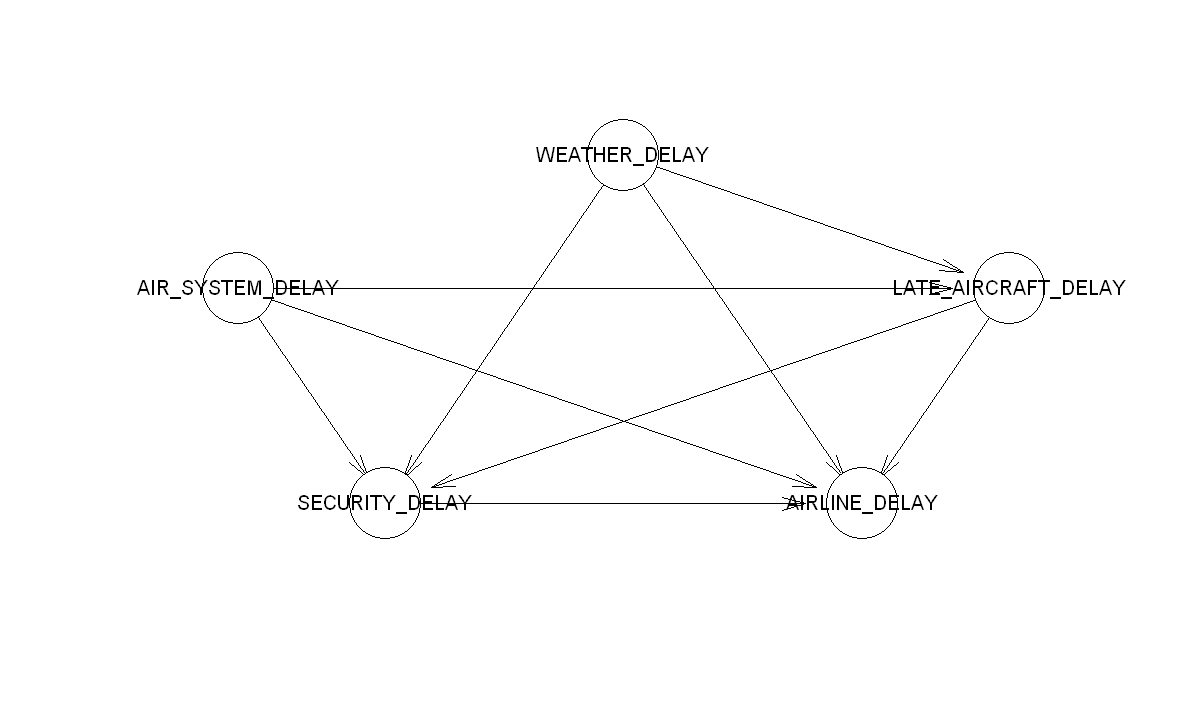

In [355]:
mmhcdag_full <- mmhc(delay_reason_full, whitelist = NULL, blacklist = NULL)
plot(mmhcdag_full)
mmbnfit_full <- bn.fit(mmhcdag_full, delay_reason_full, method = "mle")

In [357]:
mmbnfit_full


  Bayesian network parameters

  Parameters of node AIR_SYSTEM_DELAY (Gaussian distribution)

Conditional density: AIR_SYSTEM_DELAY
Coefficients:
(Intercept)  
   13.48057  
Standard deviation of the residuals: 28.00368 

  Parameters of node SECURITY_DELAY (Gaussian distribution)

Conditional density: SECURITY_DELAY | AIR_SYSTEM_DELAY + LATE_AIRCRAFT_DELAY + WEATHER_DELAY
Coefficients:
        (Intercept)     AIR_SYSTEM_DELAY  LATE_AIRCRAFT_DELAY  
       0.1067453563        -0.0009783885        -0.0006743428  
      WEATHER_DELAY  
      -0.0005397443  
Standard deviation of the residuals: 2.143119 

  Parameters of node AIRLINE_DELAY (Gaussian distribution)

Conditional density: AIRLINE_DELAY | AIR_SYSTEM_DELAY + SECURITY_DELAY + LATE_AIRCRAFT_DELAY + WEATHER_DELAY
Coefficients:
        (Intercept)     AIR_SYSTEM_DELAY       SECURITY_DELAY  
         25.9287111           -0.2389886           -0.3621910  
LATE_AIRCRAFT_DELAY        WEATHER_DELAY  
         -0.1422949           -0.12

<i><b>Other remarks:</b></i>

There has been growing attentions being put on machine learning and deep learning algorithms applied to flight delay predictions. Like Bayesian network, researchers used advanced graphical models like deep belief network (DBN) for more effective feature extractions dividing the variables obtained into sub-factors, and pass the feature sets to support vector machine for predictions of delay time. We could also consider to capture spatial and temporal variables, like the different options of flight routes planned for different weather conditions or seasonality, aircraft internal design and capacity, time series of passenger flows within the airports, etc. Recurrent neural network (RNN) especially long-short term memory (LSTM), fuzzy logic network, k-nearest neighbours and random forest were also extensively experimented in some other research. Big data and deep learning can provide a great potential for the aviation domain, and is believed to be the active field in recent research.